In [1]:
machine_name = 'EAST'
divertor_name='EAST_divertor.dat'
equili_name='73999_030400ms.mat'

from os import sys, path; sys.path.append(path.dirname(path.abspath(path.abspath(''))))
import ergospy.file, ergospy.IPyUI
import matplotlib.path as mplPath
path_machine = ergospy.file.PathMachine(machine_name)
folder_equilibrium = ergospy.file._path_ergos / 'equilibrium_preparation'
div_RZ = ergospy.file.DivertorRead(machine_name, divertor_name)
div_path = mplPath.Path(div_RZ)


## FLTs Initiate from SOL with Equilibrium Field 

In [2]:
import numpy as np
import pandas as pd
FLT_df = pd.DataFrame(
    columns =  
    ["Len", "Min s", 
    "Init R", "Init Z", "Init Phi", 
    "Up End R", "Up End Z", "Up End Phi", 
    "Down End R", "Down End Z", "Down End Phi", 
    "Up End AOI", "Down End AOI"]) # AOI for Angle of Incidence

equili_dict = ergospy.file.EquiliDictRead(machine_name, equili_name)
S, TET = equili_dict['S'][:,0], equili_dict['TET'][:,0]
Q = equili_dict['Q'][:,0]
r_mesh,z_mesh = equili_dict['r_mesh'], equili_dict['z_mesh']

TET_halfnum, repeat_times = 15, 1
TET_indrange = range(-TET_halfnum, TET_halfnum+1) 
start_points_rzphi = np.stack(
    (np.repeat(r_mesh[-1,TET_indrange]+7e-2,repeat_times), 
     np.repeat(z_mesh[-1,TET_indrange], repeat_times), 
     np.random.uniform(0.0,2*np.pi,len(r_mesh[-1,TET_indrange])*repeat_times)), axis=-1)
start_points_rzphi+= np.random.rand(*start_points_rzphi.shape)*1e-5
flt_num = start_points_rzphi.shape[0]
FLT_df['Init R'] = start_points_rzphi[:,0]
FLT_df['Init Z'] = start_points_rzphi[:,1]
FLT_df['Init Phi']=start_points_rzphi[:,2]
print(f"Totally {flt_num} lines to trace.")

Totally 31 lines to trace.


In [3]:
from importlib import reload
reload(ergospy.measure.FLT)

AttributeError: module 'ergospy' has no attribute 'measure'

In [3]:
from multiprocessing import Pool
from ergospy.field.Field import Field2D

# Generate 2D RZ-mesh 
folder_equilibrium = '../equilibrium_preparation/'
nR, nZ = np.loadtxt(folder_equilibrium+'nR_nZ.dat', dtype=np.uint32)
RZlimit = np.loadtxt(folder_equilibrium+'R_Z_min_max.dat', dtype=np.float32)

R = np.linspace(RZlimit[0],RZlimit[1], nR) # [Rmin, Rmin+dR, ..., Rmax] totally nR elements.
Z = np.linspace(RZlimit[2],RZlimit[3], nZ) # [Zmin, Zmin+dZ, ..., Zmax] totally nZ elements.

# Reading scalar field and calculate their components in cylindrical coordinate
BR = np.loadtxt(folder_equilibrium+'BR.dat', dtype=np.float32).T
BZ = np.loadtxt(folder_equilibrium+'BZ.dat', dtype=np.float32).T
BPhi=np.loadtxt(folder_equilibrium+'Bt.dat', dtype=np.float32).T
EQU_2D = Field2D(R,Z, BR, BZ, BPhi)
B = EQU_2D.field_mag()

print("Prepare linear B field interpolator ")
from scipy.interpolate import RegularGridInterpolator
BR_interp = RegularGridInterpolator((R, Z), BR/B)
BZ_interp = RegularGridInterpolator((R, Z), BZ/B)
BPhi_interp = RegularGridInterpolator((R,Z), BPhi/B)
print("Finished linear B field interpolator ")
def field_interp(y):
    return np.asarray([ BR_interp(y[:-1])[0], BZ_interp(y[:-1])[0], BPhi_interp(y[:-1])[0]/y[0] ])

Prepare linear B field interpolator 
Finished linear B field interpolator 


In [4]:
from ergospy.field.field_line_tracing import FLT3D
from ergospy.measure.FLT import FLT_length, FLT_reach_min_s, FLT_endpoint

def FLT3D_params(*args):
    strmline = FLT3D(*args)
    up_end, down_end = FLT_endpoint(strmline)
    return {'Len':FLT_length(strmline), 
            'Min s':FLT_reach_min_s(strmline, folder_equilibrium), 
            'Up End':up_end, 'Down End':down_end}

import timeit; start_time = timeit.default_timer()
# If you want to test the parallel speedup, just add your preferred number to the Pool arg `processes`
proc_pool, proc_list = Pool(), []
for j in range(flt_num):
    proc_list.append(proc_pool.apply_async(
        FLT3D_params, 
        args=(j, start_points_rzphi[j,:], div_path, div_RZ, field_interp, True, True, 20.0e1, 4e-1),
#         kwds={'report_progress':True}
    ))
for i, proc in enumerate(proc_list):
    FLT_param = proc.get()
    FLT_df.loc[i, 'Len'] = FLT_param['Len']
    FLT_df.loc[i, 'Min s'] = FLT_param['Min s']
    FLT_df.loc[i, 'Up End R'], FLT_df.loc[i, 'Up End Z'], FLT_df.loc[i, 'Up End Phi'] = FLT_param['Up End']
    FLT_df.loc[i, 'Down End R'], FLT_df.loc[i, 'Down End Z'], FLT_df.loc[i, 'Down End Phi'] = FLT_param['Down End']
#     for k,v in proc.get().items():
#         FLT_df.loc[i,k] = v
proc_pool.close(); proc_pool.join()

elapsed = timeit.default_timer() - start_time
print(elapsed)
print("All field line traces ODE done...")
# print(len_params_list)

The 3 field line trace + ODE ing...
The 5 field line trace + ODE ing...
The 15 field line trace + ODE ing...
The 8 field line trace + ODE ing...
The 2 field line trace + ODE ing...
The 1 field line trace + ODE ing...
The 12 field line trace + ODE ing...
The 13 field line trace + ODE ing...
The 9 field line trace + ODE ing...
The 6 field line trace + ODE ing...
The 14 field line trace + ODE ing...
The 0 field line trace + ODE ing...
The 4 field line trace + ODE ing...
The 11 field line trace + ODE ing...
The 7 field line trace + ODE ing...
The 10 field line trace + ODE ing...
The 11 field line trace + ODE out of divertor edge.
The 12 field line trace + ODE out of divertor edge.
The 8 field line trace + ODE out of divertor edge.
The 12 field line trace - ODE ing...
The 8 field line trace - ODE ing...
The 11 field line trace - ODE ing...
The 15 field line trace + ODE out of divertor edge.
The 14 field line trace + ODE out of divertor edge.
The 10 field line trace + ODE out of divertor edg

In [5]:
FLT_df

Len    Min s    Init R    Init Z  Init Phi Up End R  Up End Z  \
0   97.5967  1.04642  1.886228 -0.598025  4.038077  1.73655   1.03289   
1   95.9473   1.0563  1.914100 -0.588315  5.931202   1.7414   1.02139   
2    95.259  1.06737  1.944405 -0.575765  2.920606  1.74725   1.00754   
3   96.2947  1.07981  1.977328 -0.559867  0.133692  1.75453  0.990324   
4   102.837  1.09381  2.013001 -0.540021  0.389420  1.76401  0.968879   
5   71.4054  1.10953  2.051418 -0.515504  0.149691  1.77689  0.954235   
6   60.3164  1.12695  2.092340 -0.485489  1.036911  1.79241  0.936604   
7   55.0244  1.14588  2.135212 -0.449064  2.665797  1.81051  0.918446   
8   51.2198   1.1658  2.178998 -0.405374  4.604929  1.83023  0.901764   
9   47.5196  1.18582  2.222157 -0.353661  2.400295  1.85122  0.884016   
10  44.5241  1.20477  2.262534 -0.293642  4.527972  1.87216  0.866314   
11  42.1585  1.22121  2.297571 -0.225582  2.339046  1.89126   0.85016   
12  40.4016  1.23389  2.324660 -0.150551  5.973660  1.90651  0.837264   
13  39.3224  1.24175  2.341548 -0.070361  6.087641  1.91631   0.82898   
14  38.9902  1.24414  2.346794  0.012510  0.052003  1.91928  0.826469   
15  38.9949  1.24411  2.346784  0.012509  6.038541  1.91924  0.826504   
16  39.4556  1.24077  2.340021  0.095286  1.238441  1.91508  0.830019   
17  40.6485  1.23208  2.322091  0.175242  1.312597  1.90424  0.839181   
18  42.4886  1.21886  2.294786  0.250073  2.146709   1.8884  0.852578   
19  44.8892  1.20234  2.260540  0.318130  5.644860  1.86944  0.868615   
20  47.8435  1.18393  2.221922  0.378575  1.085434   1.8492  0.885729   
21  51.3623   1.1651  2.181319  0.431311  1.046454  1.82954  0.902351   
22  54.8152  1.14689  2.140611  0.476740  1.356359  1.81145  0.917647   
23  59.2455  1.12998  2.101121  0.515608  5.468558  1.79522  0.933406   
24  66.4722  1.11483  2.063774  0.548718  2.359787  1.78147  0.949036   
25  112.638  1.10147  2.028969  0.576953  1.195290  1.77019  0.961852   
26  99.7961  1.08983  1.996884  0.601077  5.434691  1.76111  0.974749   
27  96.2962  1.07982  1.967523  0.621793  2.794155  1.75454  0.990302   
28  95.3344  1.07121  1.940776  0.639644  0.031310  1.74942   1.00241   
29  95.3409  1.06381  1.916461  0.655127  4.124632  1.74532   1.01212   
30  95.8182  1.05744  1.894389  0.668620  4.766577  1.74198   1.02002   

   Up End Phi Down End R Down End Z Down End Phi Up End AOI Down End AOI  
0     25.5022    1.43075   0.768924     -33.6896        NaN          NaN  
1     25.9982      1.426   0.746909     -32.1792        NaN          NaN  
2     21.6281    1.42021   0.720126     -36.1503        NaN          NaN  
3      17.483    1.41303   0.686863     -41.0051        NaN          NaN  
4     16.3568    1.40388   0.644515      -46.385        NaN          NaN  
5     14.9248    1.69365   -1.05638     -24.3913        NaN          NaN  
6     14.6242    1.72576    -1.1003     -17.6034        NaN          NaN  
7     15.1217    1.75124   -1.13516     -13.7403        NaN          NaN  
8     16.0282     1.7691   -1.15298      -10.438        NaN          NaN  
9     12.8411    1.77423   -1.13075     -11.3633        NaN          NaN  
10    14.0538    1.77966   -1.10723     -8.34095        NaN          NaN  
11    11.0389    1.78499   -1.08411     -9.94328        NaN          NaN  
12    13.9489    1.78972   -1.06364      -5.9953        NaN          NaN  
13    13.4519      1.793   -1.04942     -5.85986        NaN          NaN  
14    6.93071    1.79409   -1.04473     -12.1872        NaN          NaN  
15     12.918    1.79407   -1.04479     -6.20267        NaN          NaN  
16    7.76428    1.79258   -1.05124     -11.6254        NaN          NaN  
17    7.61897      1.789   -1.06674     -12.4707        NaN          NaN  
18    8.36412    1.78419   -1.08759     -12.8142        NaN          NaN  
19    11.8886    1.77892   -1.11041     -10.7255        NaN          NaN  
20    7.45605    1.77372   -1.13296     -16.9451        NaN          NaN  
21    7.61422    1.76

In [6]:
SP_rzphi = np.empty((len(FLT_df)*2, 3))
SP_rzphi[:len(FLT_df),:] = FLT_df[['Up End R','Up End Z','Up End Phi']].to_numpy()
SP_rzphi[len(FLT_df):,:] = FLT_df[['Down End R','Down End Z','Down End Phi']].to_numpy()
# for i in range(len(FLT_df)):
#     SP_rzphi[i,:] = FLT_df.at[i, 'Up End']
#     SP_rzphi[i+len(FLT_df),:] = FLT_df.at[i, 'Down End']

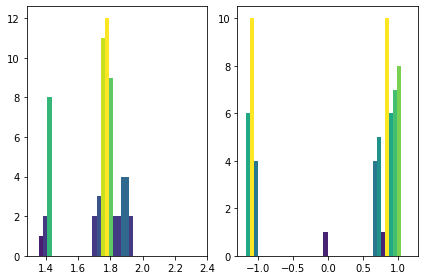

In [7]:
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter, MaxNLocator

fig, axs = plt.subplots(1, 2, tight_layout=True)

for i in range(2):
#     ax = axs[i]
    # N is the count in each bin, bins is the lower-limit of the bin
    N, bins, patches = axs[i].hist(SP_rzphi[:,i], bins=40, range=[np.min(div_RZ[:,i]), np.max(div_RZ[:,i])])
#     N, bins, patches = axs[i].hist(SP_rzphi[:len(FLT_df),i], bins=10,)
#     N, bins, patches = axs[i].hist(SP_rzphi[len(FLT_df):,i], bins=10,)

    axs[i].yaxis.set_major_locator(MaxNLocator(integer=True))
    # We'll color code by height, but you could use any scalar
    fracs = N / N.max()
    # we need to normalize the data to 0..1 for the full range of the colormap
    norm = colors.Normalize(fracs.min(), fracs.max())
    # Now, we'll loop through our objects and set the color of each accordingly
    for thisfrac, thispatch in zip(fracs, patches):
        color = plt.cm.viridis(norm(thisfrac))
        thispatch.set_facecolor(color)
    


# ax = axs[1]
# # We can also normalize our inputs by the total number of counts
# axs[1].hist(UP_SP_rzphi[:,1], bins=n_bins, density=True)

# # Now we format the y-axis to display percentage
# axs[1].yaxis.set_major_formatter(PercentFormatter(xmax=1))


<IPython.core.display.Javascript object>


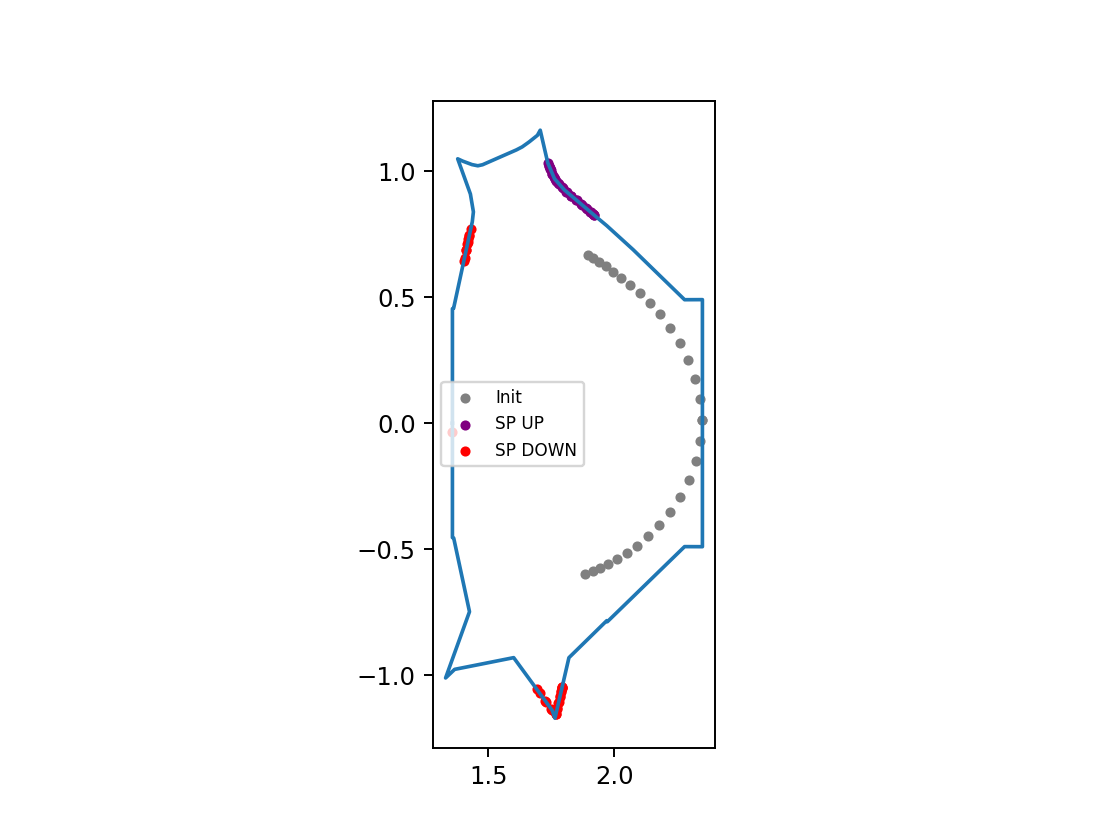

In [8]:
from ergospy.measure import divertor
import matplotlib.pyplot as plt
import numpy as np
%matplotlib notebook

fig, ax = plt.subplots(1, 1)
ax.plot(div_RZ[:,0], div_RZ[:,1])
point = np.array([1.4371,0.7983])
ax.scatter(FLT_df['Init R'],FLT_df['Init Z'], s=10, c='grey', label='Init')
ax.scatter(SP_rzphi[:len(FLT_df),0], SP_rzphi[:len(FLT_df),1], s=10, c='purple', label='SP UP')
ax.scatter(SP_rzphi[len(FLT_df):,0], SP_rzphi[len(FLT_df):,1], s=10, c='red', label='SP DOWN')
ax.set_aspect('equal')
ax.legend(loc="center left", fontsize='x-small')
plt.show()
# tile_ind, tile_mu = divertor.nearest_tile_ind_mu(point, div_edge)
# print(divertor.div_len_from_origin(tile_ind, tile_mu, div_edge))


## Potential Reference:
- [Plot an histogram with y-axis as percentage (using FuncFormatter?)](https://stackoverflow.com/questions/51473993/plot-an-histogram-with-y-axis-as-percentage-using-funcformatter)
- [Add Matplotlib Percentage Ticks to a Histogram](https://malithjayaweera.com/2018/09/add-matplotlib-percentage-ticks-histogram/)

In [ ]:
from importlib import reload
reload(ergospy.measure.FLT)
reload(ergospy.field.field_line_tracing)

In [9]:
del FLT_df

In [ ]:
from importlib import reload
reload(measure_div)

In [10]:

import ergospy.measure.divertor as measure_div
equili_SP_RZ = {
    'UP': [1.72373, 1.08829],
    'DOWN':[1.76893,-1.1537]
}
equili_SP_accu_len = {
    'UP':   measure_div.nearest_point_accu_len(equili_SP_RZ['UP'], div_RZ),
    'DOWN': measure_div.nearest_point_accu_len(equili_SP_RZ['DOWN'], div_RZ),
}


In [40]:
mark = 'HCFs'

from pathlib import Path 
path_data = Path(f'data/{mark}_{machine_name}_73999_FLD')
path_data.mkdir(exist_ok=True)


## FLTs Initiate from a Grid on Divertor near to the Original Strike Points with Perturbant Field 

In [12]:
path_RMP = path_machine / 'HCFs' / 'field' / 'uniform' 

In [34]:
nPhi = 80
start_points_rzphi = np.empty((len(r_mesh[-1,:])*nPhi, 3))
for i in range(nPhi):
    start_points_rzphi[i*len(r_mesh[-1,:]):(i+1)*len(r_mesh[-1,:]), 0] = r_mesh[-1,:]
    start_points_rzphi[i*len(r_mesh[-1,:]):(i+1)*len(r_mesh[-1,:]), 1] = z_mesh[-1,:]*(1+1e-3)
    start_points_rzphi[i*len(r_mesh[-1,:]):(i+1)*len(r_mesh[-1,:]), 2] = i / nPhi * 2*np.pi
flt_num = start_points_rzphi.shape[0]
print(f"Totally {flt_num} lines to trace.")

Totally 22960 lines to trace.


In [120]:
Dist_N, Phi_N = 150, 150 
DIR = 'UP' # 'DOWN'
Dist_shift_a = np.linspace(-6e-2, 14e-2, Dist_N) if DIR=='UP' else np.linspace(-6e-2, 2e-2, Dist_N)
Phi_a = np.linspace(0, 2*np.pi, Phi_N)
Dist_g, Phi_g = np.meshgrid(
    Dist_shift_a + equili_SP_accu_len[DIR], 
    Phi_a, indexing='ij')
R_g, Z_g = np.empty_like(Dist_g), np.empty_like(Dist_g)
#     Failed parallel code
#     vec_accu_len_to_RZ = np.vectorize(measure_div.accu_len_to_RZ)
#     vec_accu_len_to_RZ(Dist_g, div_RZ)
for i in range(Dist_N):
    R_g[i,:] = measure_div.accu_len_to_RZ(Dist_g[i,0], div_RZ)[0,None]
    Z_g[i,:] = measure_div.accu_len_to_RZ(Dist_g[i,0], div_RZ)[1,None]
start_points_rzphi = np.empty((Dist_N*Phi_N, 3))
start_points_rzphi[:,0] = R_g.flatten()
start_points_rzphi[:,1] = Z_g.flatten()
start_points_rzphi[:,2]=Phi_g.flatten()

while not np.all(div_path.contains_points(start_points_rzphi[:,0:2])):
    points_maybe_outside = div_path.contains_points(start_points_rzphi[:,0:2])#.astype(int)
    print("Let points be inside, how many outside now:", np.count_nonzero(~points_maybe_outside))
#     start_points_rzphi[~points_maybe_outside] = start_points_rzphi[~points_maybe_outside] * (1-1e-7)
    start_points_rzphi = start_points_rzphi * (1-5e-7)
flt_num = start_points_rzphi.shape[0]
print(f"Totally {flt_num} lines to trace.")


Let points be inside, how many outside now: 11250
Totally 22500 lines to trace.


In [35]:
import pandas as pd
FLT_df = pd.DataFrame(
    columns =  
    ["Len", "Min s", 
    "Init R", "Init Z", "Init Phi", 
    "Up End R", "Up End Z", "Up End Phi", 
    "Down End R", "Down End Z", "Down End Phi", 
    "Up End AOI", "Down End AOI"]) # AOI for Angle of Incidence

FLT_df['Init R'] = start_points_rzphi[:,0]
FLT_df['Init Z'] = start_points_rzphi[:,1]
FLT_df['Init Phi']=start_points_rzphi[:,2]
# FLT_df['Inint Dist'] = Dist_g.flatten()

In [36]:
FLT_df

Len Min s    Init R    Init Z  Init Phi Up End R Up End Z Up End Phi  \
0      NaN   NaN  2.276780  0.012513  0.000000      NaN      NaN        NaN   
1      NaN   NaN  2.270019  0.095375  0.000000      NaN      NaN        NaN   
2      NaN   NaN  2.252087  0.175416  0.000000      NaN      NaN        NaN   
3      NaN   NaN  2.224783  0.250315  0.000000      NaN      NaN        NaN   
4      NaN   NaN  2.190534  0.318439  0.000000      NaN      NaN        NaN   
...    ...   ...       ...       ...       ...      ...      ...        ...   
22955  NaN   NaN  2.192528 -0.293941  6.204645      NaN      NaN        NaN   
22956  NaN   NaN  2.227568 -0.225818  6.204645      NaN      NaN        NaN   
22957  NaN   NaN  2.254659 -0.150707  6.204645      NaN      NaN        NaN   
22958  NaN   NaN  2.271540 -0.070439  6.204645      NaN      NaN        NaN   
22959  NaN   NaN  2.276791  0.012513  6.204645      NaN      NaN        NaN   

      Down End R Down End Z Down End Phi Up End AOI Down End AOI  
0            NaN        NaN          NaN        NaN          NaN  
1            NaN        NaN          NaN        NaN          NaN  
2            NaN        NaN          NaN        NaN          NaN  
3            NaN        NaN          NaN        NaN          NaN  
4            NaN        NaN          NaN        NaN          NaN  
...          ...        ...          ...        ...          ...  
22955        NaN        NaN          NaN        NaN          NaN  
22956        NaN        NaN          NaN        NaN          NaN  
22957        NaN        NaN          NaN        NaN          NaN  
22958        NaN        NaN          NaN        NaN          NaN  
22959        NaN        NaN          NaN        NaN          NaN  

[22960 rows x 13 columns]

In [16]:
from ergospy.field.Field import Field3D
RMP_field_raw = 1.3* ergospy.file.FieldRead(path_RMP, xcor='RZPhi', fcor='RZPhi')
RMP_param = ergospy.file.FieldMeshRead(path_RMP, xcor='RZPhi', fcor='RZPhi')
RMP_3D = Field3D(RMP_param['R'], RMP_param['Z'], RMP_param['Phi'], RMP_field_raw[...,0], RMP_field_raw[...,1], RMP_field_raw[...,2])
B_3D = RMP_3D + EQU_2D
R,Z,Phi = B_3D.R, B_3D.Z, B_3D.Phi
BR,BZ,BPhi = B_3D.BR, B_3D.BZ, B_3D.BPhi
B = B_3D.field_mag()

# Extend [2pi-dPhi, 2pi] 
Phi = np.append(Phi, 2*np.pi+Phi[...,0:2], axis=-1)
BR = np.append(BR, BR[...,0:2], axis=-1)
BZ = np.append(BZ, BZ[...,0:2], axis=-1)
BPhi = np.append(BPhi, BPhi[...,0:2], axis=-1)
B = np.append(B, B[...,0:2], axis=-1)

print("Prepare linear B field interpolator ")
BR_interp = RegularGridInterpolator((R, Z, Phi), BR/B)
BZ_interp = RegularGridInterpolator((R, Z, Phi), BZ/B)
BPhi_interp = RegularGridInterpolator((R, Z, Phi),BPhi/B)
print("Finished linear B field interpolator ")

def field_interp(y):
    ymod = y.copy(); ymod[-1] %= (2*np.pi)
    return np.asarray([ BR_interp(ymod)[0], BZ_interp(ymod)[0], BPhi_interp(ymod)[0]/y[0] ])

# FLT_direciton, Co-field and Counter-field direction
FLT_direction = [True, False] # [False, True] if the magnetic field is counterclock when viewing the torus from the top.

Prepare linear B field interpolator 
Finished linear B field interpolator 


In [17]:
if True:
    elec_eV = 10.0 # eV
    D_perp = 1.0 # [1.0 m^2/s, 10.0 m^2/s] 
    c = 299792458.0 # m/s 

    elec_v = c * np.sqrt( 1.0 - 1.0/ (elec_eV/511e3+1.0) )
    elec_n = 1e19 # m^{-3}
    MFP = 8.5 * 1e21 * ((elec_eV/1e3) **2 / elec_n)
    kwds = {
        'mean_free_path': MFP, # unit: m,
        'diffusion_range': np.sqrt(12 * D_perp * MFP/ elec_v),
        'report_progress': True
    }
    print('elec_v ', elec_v)
    [print(key, value) for key, value in kwds.items()]

elec_v  1326190.7774935297
mean_free_path 0.085
diffusion_range 0.0008769949330032397
report_progress True


In [37]:
import progressbar, sys
from multiprocessing import Pool
from multiprocessing.sharedctypes import Value
import warnings

def FLT3D_params(*args, **kwargs):
    strmline = FLT3D(*args, **kwargs)
    up_end, down_end = FLT_endpoint(strmline)
    return {'Len':FLT_length(strmline), 
            'Min s':FLT_reach_min_s(strmline, folder_equilibrium), 
            'Up End':up_end, 'Down End':down_end}

import timeit; start_time = timeit.default_timer()
# If you want to test the parallel speedup, just add your preferred number to the Pool arg `processes`
proc_pool, proc_list = Pool(), []
flt_todo = FLT_df[FLT_df['Len'].isnull()].index
for j in flt_todo:
    proc_list.append(proc_pool.apply_async(
        FLT3D_params, 
        args=(j, start_points_rzphi[j,:], div_path, div_RZ, field_interp, True, True, 20.0e2, 4e-1),
        kwds=kwds#{'report_progress':False}
    ))
with progressbar.ProgressBar(max_value=len(flt_todo)) as bar:
    progress_num = Value('i', -1)
    for i, proc in enumerate(proc_list):
        try:
            FLT_param = proc.get()
            FLT_df.loc[i, 'Len'] = FLT_param['Len']
            FLT_df.loc[i, 'Min s'] = FLT_param['Min s']
            FLT_df.loc[i, 'Up End R'], FLT_df.loc[i, 'Up End Z'], FLT_df.loc[i, 'Up End Phi'] = FLT_param['Up End']
            FLT_df.loc[i, 'Down End R'], FLT_df.loc[i, 'Down End Z'], FLT_df.loc[i, 'Down End Phi'] = FLT_param['Down End']
        except Exception as err:
            warnings.warn(f"The {i} field line met error {err}.")
        with progress_num.get_lock():
            progress_num.value += 1
            bar.update(progress_num.value)
proc_pool.close(); proc_pool.join()
elapsed = timeit.default_timer() - start_time; print(elapsed)
print("All field line traces ODE done...")
# print(len_params_list)

The 0 field line trace + ODE ing...
The 3 field line trace + ODE ing...
The 1 field line trace + ODE ing...
The 6 field line trace + ODE ing...
The 5 field line trace + ODE ing...
The 4 field line trace + ODE ing...
The 13 field line trace + ODE ing...
The 11 field line trace + ODE ing...
The 8 field line trace + ODE ing...
The 9 field line trace + ODE ing...
The 2 field line trace + ODE ing...
The 7 field line trace + ODE ing...
The 14 field line trace + ODE ing...
The 10 field line trace + ODE ing...
The 12 field line trace + ODE ing...
The 15 field line trace + ODE ing...
The 2 field line trace + ODE out of divertor edge.
The 2 field line trace - ODE ing...
The 4 field line trace + ODE out of divertor edge.
The 4 field line trace - ODE ing...
The 6 field line trace + ODE out of divertor edge.
The 6 field line trace - ODE ing...
The 3 field line trace + ODE out of divertor edge.
The 3 field line trace - ODE ing...
The 1 field line trace + ODE out of divertor edge.
The 1 field line tr

The 49 field line trace - ODE out of divertor edge.
The 55 field line trace + ODE ing...
The 47 field line trace + ODE out of divertor edge.
The 47 field line trace - ODE ing...
The 50 field line trace - ODE out of divertor edge.
The 56 field line trace + ODE ing...
The 51 field line trace + ODE out of divertor edge.
The 51 field line trace - ODE ing...
The 10 field line trace - ODE out of divertor edge.
The 57 field line trace + ODE ing...
The 52 field line trace + ODE out of divertor edge.
The 52 field line trace - ODE ing...
The 53 field line trace + ODE out of divertor edge.
The 53 field line trace - ODE ing...
The 51 field line trace - ODE out of divertor edge.
The 58 field line trace + ODE ing...
The 52 field line trace - ODE out of divertor edge.
The 59 field line trace + ODE ing...
The 47 field line trace - ODE out of divertor edge.
The 60 field line trace + ODE ing...
The 45 field line trace + ODE out of divertor edge.
The 45 field line trace - ODE ing...
The 53 field line tra

The 95 field line trace - ODE ing...
The 94 field line trace + ODE out of divertor edge.
The 94 field line trace - ODE ing...
The 96 field line trace + ODE out of divertor edge.
The 96 field line trace - ODE ing...
The 75 field line trace + ODE out of divertor edge.
The 75 field line trace - ODE ing...
The 95 field line trace - ODE out of divertor edge.
The 102 field line trace + ODE ing...
The 97 field line trace + ODE out of divertor edge.
The 97 field line trace - ODE ing...
The 94 field line trace - ODE out of divertor edge.
The 103 field line trace + ODE ing...
The 75 field line trace - ODE out of divertor edge.
The 96 field line trace - ODE out of divertor edge.
The 104 field line trace + ODE ing...
The 105 field line trace + ODE ing...
The 97 field line trace - ODE out of divertor edge.
The 106 field line trace + ODE ing...
The 100 field line trace + ODE out of divertor edge.
The 100 field line trace - ODE ing...
The 99 field line trace + ODE out of divertor edge.
The 99 field l

N/A% (0 of 22960) |                      | Elapsed Time: 0:00:00 ETA:  --:--:--

The 121 field line trace + ODE ing...
The 14 field line trace - ODE finished within finite time...


  0% (14 of 22960) |                     | Elapsed Time: 0:00:00 ETA:   0:14:27

The 122 field line trace + ODE ing...
The 111 field line trace - ODE out of divertor edge.
The 123 field line trace + ODE ing...
The 116 field line trace - ODE out of divertor edge.
The 124 field line trace + ODE ing...
The 113 field line trace - ODE out of divertor edge.
The 125 field line trace + ODE ing...
The 117 field line trace + ODE out of divertor edge.
The 117 field line trace - ODE ing...
The 118 field line trace + ODE out of divertor edge.
The 118 field line trace - ODE ing...
The 119 field line trace + ODE out of divertor edge.
The 119 field line trace - ODE ing...
The 121 field line trace + ODE out of divertor edge.
The 121 field line trace - ODE ing...
The 120 field line trace + ODE out of divertor edge.
The 120 field line trace - ODE ing...
The 118 field line trace - ODE out of divertor edge.
The 117 field line trace - ODE out of divertor edge.
The 126 field line trace + ODE ing...
The 127 field line trace + ODE ing...
The 123 field line trace + ODE out of divertor edge.

  0% (61 of 22960) |                     | Elapsed Time: 0:00:28 ETA:   3:47:31

The 120 field line trace - ODE out of divertor edge.


  0% (75 of 22960) |                     | Elapsed Time: 0:00:28 ETA:   2:55:51

The 131 field line trace + ODE ing...
The 123 field line trace - ODE out of divertor edge.
The 132 field line trace + ODE ing...
The 124 field line trace - ODE out of divertor edge.
The 133 field line trace + ODE ing...
The 114 field line trace - ODE out of divertor edge.
The 134 field line trace + ODE ing...
The 107 field line trace + ODE out of divertor edge.
The 107 field line trace - ODE ing...
The 126 field line trace + ODE out of divertor edge.
The 126 field line trace - ODE ing...
The 134 field line trace + ODE out of divertor edge.
The 134 field line trace - ODE ing...
The 127 field line trace + ODE out of divertor edge.
The 127 field line trace - ODE ing...
The 107 field line trace - ODE out of divertor edge.
The 135 field line trace + ODE ing...
The 125 field line trace + ODE out of divertor edge.
The 125 field line trace - ODE ing...
The 130 field line trace + ODE out of divertor edge.
The 130 field line trace - ODE ing...
The 126 field line trace - ODE out of divertor edge.

  0% (82 of 22960) |              | Elapsed Time: 0:03:33 ETA:  7 days, 0:10:10

The 164 field line trace + ODE ing...


  0% (90 of 22960) |              | Elapsed Time: 0:03:34 ETA:  3 days, 6:30:08

The 141 field line trace - ODE out of divertor edge.
The 165 field line trace + ODE ing...
The 157 field line trace + ODE out of divertor edge.
The 157 field line trace - ODE ing...
The 164 field line trace + ODE out of divertor edge.
The 164 field line trace - ODE ing...
The 165 field line trace + ODE out of divertor edge.
The 165 field line trace - ODE ing...
The 161 field line trace - ODE out of divertor edge.
The 166 field line trace + ODE ing...
The 165 field line trace - ODE out of divertor edge.
The 167 field line trace + ODE ing...
The 104 field line trace - ODE finished within finite time...
The 168 field line trace + ODE ing...
The 98 field line trace - ODE finished within finite time...


  0% (98 of 22960) |              | Elapsed Time: 0:04:41 ETA:  2 days, 5:37:14

The 169 field line trace + ODE ing...
The 166 field line trace + ODE out of divertor edge.
The 166 field line trace - ODE ing...
The 167 field line trace + ODE out of divertor edge.
The 167 field line trace - ODE ing...
The 112 field line trace - ODE finished within finite time...


  0% (112 of 22960) |                    | Elapsed Time: 0:04:57 ETA:   7:22:06

The 170 field line trace + ODE ing...


  0% (122 of 22960) |                    | Elapsed Time: 0:04:57 ETA:   4:19:26

The 169 field line trace + ODE out of divertor edge.
The 169 field line trace - ODE ing...
The 168 field line trace + ODE out of divertor edge.
The 168 field line trace - ODE ing...
The 167 field line trace - ODE out of divertor edge.
The 171 field line trace + ODE ing...
The 170 field line trace + ODE out of divertor edge.
The 170 field line trace - ODE ing...
The 169 field line trace - ODE out of divertor edge.
The 172 field line trace + ODE ing...
The 171 field line trace + ODE out of divertor edge.
The 171 field line trace - ODE ing...
The 172 field line trace + ODE out of divertor edge.
The 172 field line trace - ODE ing...
The 149 field line trace - ODE finished within finite time...
The 173 field line trace + ODE ing...
The 145 field line trace - ODE finished within finite time...
The 174 field line trace + ODE ing...
The 152 field line trace - ODE finished within finite time...
The 175 field line trace + ODE ing...
The 131 field line trace - ODE finished within finite time...
T

  0% (152 of 22960) |              | Elapsed Time: 0:07:31 ETA:  1 day, 8:22:33

The 156 field line trace - ODE finished within finite time...
The 177 field line trace + ODE ing...
The 172 field line trace - ODE out of divertor edge.
The 178 field line trace + ODE ing...
The 174 field line trace + ODE out of divertor edge.
The 174 field line trace - ODE ing...
The 175 field line trace + ODE out of divertor edge.
The 175 field line trace - ODE ing...
The 153 field line trace - ODE finished within finite time...


  0% (153 of 22960) |             | Elapsed Time: 0:07:51 ETA:  5 days, 5:46:42

The 179 field line trace + ODE ing...
The 177 field line trace + ODE out of divertor edge.
The 177 field line trace - ODE ing...
The 176 field line trace + ODE out of divertor edge.
The 176 field line trace - ODE ing...
The 173 field line trace + ODE out of divertor edge.
The 173 field line trace - ODE ing...
The 174 field line trace - ODE out of divertor edge.
The 180 field line trace + ODE ing...
The 178 field line trace + ODE out of divertor edge.
The 178 field line trace - ODE ing...
The 180 field line trace + ODE out of divertor edge.
The 180 field line trace - ODE ing...
The 175 field line trace - ODE out of divertor edge.
The 181 field line trace + ODE ing...
The 176 field line trace - ODE out of divertor edge.
The 182 field line trace + ODE ing...
The 159 field line trace - ODE finished within finite time...
The 183 field line trace + ODE ing...
The 179 field line trace + ODE out of divertor edge.
The 179 field line trace - ODE ing...
The 181 field line trace + ODE out of diver

  0% (157 of 22960) |            | Elapsed Time: 0:09:18 ETA:  5 days, 17:57:13

The 164 field line trace - ODE finished within finite time...
The 192 field line trace + ODE ing...


  0% (164 of 22960) |             | Elapsed Time: 0:09:19 ETA:  2 days, 2:59:46

The 184 field line trace + ODE out of divertor edge.
The 184 field line trace - ODE ing...
The 192 field line trace + ODE out of divertor edge.
The 192 field line trace - ODE ing...
The 191 field line trace + ODE out of divertor edge.
The 191 field line trace - ODE ing...
The 192 field line trace - ODE out of divertor edge.
The 193 field line trace + ODE ing...
The 191 field line trace - ODE out of divertor edge.
The 194 field line trace + ODE ing...
The 193 field line trace + ODE out of divertor edge.
The 193 field line trace - ODE ing...
The 166 field line trace - ODE finished within finite time...


  0% (166 of 22960) |            | Elapsed Time: 0:10:08 ETA:  6 days, 10:48:17

The 195 field line trace + ODE ing...
The 189 field line trace - ODE out of divertor edge.
The 196 field line trace + ODE ing...
The 194 field line trace + ODE out of divertor edge.
The 194 field line trace - ODE ing...
The 193 field line trace - ODE out of divertor edge.
The 197 field line trace + ODE ing...
The 168 field line trace - ODE finished within finite time...
The 198 field line trace + ODE ing...


  0% (168 of 22960) |             | Elapsed Time: 0:10:21 ETA:  1 day, 17:31:20

The 196 field line trace + ODE out of divertor edge.
The 196 field line trace - ODE ing...
The 194 field line trace - ODE out of divertor edge.
The 199 field line trace + ODE ing...
The 197 field line trace + ODE out of divertor edge.
The 197 field line trace - ODE ing...
The 198 field line trace + ODE out of divertor edge.
The 198 field line trace - ODE ing...
The 170 field line trace - ODE finished within finite time...
The 200 field line trace + ODE ing...


  0% (170 of 22960) |            | Elapsed Time: 0:10:50 ETA:  3 days, 18:10:21

The 171 field line trace - ODE finished within finite time...


  0% (171 of 22960) |                    | Elapsed Time: 0:10:53 ETA:  23:09:44

The 201 field line trace + ODE ing...
The 197 field line trace - ODE out of divertor edge.
The 202 field line trace + ODE ing...
The 190 field line trace + ODE out of divertor edge.
The 190 field line trace - ODE ing...
The 200 field line trace + ODE out of divertor edge.
The 200 field line trace - ODE ing...
The 199 field line trace + ODE out of divertor edge.
The 199 field line trace - ODE ing...
The 201 field line trace + ODE out of divertor edge.
The 201 field line trace - ODE ing...
The 202 field line trace + ODE out of divertor edge.
The 202 field line trace - ODE ing...
The 199 field line trace - ODE out of divertor edge.
The 203 field line trace + ODE ing...
The 202 field line trace - ODE out of divertor edge.
The 204 field line trace + ODE ing...
The 187 field line trace - ODE out of divertor edge.
The 205 field line trace + ODE ing...
The 204 field line trace + ODE out of divertor edge.
The 204 field line trace - ODE ing...
The 177 field line trace - ODE finished within finit

  0% (173 of 22960) |           | Elapsed Time: 0:13:15 ETA:  18 days, 15:30:13

The 195 field line trace + ODE out of divertor edge.
The 195 field line trace - ODE ing...
The 207 field line trace + ODE out of divertor edge.
The 207 field line trace - ODE ing...
The 180 field line trace - ODE finished within finite time...


  0% (180 of 22960) |                    | Elapsed Time: 0:13:22 ETA:   6:25:45

The 208 field line trace + ODE ing...
The 203 field line trace + ODE out of divertor edge.
The 203 field line trace - ODE ing...
The 206 field line trace + ODE out of divertor edge.
The 206 field line trace - ODE ing...
The 205 field line trace - ODE out of divertor edge.
The 209 field line trace + ODE ing...
The 208 field line trace + ODE out of divertor edge.
The 208 field line trace - ODE ing...
The 207 field line trace - ODE out of divertor edge.
The 210 field line trace + ODE ing...
The 209 field line trace + ODE out of divertor edge.
The 209 field line trace - ODE ing...
The 208 field line trace - ODE out of divertor edge.
The 211 field line trace + ODE ing...
The 210 field line trace + ODE out of divertor edge.
The 210 field line trace - ODE ing...
The 211 field line trace + ODE out of divertor edge.
The 211 field line trace - ODE ing...
The 186 field line trace - ODE finished within finite time...
The 212 field line trace + ODE ing...
The 188 field line trace - ODE finished wit

  0% (184 of 22960) |            | Elapsed Time: 0:14:53 ETA:  5 days, 23:26:26

The 216 field line trace + ODE ing...
The 212 field line trace + ODE out of divertor edge.
The 212 field line trace - ODE ing...
The 216 field line trace + ODE out of divertor edge.
The 216 field line trace - ODE ing...
The 215 field line trace + ODE out of divertor edge.
The 215 field line trace - ODE ing...
The 214 field line trace + ODE out of divertor edge.
The 214 field line trace - ODE ing...
The 196 field line trace - ODE finished within finite time...
The 217 field line trace + ODE ing...
The 198 field line trace - ODE finished within finite time...
The 218 field line trace + ODE ing...
The 217 field line trace + ODE out of divertor edge.
The 217 field line trace - ODE ing...
The 218 field line trace + ODE out of divertor edge.
The 218 field line trace - ODE ing...
The 190 field line trace - ODE finished within finite time...
The 201 field line trace - ODE finished within finite time...


  0% (190 of 22960) |            | Elapsed Time: 0:16:42 ETA:  4 days, 19:42:45

The 219 field line trace + ODE ing...
The 220 field line trace + ODE ing...
The 200 field line trace - ODE finished within finite time...
The 221 field line trace + ODE ing...
The 221 field line trace + ODE out of divertor edge.
The 221 field line trace - ODE ing...
The 219 field line trace + ODE out of divertor edge.
The 219 field line trace - ODE ing...
The 204 field line trace - ODE finished within finite time...
The 222 field line trace + ODE ing...
The 220 field line trace + ODE out of divertor edge.
The 220 field line trace - ODE ing...
The 222 field line trace + ODE out of divertor edge.
The 222 field line trace - ODE ing...
The 222 field line trace - ODE out of divertor edge.
The 223 field line trace + ODE ing...
The 195 field line trace - ODE finished within finite time...


  0% (195 of 22960) |             | Elapsed Time: 0:18:43 ETA:  6 days, 8:11:38

The 224 field line trace + ODE ing...
The 224 field line trace + ODE out of divertor edge.
The 224 field line trace - ODE ing...
The 203 field line trace - ODE finished within finite time...


  0% (203 of 22960) |                    | Elapsed Time: 0:18:54 ETA:   9:20:20

The 225 field line trace + ODE ing...
The 223 field line trace + ODE out of divertor edge.
The 223 field line trace - ODE ing...
The 206 field line trace - ODE finished within finite time...


  0% (206 of 22960) |                    | Elapsed Time: 0:19:03 ETA:  17:59:19

The 226 field line trace + ODE ing...
The 224 field line trace - ODE out of divertor edge.
The 227 field line trace + ODE ing...
The 227 field line trace + ODE out of divertor edge.
The 227 field line trace - ODE ing...
The 209 field line trace - ODE finished within finite time...


  0% (209 of 22960) |            | Elapsed Time: 0:19:36 ETA:  2 days, 21:12:16

The 228 field line trace + ODE ing...
The 227 field line trace - ODE out of divertor edge.
The 229 field line trace + ODE ing...
The 225 field line trace + ODE out of divertor edge.
The 225 field line trace - ODE ing...
The 226 field line trace + ODE out of divertor edge.
The 226 field line trace - ODE ing...
The 220 field line trace - ODE out of divertor edge.
The 230 field line trace + ODE ing...
The 210 field line trace - ODE finished within finite time...
The 231 field line trace + ODE ing...


  0% (210 of 22960) |            | Elapsed Time: 0:20:05 ETA:  7 days, 18:19:41

The 226 field line trace - ODE out of divertor edge.
The 232 field line trace + ODE ing...
The 229 field line trace + ODE out of divertor edge.
The 229 field line trace - ODE ing...
The 213 field line trace - ODE finished within finite time...
The 233 field line trace + ODE ing...
The 230 field line trace + ODE out of divertor edge.
The 230 field line trace - ODE ing...
The 212 field line trace - ODE finished within finite time...


  0% (212 of 22960) |             | Elapsed Time: 0:20:23 ETA:  2 days, 8:23:55

The 234 field line trace + ODE ing...
The 231 field line trace + ODE out of divertor edge.
The 231 field line trace - ODE ing...
The 216 field line trace - ODE finished within finite time...
The 235 field line trace + ODE ing...
The 215 field line trace - ODE finished within finite time...
The 236 field line trace + ODE ing...
The 214 field line trace - ODE finished within finite time...


  0% (214 of 22960) |             | Elapsed Time: 0:20:39 ETA:  2 days, 3:17:48

The 237 field line trace + ODE ing...
The 234 field line trace + ODE out of divertor edge.
The 234 field line trace - ODE ing...
The 233 field line trace + ODE out of divertor edge.
The 233 field line trace - ODE ing...
The 236 field line trace + ODE out of divertor edge.
The 236 field line trace - ODE ing...
The 237 field line trace + ODE out of divertor edge.
The 237 field line trace - ODE ing...
The 233 field line trace - ODE out of divertor edge.
The 238 field line trace + ODE ing...
The 232 field line trace + ODE out of divertor edge.
The 232 field line trace - ODE ing...
The 236 field line trace - ODE out of divertor edge.
The 239 field line trace + ODE ing...
The 239 field line trace + ODE out of divertor edge.
The 239 field line trace - ODE ing...
The 228 field line trace + ODE out of divertor edge.
The 228 field line trace - ODE ing...
The 235 field line trace + ODE out of divertor edge.
The 235 field line trace - ODE ing...
The 217 field line trace - ODE finished within finit

  0% (217 of 22960) |            | Elapsed Time: 0:21:53 ETA:  6 days, 10:59:28

The 240 field line trace + ODE out of divertor edge.
The 240 field line trace - ODE ing...
The 218 field line trace - ODE finished within finite time...


  0% (218 of 22960) |             | Elapsed Time: 0:22:02 ETA:  2 days, 6:40:22

The 241 field line trace + ODE ing...
The 231 field line trace - ODE out of divertor edge.
The 242 field line trace + ODE ing...
The 241 field line trace + ODE out of divertor edge.
The 241 field line trace - ODE ing...
The 240 field line trace - ODE out of divertor edge.
The 243 field line trace + ODE ing...
The 219 field line trace - ODE finished within finite time...
The 244 field line trace + ODE ing...


  0% (219 of 22960) |             | Elapsed Time: 0:22:22 ETA:  5 days, 7:33:36

The 221 field line trace - ODE finished within finite time...


  0% (221 of 22960) |                    | Elapsed Time: 0:22:24 ETA:   8:03:16

The 245 field line trace + ODE ing...
The 242 field line trace + ODE out of divertor edge.
The 242 field line trace - ODE ing...
The 234 field line trace - ODE out of divertor edge.
The 243 field line trace + ODE out of divertor edge.
The 243 field line trace - ODE ing...
The 246 field line trace + ODE ing...
The 235 field line trace - ODE out of divertor edge.
The 247 field line trace + ODE ing...
The 247 field line trace + ODE out of divertor edge.
The 247 field line trace - ODE ing...
The 245 field line trace + ODE out of divertor edge.
The 245 field line trace - ODE ing...
The 238 field line trace + ODE out of divertor edge.
The 238 field line trace - ODE ing...
The 242 field line trace - ODE out of divertor edge.
The 248 field line trace + ODE ing...
The 246 field line trace + ODE out of divertor edge.
The 246 field line trace - ODE ing...
The 244 field line trace + ODE out of divertor edge.
The 244 field line trace - ODE ing...
The 248 field line trace + ODE out of divertor edge.

  0% (223 of 22960) |            | Elapsed Time: 0:24:20 ETA:  15 days, 5:30:16

The 250 field line trace + ODE ing...
The 249 field line trace + ODE out of divertor edge.
The 249 field line trace - ODE ing...
The 225 field line trace - ODE finished within finite time...


  0% (225 of 22960) |             | Elapsed Time: 0:25:08 ETA:  6 days, 7:59:44

The 251 field line trace + ODE ing...
The 250 field line trace + ODE out of divertor edge.
The 250 field line trace - ODE ing...
The 251 field line trace + ODE out of divertor edge.
The 251 field line trace - ODE ing...
The 229 field line trace - ODE finished within finite time...
The 252 field line trace + ODE ing...
The 230 field line trace - ODE finished within finite time...
The 253 field line trace + ODE ing...
The 237 field line trace - ODE finished within finite time...
The 254 field line trace + ODE ing...
The 252 field line trace + ODE out of divertor edge.
The 252 field line trace - ODE ing...
The 232 field line trace - ODE finished within finite time...
The 255 field line trace + ODE ing...
The 253 field line trace + ODE out of divertor edge.
The 253 field line trace - ODE ing...
The 254 field line trace + ODE out of divertor edge.
The 254 field line trace - ODE ing...
The 253 field line trace - ODE out of divertor edge.
The 256 field line trace + ODE ing...
The 239 field li

  0% (228 of 22960) |           | Elapsed Time: 0:27:10 ETA:  10 days, 17:02:34

The 257 field line trace + ODE out of divertor edge.
The 257 field line trace - ODE ing...
The 241 field line trace - ODE finished within finite time...
The 259 field line trace + ODE ing...
The 258 field line trace + ODE out of divertor edge.
The 258 field line trace - ODE ing...
The 259 field line trace + ODE out of divertor edge.
The 259 field line trace - ODE ing...
The 258 field line trace - ODE out of divertor edge.
The 260 field line trace + ODE ing...
The 254 field line trace - ODE out of divertor edge.
The 261 field line trace + ODE ing...
The 243 field line trace - ODE finished within finite time...
The 262 field line trace + ODE ing...
The 251 field line trace - ODE out of divertor edge.
The 263 field line trace + ODE ing...
The 238 field line trace - ODE finished within finite time...
The 264 field line trace + ODE ing...


  1% (238 of 22960) |             | Elapsed Time: 0:28:11 ETA:  1 day, 14:05:23

The 245 field line trace - ODE finished within finite time...


  1% (245 of 22960) |                    | Elapsed Time: 0:28:13 ETA:   2:12:05

The 265 field line trace + ODE ing...
The 247 field line trace - ODE finished within finite time...
The 266 field line trace + ODE ing...
The 261 field line trace + ODE out of divertor edge.
The 261 field line trace - ODE ing...
The 246 field line trace - ODE finished within finite time...
The 260 field line trace + ODE out of divertor edge.
The 260 field line trace - ODE ing...
The 267 field line trace + ODE ing...


  1% (246 of 22960) |            | Elapsed Time: 0:28:24 ETA:  2 days, 17:11:22

The 265 field line trace + ODE out of divertor edge.
The 265 field line trace - ODE ing...
The 266 field line trace + ODE out of divertor edge.
The 266 field line trace - ODE ing...
The 263 field line trace + ODE out of divertor edge.
The 263 field line trace - ODE ing...
The 264 field line trace + ODE out of divertor edge.
The 264 field line trace - ODE ing...
The 266 field line trace - ODE out of divertor edge.
The 268 field line trace + ODE ing...
The 261 field line trace - ODE out of divertor edge.
The 269 field line trace + ODE ing...
The 264 field line trace - ODE out of divertor edge.
The 270 field line trace + ODE ing...
The 267 field line trace + ODE out of divertor edge.
The 267 field line trace - ODE ing...
The 268 field line trace + ODE out of divertor edge.
The 268 field line trace - ODE ing...
The 248 field line trace - ODE finished within finite time...
The 271 field line trace + ODE ing...


  1% (248 of 22960) |             | Elapsed Time: 0:28:55 ETA:  4 days, 4:19:00

The 268 field line trace - ODE out of divertor edge.
The 260 field line trace - ODE out of divertor edge.
The 272 field line trace + ODE ing...
The 273 field line trace + ODE ing...
The 270 field line trace + ODE out of divertor edge.
The 270 field line trace - ODE ing...
The 269 field line trace + ODE out of divertor edge.
The 269 field line trace - ODE ing...
The 272 field line trace + ODE out of divertor edge.
The 272 field line trace - ODE ing...
The 267 field line trace - ODE out of divertor edge.
The 274 field line trace + ODE ing...
The 274 field line trace + ODE out of divertor edge.
The 274 field line trace - ODE ing...
The 262 field line trace + ODE out of divertor edge.
The 262 field line trace - ODE ing...
The 271 field line trace + ODE out of divertor edge.
The 271 field line trace - ODE ing...
The 271 field line trace - ODE out of divertor edge.
The 275 field line trace + ODE ing...
The 273 field line trace + ODE out of divertor edge.
The 273 field line trace - ODE ing...

  1% (249 of 22960) |            | Elapsed Time: 0:30:23 ETA:  23 days, 1:02:10

The 276 field line trace + ODE ing...
The 275 field line trace + ODE out of divertor edge.
The 275 field line trace - ODE ing...
The 276 field line trace + ODE out of divertor edge.
The 276 field line trace - ODE ing...
The 250 field line trace - ODE finished within finite time...


  1% (250 of 22960) |             | Elapsed Time: 0:30:43 ETA:  5 days, 4:16:31

The 277 field line trace + ODE ing...
The 277 field line trace + ODE out of divertor edge.
The 277 field line trace - ODE ing...
The 252 field line trace - ODE finished within finite time...


  1% (252 of 22960) |             | Elapsed Time: 0:31:53 ETA:  9 days, 7:07:33

The 278 field line trace + ODE ing...
The 278 field line trace + ODE out of divertor edge.
The 278 field line trace - ODE ing...
The 255 field line trace - ODE finished within finite time...


  1% (255 of 22960) |            | Elapsed Time: 0:32:26 ETA:  2 days, 20:19:21

The 279 field line trace + ODE ing...
The 256 field line trace - ODE finished within finite time...


  1% (256 of 22960) |              | Elapsed Time: 0:32:31 ETA:  1 day, 7:22:18

The 280 field line trace + ODE ing...
The 279 field line trace + ODE out of divertor edge.
The 279 field line trace - ODE ing...
The 280 field line trace + ODE out of divertor edge.
The 280 field line trace - ODE ing...
The 279 field line trace - ODE out of divertor edge.
The 281 field line trace + ODE ing...
The 257 field line trace - ODE finished within finite time...
The 282 field line trace + ODE ing...


  1% (257 of 22960) |            | Elapsed Time: 0:32:50 ETA:  4 days, 23:26:01

The 280 field line trace - ODE out of divertor edge.
The 283 field line trace + ODE ing...
The 282 field line trace + ODE out of divertor edge.
The 282 field line trace - ODE ing...
The 283 field line trace + ODE out of divertor edge.
The 283 field line trace - ODE ing...
The 282 field line trace - ODE out of divertor edge.
The 284 field line trace + ODE ing...
The 259 field line trace - ODE finished within finite time...
The 285 field line trace + ODE ing...


  1% (259 of 22960) |            | Elapsed Time: 0:33:25 ETA:  4 days, 14:06:46

The 284 field line trace + ODE out of divertor edge.
The 284 field line trace - ODE ing...
The 281 field line trace + ODE out of divertor edge.
The 281 field line trace - ODE ing...
The 281 field line trace - ODE out of divertor edge.
The 286 field line trace + ODE ing...
The 286 field line trace + ODE out of divertor edge.
The 286 field line trace - ODE ing...
The 265 field line trace - ODE finished within finite time...
The 287 field line trace + ODE ing...
The 263 field line trace - ODE finished within finite time...
The 288 field line trace + ODE ing...
The 288 field line trace + ODE out of divertor edge.
The 288 field line trace - ODE ing...
The 285 field line trace + ODE out of divertor edge.
The 285 field line trace - ODE ing...
The 287 field line trace + ODE out of divertor edge.
The 287 field line trace - ODE ing...
The 272 field line trace - ODE finished within finite time...
The 289 field line trace + ODE ing...
The 270 field line trace - ODE finished within finite time...
T

  1% (262 of 22960) |             | Elapsed Time: 0:35:08 ETA:  9 days, 1:35:05

The 295 field line trace + ODE ing...
The 292 field line trace - ODE out of divertor edge.
The 296 field line trace + ODE ing...
The 293 field line trace + ODE out of divertor edge.
The 293 field line trace - ODE ing...
The 293 field line trace - ODE out of divertor edge.
The 297 field line trace + ODE ing...
The 294 field line trace + ODE out of divertor edge.
The 294 field line trace - ODE ing...
The 295 field line trace + ODE out of divertor edge.
The 295 field line trace - ODE ing...
The 273 field line trace - ODE finished within finite time...


  1% (273 of 22960) |                    | Elapsed Time: 0:35:23 ETA:   8:23:22

The 298 field line trace + ODE ing...
The 296 field line trace + ODE out of divertor edge.
The 296 field line trace - ODE ing...
The 295 field line trace - ODE out of divertor edge.
The 299 field line trace + ODE ing...
The 296 field line trace - ODE out of divertor edge.
The 300 field line trace + ODE ing...
The 297 field line trace + ODE out of divertor edge.
The 297 field line trace - ODE ing...
The 298 field line trace + ODE out of divertor edge.
The 298 field line trace - ODE ing...
The 297 field line trace - ODE out of divertor edge.
The 301 field line trace + ODE ing...
The 298 field line trace - ODE out of divertor edge.
The 302 field line trace + ODE ing...
The 299 field line trace + ODE out of divertor edge.
The 299 field line trace - ODE ing...
The 300 field line trace + ODE out of divertor edge.
The 300 field line trace - ODE ing...
The 299 field line trace - ODE out of divertor edge.
The 303 field line trace + ODE ing...
The 300 field line trace - ODE out of divertor edge.

  1% (275 of 22960) |            | Elapsed Time: 0:35:59 ETA:  4 days, 18:11:36

The 306 field line trace + ODE ing...
The 302 field line trace - ODE out of divertor edge.
The 307 field line trace + ODE ing...
The 304 field line trace + ODE out of divertor edge.
The 304 field line trace - ODE ing...
The 304 field line trace - ODE out of divertor edge.
The 308 field line trace + ODE ing...
The 287 field line trace - ODE out of divertor edge.
The 309 field line trace + ODE ing...
The 306 field line trace + ODE out of divertor edge.
The 306 field line trace - ODE ing...
The 307 field line trace + ODE out of divertor edge.
The 307 field line trace - ODE ing...
The 305 field line trace + ODE out of divertor edge.
The 305 field line trace - ODE ing...
The 303 field line trace + ODE out of divertor edge.
The 303 field line trace - ODE ing...
The 306 field line trace - ODE out of divertor edge.
The 310 field line trace + ODE ing...
The 307 field line trace - ODE out of divertor edge.
The 311 field line trace + ODE ing...
The 308 field line trace + ODE out of divertor edge.

  1% (277 of 22960) |             | Elapsed Time: 0:36:24 ETA:  3 days, 6:31:32

The 314 field line trace + ODE ing...
The 309 field line trace + ODE out of divertor edge.
The 309 field line trace - ODE ing...
The 301 field line trace - ODE out of divertor edge.
The 308 field line trace - ODE out of divertor edge.
The 315 field line trace + ODE ing...
The 316 field line trace + ODE ing...
The 309 field line trace - ODE out of divertor edge.
The 317 field line trace + ODE ing...
The 310 field line trace + ODE out of divertor edge.
The 310 field line trace - ODE ing...
The 312 field line trace + ODE out of divertor edge.
The 312 field line trace - ODE ing...
The 311 field line trace + ODE out of divertor edge.
The 311 field line trace - ODE ing...
The 310 field line trace - ODE out of divertor edge.
The 318 field line trace + ODE ing...
The 316 field line trace + ODE out of divertor edge.
The 316 field line trace - ODE ing...
The 312 field line trace - ODE out of divertor edge.
The 319 field line trace + ODE ing...
The 311 field line trace - ODE out of divertor edge.

  1% (278 of 22960) |            | Elapsed Time: 0:37:45 ETA:  21 days, 3:47:15

The 333 field line trace + ODE out of divertor edge.
The 333 field line trace - ODE ing...
The 331 field line trace - ODE out of divertor edge.
The 337 field line trace + ODE ing...
The 332 field line trace + ODE out of divertor edge.
The 332 field line trace - ODE ing...
The 334 field line trace + ODE out of divertor edge.
The 334 field line trace - ODE ing...
The 330 field line trace + ODE out of divertor edge.
The 330 field line trace - ODE ing...
The 324 field line trace + ODE out of divertor edge.
The 324 field line trace - ODE ing...
The 335 field line trace + ODE out of divertor edge.
The 335 field line trace - ODE ing...
The 332 field line trace - ODE out of divertor edge.
The 338 field line trace + ODE ing...
The 334 field line trace - ODE out of divertor edge.
The 330 field line trace - ODE out of divertor edge.
The 339 field line trace + ODE ing...
The 340 field line trace + ODE ing...
The 333 field line trace - ODE out of divertor edge.
The 341 field line trace + ODE ing...

  1% (283 of 22960) |             | Elapsed Time: 0:38:43 ETA:  3 days, 1:05:37

The 356 field line trace + ODE ing...
The 350 field line trace + ODE out of divertor edge.
The 350 field line trace - ODE ing...
The 349 field line trace - ODE out of divertor edge.
The 357 field line trace + ODE ing...
The 284 field line trace - ODE finished within finite time...


  1% (284 of 22960) |             | Elapsed Time: 0:38:50 ETA:  1 day, 19:19:29

The 358 field line trace + ODE ing...
The 351 field line trace + ODE out of divertor edge.
The 351 field line trace - ODE ing...
The 352 field line trace + ODE out of divertor edge.
The 352 field line trace - ODE ing...
The 350 field line trace - ODE out of divertor edge.
The 359 field line trace + ODE ing...
The 351 field line trace - ODE out of divertor edge.
The 360 field line trace + ODE ing...
The 352 field line trace - ODE out of divertor edge.
The 361 field line trace + ODE ing...
The 354 field line trace + ODE out of divertor edge.
The 354 field line trace - ODE ing...
The 356 field line trace + ODE out of divertor edge.
The 356 field line trace - ODE ing...
The 355 field line trace + ODE out of divertor edge.
The 355 field line trace - ODE ing...
The 354 field line trace - ODE out of divertor edge.
The 362 field line trace + ODE ing...
The 356 field line trace - ODE out of divertor edge.
The 363 field line trace + ODE ing...
The 355 field line trace - ODE out of divertor edge.

  1% (285 of 22960) |            | Elapsed Time: 0:39:47 ETA:  15 days, 3:12:37

The 369 field line trace + ODE out of divertor edge.
The 369 field line trace - ODE ing...
The 371 field line trace + ODE out of divertor edge.
The 371 field line trace - ODE ing...
The 370 field line trace - ODE out of divertor edge.
The 380 field line trace + ODE ing...
The 372 field line trace + ODE out of divertor edge.
The 372 field line trace - ODE ing...
The 369 field line trace - ODE out of divertor edge.
The 373 field line trace + ODE out of divertor edge.
The 373 field line trace - ODE ing...
The 381 field line trace + ODE ing...
The 371 field line trace - ODE out of divertor edge.
The 382 field line trace + ODE ing...
The 357 field line trace + ODE out of divertor edge.
The 357 field line trace - ODE ing...
The 373 field line trace - ODE out of divertor edge.
The 383 field line trace + ODE ing...
The 372 field line trace - ODE out of divertor edge.
The 384 field line trace + ODE ing...
The 375 field line trace + ODE out of divertor edge.
The 375 field line trace - ODE ing...

  1% (289 of 22960) |             | Elapsed Time: 0:40:15 ETA:  1 day, 20:22:21

The 391 field line trace + ODE ing...
The 379 field line trace + ODE out of divertor edge.
The 379 field line trace - ODE ing...
The 384 field line trace + ODE out of divertor edge.
The 384 field line trace - ODE ing...
The 381 field line trace - ODE out of divertor edge.
The 392 field line trace + ODE ing...
The 386 field line trace + ODE out of divertor edge.
The 386 field line trace - ODE ing...
The 378 field line trace + ODE out of divertor edge.
The 378 field line trace - ODE ing...
The 383 field line trace + ODE out of divertor edge.
The 383 field line trace - ODE ing...
The 379 field line trace - ODE out of divertor edge.
The 380 field line trace + ODE out of divertor edge.
The 380 field line trace - ODE ing...
The 393 field line trace + ODE ing...
The 384 field line trace - ODE out of divertor edge.
The 394 field line trace + ODE ing...
The 378 field line trace - ODE out of divertor edge.
The 386 field line trace - ODE out of divertor edge.
The 395 field line trace + ODE ing...

  1% (308 of 22960) |                    | Elapsed Time: 0:40:51 ETA:  11:38:56

The 374 field line trace + ODE out of divertor edge.


  1% (317 of 22960) |                    | Elapsed Time: 0:40:51 ETA:   7:55:27

The 374 field line trace - ODE ing...


  1% (327 of 22960) |                    | Elapsed Time: 0:40:51 ETA:   5:51:20

The 397 field line trace + ODE out of divertor edge.
The 397 field line trace - ODE ing...
The 395 field line trace - ODE out of divertor edge.
The 403 field line trace + ODE ing...
The 388 field line trace - ODE out of divertor edge.
The 404 field line trace + ODE ing...
The 398 field line trace + ODE out of divertor edge.
The 398 field line trace - ODE ing...
The 397 field line trace - ODE out of divertor edge.
The 374 field line trace - ODE out of divertor edge.
The 405 field line trace + ODE ing...
The 401 field line trace + ODE out of divertor edge.
The 401 field line trace - ODE ing...
The 406 field line trace + ODE ing...
The 394 field line trace + ODE out of divertor edge.
The 394 field line trace - ODE ing...
The 398 field line trace - ODE out of divertor edge.
The 407 field line trace + ODE ing...
The 399 field line trace + ODE out of divertor edge.
The 399 field line trace - ODE ing...
The 400 field line trace + ODE out of divertor edge.
The 400 field line trace - ODE ing...

  1% (379 of 22960) |                    | Elapsed Time: 0:43:42 ETA:  20:35:31

The 441 field line trace + ODE out of divertor edge.
The 441 field line trace - ODE ing...
The 426 field line trace + ODE out of divertor edge.
The 426 field line trace - ODE ing...
The 440 field line trace + ODE out of divertor edge.
The 440 field line trace - ODE ing...
The 442 field line trace + ODE out of divertor edge.
The 442 field line trace - ODE ing...
The 429 field line trace + ODE out of divertor edge.
The 429 field line trace - ODE ing...
The 440 field line trace - ODE out of divertor edge.
The 444 field line trace + ODE ing...
The 429 field line trace - ODE out of divertor edge.
The 445 field line trace + ODE ing...
The 445 field line trace + ODE out of divertor edge.
The 445 field line trace - ODE ing...
The 442 field line trace - ODE out of divertor edge.
The 446 field line trace + ODE ing...
The 444 field line trace + ODE out of divertor edge.
The 444 field line trace - ODE ing...
The 446 field line trace + ODE out of divertor edge.
The 446 field line trace - ODE ing...

  1% (383 of 22960) |            | Elapsed Time: 0:45:56 ETA:  8 days, 18:40:48

The 447 field line trace + ODE ing...


  1% (388 of 22960) |            | Elapsed Time: 0:45:56 ETA:  3 days, 21:44:04

The 389 field line trace - ODE finished within finite time...


  1% (389 of 22960) |             | Elapsed Time: 0:46:05 ETA:  2 days, 7:17:27

The 448 field line trace + ODE ing...
The 447 field line trace + ODE out of divertor edge.
The 447 field line trace - ODE ing...
The 448 field line trace + ODE out of divertor edge.
The 448 field line trace - ODE ing...
The 406 field line trace - ODE finished within finite time...
The 449 field line trace + ODE ing...
The 393 field line trace - ODE finished within finite time...


  1% (393 of 22960) |             | Elapsed Time: 0:46:38 ETA:  2 days, 3:12:51

The 450 field line trace + ODE ing...


  1% (403 of 22960) |                    | Elapsed Time: 0:46:38 ETA:  14:40:17

The 445 field line trace - ODE out of divertor edge.
The 451 field line trace + ODE ing...
The 408 field line trace - ODE finished within finite time...


  1% (408 of 22960) |                    | Elapsed Time: 0:46:46 ETA:  10:31:22

The 452 field line trace + ODE ing...


  1% (422 of 22960) |                    | Elapsed Time: 0:46:46 ETA:   2:48:06

The 450 field line trace + ODE out of divertor edge.
The 450 field line trace - ODE ing...
The 452 field line trace + ODE out of divertor edge.
The 452 field line trace - ODE ing...
The 451 field line trace + ODE out of divertor edge.
The 451 field line trace - ODE ing...
The 449 field line trace + ODE out of divertor edge.
The 449 field line trace - ODE ing...
The 431 field line trace - ODE finished within finite time...
The 453 field line trace + ODE ing...
The 433 field line trace - ODE finished within finite time...
The 454 field line trace + ODE ing...
The 453 field line trace + ODE out of divertor edge.
The 453 field line trace - ODE ing...
The 454 field line trace + ODE out of divertor edge.
The 454 field line trace - ODE ing...
The 435 field line trace - ODE finished within finite time...
The 455 field line trace + ODE ing...
The 455 field line trace + ODE out of divertor edge.
The 455 field line trace - ODE ing...
The 454 field line trace - ODE out of divertor edge.
The 456 fi

  1% (426 of 22960) |             | Elapsed Time: 0:49:05 ETA:  9 days, 1:08:47

The 461 field line trace + ODE ing...
The 456 field line trace + ODE out of divertor edge.
The 456 field line trace - ODE ing...
The 459 field line trace + ODE out of divertor edge.
The 459 field line trace - ODE ing...
The 458 field line trace + ODE out of divertor edge.
The 458 field line trace - ODE ing...
The 460 field line trace + ODE out of divertor edge.
The 460 field line trace - ODE ing...
The 461 field line trace + ODE out of divertor edge.
The 461 field line trace - ODE ing...
The 459 field line trace - ODE out of divertor edge.
The 462 field line trace + ODE ing...
The 444 field line trace - ODE finished within finite time...
The 463 field line trace + ODE ing...
The 446 field line trace - ODE finished within finite time...
The 464 field line trace + ODE ing...
The 439 field line trace - ODE finished within finite time...
The 465 field line trace + ODE ing...


  1% (439 of 22960) |              | Elapsed Time: 0:50:15 ETA:  1 day, 9:38:38

The 463 field line trace + ODE out of divertor edge.
The 463 field line trace - ODE ing...
The 443 field line trace - ODE finished within finite time...
The 466 field line trace + ODE ing...


  1% (443 of 22960) |                    | Elapsed Time: 0:50:25 ETA:  15:24:00

The 464 field line trace + ODE out of divertor edge.
The 464 field line trace - ODE ing...
The 457 field line trace + ODE out of divertor edge.
The 457 field line trace - ODE ing...
The 465 field line trace + ODE out of divertor edge.
The 465 field line trace - ODE ing...
The 462 field line trace + ODE out of divertor edge.
The 462 field line trace - ODE ing...
The 464 field line trace - ODE out of divertor edge.
The 467 field line trace + ODE ing...
The 467 field line trace + ODE out of divertor edge.
The 467 field line trace - ODE ing...
The 466 field line trace + ODE out of divertor edge.
The 466 field line trace - ODE ing...
The 467 field line trace - ODE out of divertor edge.
The 468 field line trace + ODE ing...
The 462 field line trace - ODE out of divertor edge.
The 469 field line trace + ODE ing...
The 468 field line trace + ODE out of divertor edge.
The 468 field line trace - ODE ing...
The 466 field line trace - ODE out of divertor edge.
The 470 field line trace + ODE ing...

  1% (447 of 22960) |            | Elapsed Time: 0:51:40 ETA:  4 days, 20:55:03

The 471 field line trace + ODE ing...
The 448 field line trace - ODE finished within finite time...


  1% (448 of 22960) |             | Elapsed Time: 0:51:48 ETA:  2 days, 7:25:43

The 472 field line trace + ODE ing...
The 470 field line trace + ODE out of divertor edge.
The 470 field line trace - ODE ing...
The 471 field line trace + ODE out of divertor edge.
The 471 field line trace - ODE ing...
The 472 field line trace + ODE out of divertor edge.
The 472 field line trace - ODE ing...
The 450 field line trace - ODE finished within finite time...
The 473 field line trace + ODE ing...
The 452 field line trace - ODE finished within finite time...
The 474 field line trace + ODE ing...
The 451 field line trace - ODE finished within finite time...
The 475 field line trace + ODE ing...
The 474 field line trace + ODE out of divertor edge.
The 474 field line trace - ODE ing...
The 449 field line trace - ODE finished within finite time...
The 476 field line trace + ODE ing...


  1% (449 of 22960) |            | Elapsed Time: 0:53:06 ETA:  20 days, 7:19:14

The 475 field line trace + ODE out of divertor edge.
The 475 field line trace - ODE ing...
The 476 field line trace + ODE out of divertor edge.
The 476 field line trace - ODE ing...
The 475 field line trace - ODE out of divertor edge.
The 477 field line trace + ODE ing...
The 472 field line trace - ODE out of divertor edge.
The 478 field line trace + ODE ing...
The 478 field line trace + ODE out of divertor edge.
The 478 field line trace - ODE ing...
The 476 field line trace - ODE out of divertor edge.
The 479 field line trace + ODE ing...
The 473 field line trace + ODE out of divertor edge.
The 473 field line trace - ODE ing...
The 479 field line trace + ODE out of divertor edge.
The 479 field line trace - ODE ing...
The 477 field line trace + ODE out of divertor edge.
The 477 field line trace - ODE ing...
The 479 field line trace - ODE out of divertor edge.
The 480 field line trace + ODE ing...
The 480 field line trace + ODE out of divertor edge.
The 480 field line trace - ODE ing...

  1% (456 of 22960) |            | Elapsed Time: 0:54:44 ETA:  3 days, 15:11:27

The 458 field line trace - ODE finished within finite time...
The 482 field line trace + ODE ing...
The 460 field line trace - ODE finished within finite time...
The 483 field line trace + ODE ing...
The 461 field line trace - ODE finished within finite time...
The 484 field line trace + ODE ing...
The 481 field line trace + ODE out of divertor edge.
The 481 field line trace - ODE ing...
The 482 field line trace + ODE out of divertor edge.
The 482 field line trace - ODE ing...
The 481 field line trace - ODE out of divertor edge.
The 485 field line trace + ODE ing...
The 484 field line trace + ODE out of divertor edge.
The 484 field line trace - ODE ing...
The 482 field line trace - ODE out of divertor edge.
The 486 field line trace + ODE ing...
The 483 field line trace + ODE out of divertor edge.
The 483 field line trace - ODE ing...
The 484 field line trace - ODE out of divertor edge.
The 487 field line trace + ODE ing...
The 485 field line trace + ODE out of divertor edge.
The 485 fi

  1% (457 of 22960) |           | Elapsed Time: 0:55:51 ETA:  17 days, 12:53:56

The 489 field line trace + ODE ing...
The 486 field line trace + ODE out of divertor edge.
The 486 field line trace - ODE ing...
The 465 field line trace - ODE finished within finite time...


  2% (465 of 22960) |                    | Elapsed Time: 0:55:57 ETA:   4:24:14

The 490 field line trace + ODE ing...
The 487 field line trace + ODE out of divertor edge.
The 487 field line trace - ODE ing...
The 489 field line trace + ODE out of divertor edge.
The 489 field line trace - ODE ing...
The 486 field line trace - ODE out of divertor edge.
The 491 field line trace + ODE ing...
The 488 field line trace + ODE out of divertor edge.
The 488 field line trace - ODE ing...
The 489 field line trace - ODE out of divertor edge.
The 492 field line trace + ODE ing...
The 491 field line trace + ODE out of divertor edge.
The 491 field line trace - ODE ing...
The 490 field line trace + ODE out of divertor edge.
The 490 field line trace - ODE ing...
The 490 field line trace - ODE out of divertor edge.
The 493 field line trace + ODE ing...
The 492 field line trace + ODE out of divertor edge.
The 492 field line trace - ODE ing...
The 493 field line trace + ODE out of divertor edge.
The 493 field line trace - ODE ing...
The 468 field line trace - ODE finished within finit

  2% (468 of 22960) |             | Elapsed Time: 0:56:58 ETA:  5 days, 8:00:07

The 494 field line trace + ODE ing...
The 469 field line trace - ODE finished within finite time...


  2% (469 of 22960) |             | Elapsed Time: 0:57:07 ETA:  2 days, 6:02:23

The 495 field line trace + ODE ing...
The 492 field line trace - ODE out of divertor edge.
The 496 field line trace + ODE ing...
The 493 field line trace - ODE out of divertor edge.
The 497 field line trace + ODE ing...
The 470 field line trace - ODE finished within finite time...


  2% (470 of 22960) |             | Elapsed Time: 0:57:19 ETA:  3 days, 5:27:32

The 498 field line trace + ODE ing...
The 471 field line trace - ODE finished within finite time...


  2% (471 of 22960) |              | Elapsed Time: 0:57:23 ETA:  1 day, 1:00:14

The 499 field line trace + ODE ing...
The 494 field line trace + ODE out of divertor edge.
The 494 field line trace - ODE ing...
The 497 field line trace + ODE out of divertor edge.
The 497 field line trace - ODE ing...
The 496 field line trace + ODE out of divertor edge.
The 496 field line trace - ODE ing...
The 499 field line trace + ODE out of divertor edge.
The 499 field line trace - ODE ing...
The 498 field line trace + ODE out of divertor edge.
The 498 field line trace - ODE ing...
The 497 field line trace - ODE out of divertor edge.
The 500 field line trace + ODE ing...
The 495 field line trace + ODE out of divertor edge.
The 495 field line trace - ODE ing...
The 499 field line trace - ODE out of divertor edge.
The 501 field line trace + ODE ing...
The 500 field line trace + ODE out of divertor edge.
The 500 field line trace - ODE ing...
The 474 field line trace - ODE finished within finite time...
The 502 field line trace + ODE ing...
The 483 field line trace - ODE out of diver

  2% (473 of 22960) |            | Elapsed Time: 0:59:12 ETA:  14 days, 4:23:56

The 505 field line trace + ODE ing...
The 477 field line trace - ODE finished within finite time...


  2% (477 of 22960) |              | Elapsed Time: 0:59:30 ETA:  1 day, 4:00:15

The 506 field line trace + ODE ing...
The 503 field line trace + ODE out of divertor edge.
The 503 field line trace - ODE ing...
The 502 field line trace - ODE out of divertor edge.
The 507 field line trace + ODE ing...
The 506 field line trace + ODE out of divertor edge.
The 506 field line trace - ODE ing...
The 480 field line trace - ODE finished within finite time...
The 508 field line trace + ODE ing...


  2% (480 of 22960) |            | Elapsed Time: 0:59:58 ETA:  2 days, 10:17:18

The 505 field line trace + ODE out of divertor edge.
The 505 field line trace - ODE ing...
The 507 field line trace + ODE out of divertor edge.
The 507 field line trace - ODE ing...
The 508 field line trace + ODE out of divertor edge.
The 508 field line trace - ODE ing...
The 485 field line trace - ODE finished within finite time...


  2% (485 of 22960) |             | Elapsed Time: 1:01:02 ETA:  3 days, 7:33:31

The 509 field line trace + ODE ing...
The 487 field line trace - ODE finished within finite time...
The 510 field line trace + ODE ing...


  2% (487 of 22960) |              | Elapsed Time: 1:01:12 ETA:  1 day, 5:46:33

The 509 field line trace + ODE out of divertor edge.
The 509 field line trace - ODE ing...
The 488 field line trace - ODE finished within finite time...
The 509 field line trace - ODE out of divertor edge.


  2% (488 of 22960) |             | Elapsed Time: 1:01:36 ETA:  6 days, 8:56:55

The 511 field line trace + ODE ing...
The 512 field line trace + ODE ing...
The 510 field line trace + ODE out of divertor edge.
The 510 field line trace - ODE ing...
The 491 field line trace - ODE finished within finite time...
The 513 field line trace + ODE ing...


  2% (491 of 22960) |              | Elapsed Time: 1:01:49 ETA:  1 day, 2:58:26

The 511 field line trace + ODE out of divertor edge.
The 511 field line trace - ODE ing...
The 511 field line trace - ODE out of divertor edge.
The 514 field line trace + ODE ing...
The 512 field line trace + ODE out of divertor edge.
The 512 field line trace - ODE ing...
The 494 field line trace - ODE finished within finite time...


  2% (494 of 22960) |            | Elapsed Time: 1:02:54 ETA:  5 days, 15:47:55

The 515 field line trace + ODE ing...
The 496 field line trace - ODE finished within finite time...
The 516 field line trace + ODE ing...
The 498 field line trace - ODE finished within finite time...
The 517 field line trace + ODE ing...
The 514 field line trace + ODE out of divertor edge.
The 514 field line trace - ODE ing...
The 495 field line trace - ODE finished within finite time...


  2% (495 of 22960) |             | Elapsed Time: 1:03:11 ETA:  4 days, 6:12:05

The 518 field line trace + ODE ing...
The 518 field line trace + ODE out of divertor edge.
The 518 field line trace - ODE ing...
The 517 field line trace + ODE out of divertor edge.
The 517 field line trace - ODE ing...
The 515 field line trace + ODE out of divertor edge.
The 515 field line trace - ODE ing...
The 513 field line trace + ODE out of divertor edge.
The 513 field line trace - ODE ing...
The 500 field line trace - ODE finished within finite time...


  2% (500 of 22960) |              | Elapsed Time: 1:03:36 ETA:  1 day, 7:28:32

The 519 field line trace + ODE ing...
The 519 field line trace + ODE out of divertor edge.
The 519 field line trace - ODE ing...
The 516 field line trace + ODE out of divertor edge.
The 516 field line trace - ODE ing...
The 518 field line trace - ODE out of divertor edge.
The 520 field line trace + ODE ing...
The 501 field line trace - ODE finished within finite time...


  2% (501 of 22960) |             | Elapsed Time: 1:04:00 ETA:  6 days, 4:46:07

The 521 field line trace + ODE ing...
The 520 field line trace + ODE out of divertor edge.
The 520 field line trace - ODE ing...
The 504 field line trace - ODE finished within finite time...
The 522 field line trace + ODE ing...
The 521 field line trace + ODE out of divertor edge.
The 521 field line trace - ODE ing...
The 522 field line trace + ODE out of divertor edge.
The 522 field line trace - ODE ing...
The 521 field line trace - ODE out of divertor edge.
The 523 field line trace + ODE ing...
The 503 field line trace - ODE finished within finite time...


  2% (503 of 22960) |             | Elapsed Time: 1:04:48 ETA:  6 days, 5:00:40

The 524 field line trace + ODE ing...
The 523 field line trace + ODE out of divertor edge.
The 523 field line trace - ODE ing...
The 506 field line trace - ODE finished within finite time...
The 525 field line trace + ODE ing...
The 524 field line trace + ODE out of divertor edge.
The 524 field line trace - ODE ing...
The 525 field line trace + ODE out of divertor edge.
The 525 field line trace - ODE ing...
The 505 field line trace - ODE finished within finite time...
The 507 field line trace - ODE finished within finite time...
The 526 field line trace + ODE ing...


  2% (505 of 22960) |            | Elapsed Time: 1:05:32 ETA:  5 days, 17:38:37

The 527 field line trace + ODE ing...
The 525 field line trace - ODE out of divertor edge.
The 528 field line trace + ODE ing...
The 526 field line trace + ODE out of divertor edge.
The 526 field line trace - ODE ing...
The 508 field line trace - ODE finished within finite time...
The 529 field line trace + ODE ing...


  2% (508 of 22960) |             | Elapsed Time: 1:05:57 ETA:  2 days, 4:09:06

The 528 field line trace + ODE out of divertor edge.
The 528 field line trace - ODE ing...
The 529 field line trace + ODE out of divertor edge.
The 529 field line trace - ODE ing...
The 526 field line trace - ODE out of divertor edge.
The 530 field line trace + ODE ing...
The 530 field line trace + ODE out of divertor edge.
The 530 field line trace - ODE ing...
The 527 field line trace + ODE out of divertor edge.
The 527 field line trace - ODE ing...
The 523 field line trace - ODE out of divertor edge.
The 531 field line trace + ODE ing...
The 510 field line trace - ODE finished within finite time...
The 532 field line trace + ODE ing...


  2% (510 of 22960) |             | Elapsed Time: 1:06:59 ETA:  8 days, 1:18:37

The 531 field line trace + ODE out of divertor edge.
The 531 field line trace - ODE ing...
The 512 field line trace - ODE finished within finite time...


  2% (512 of 22960) |            | Elapsed Time: 1:07:41 ETA:  5 days, 12:46:10

The 533 field line trace + ODE ing...
The 532 field line trace + ODE out of divertor edge.
The 532 field line trace - ODE ing...
The 533 field line trace + ODE out of divertor edge.
The 533 field line trace - ODE ing...
The 514 field line trace - ODE finished within finite time...
The 534 field line trace + ODE ing...
The 517 field line trace - ODE finished within finite time...
The 535 field line trace + ODE ing...
The 515 field line trace - ODE finished within finite time...
The 534 field line trace + ODE out of divertor edge.
The 534 field line trace - ODE ing...
The 536 field line trace + ODE ing...
The 535 field line trace + ODE out of divertor edge.
The 535 field line trace - ODE ing...
The 513 field line trace - ODE finished within finite time...


  2% (513 of 22960) |            | Elapsed Time: 1:09:03 ETA:  21 days, 5:43:27

The 537 field line trace + ODE ing...
The 535 field line trace - ODE out of divertor edge.
The 538 field line trace + ODE ing...
The 519 field line trace - ODE finished within finite time...
The 516 field line trace - ODE finished within finite time...


  2% (516 of 22960) |                    | Elapsed Time: 1:09:08 ETA:  10:44:03

The 539 field line trace + ODE ing...


  2% (519 of 22960) |                    | Elapsed Time: 1:09:08 ETA:   5:28:44

The 540 field line trace + ODE ing...
The 538 field line trace + ODE out of divertor edge.
The 538 field line trace - ODE ing...
The 539 field line trace + ODE out of divertor edge.
The 539 field line trace - ODE ing...
The 538 field line trace - ODE out of divertor edge.
The 541 field line trace + ODE ing...
The 540 field line trace + ODE out of divertor edge.
The 540 field line trace - ODE ing...
The 520 field line trace - ODE finished within finite time...


  2% (520 of 22960) |            | Elapsed Time: 1:09:35 ETA:  6 days, 22:55:56

The 542 field line trace + ODE ing...
The 537 field line trace + ODE out of divertor edge.
The 537 field line trace - ODE ing...
The 540 field line trace - ODE out of divertor edge.
The 543 field line trace + ODE ing...
The 542 field line trace + ODE out of divertor edge.
The 542 field line trace - ODE ing...
The 522 field line trace - ODE finished within finite time...


  2% (522 of 22960) |             | Elapsed Time: 1:10:01 ETA:  3 days, 8:07:35

The 544 field line trace + ODE ing...
The 543 field line trace + ODE out of divertor edge.
The 543 field line trace - ODE ing...
The 541 field line trace + ODE out of divertor edge.
The 541 field line trace - ODE ing...
The 544 field line trace + ODE out of divertor edge.
The 544 field line trace - ODE ing...
The 524 field line trace - ODE finished within finite time...


  2% (524 of 22960) |             | Elapsed Time: 1:10:33 ETA:  4 days, 4:17:22

The 545 field line trace + ODE ing...
The 536 field line trace + ODE out of divertor edge.
The 536 field line trace - ODE ing...
The 545 field line trace + ODE out of divertor edge.
The 545 field line trace - ODE ing...
The 528 field line trace - ODE finished within finite time...
The 546 field line trace + ODE ing...
The 529 field line trace - ODE finished within finite time...
The 547 field line trace + ODE ing...
The 547 field line trace + ODE out of divertor edge.
The 547 field line trace - ODE ing...
The 546 field line trace + ODE out of divertor edge.
The 546 field line trace - ODE ing...
The 530 field line trace - ODE finished within finite time...
The 548 field line trace + ODE ing...
The 548 field line trace + ODE out of divertor edge.
The 548 field line trace - ODE ing...
The 527 field line trace - ODE finished within finite time...


  2% (527 of 22960) |             | Elapsed Time: 1:12:09 ETA:  8 days, 7:10:48

The 549 field line trace + ODE ing...
The 531 field line trace - ODE finished within finite time...


  2% (531 of 22960) |             | Elapsed Time: 1:12:44 ETA:  2 days, 7:12:04

The 550 field line trace + ODE ing...
The 549 field line trace + ODE out of divertor edge.
The 549 field line trace - ODE ing...
The 550 field line trace + ODE out of divertor edge.
The 550 field line trace - ODE ing...
The 533 field line trace - ODE finished within finite time...
The 551 field line trace + ODE ing...
The 532 field line trace - ODE finished within finite time...
The 552 field line trace + ODE ing...


  2% (532 of 22960) |            | Elapsed Time: 1:13:19 ETA:  8 days, 21:16:23

The 551 field line trace + ODE out of divertor edge.
The 551 field line trace - ODE ing...
The 534 field line trace - ODE finished within finite time...


  2% (534 of 22960) |            | Elapsed Time: 1:14:20 ETA:  7 days, 23:25:07

The 553 field line trace + ODE ing...
The 553 field line trace + ODE out of divertor edge.
The 553 field line trace - ODE ing...
The 553 field line trace - ODE out of divertor edge.
The 554 field line trace + ODE ing...
The 539 field line trace - ODE finished within finite time...
The 555 field line trace + ODE ing...
The 554 field line trace + ODE out of divertor edge.
The 554 field line trace - ODE ing...
The 555 field line trace + ODE out of divertor edge.
The 555 field line trace - ODE ing...
The 555 field line trace - ODE out of divertor edge.
The 556 field line trace + ODE ing...
The 537 field line trace - ODE finished within finite time...
The 557 field line trace + ODE ing...
The 556 field line trace + ODE out of divertor edge.
The 556 field line trace - ODE ing...
The 542 field line trace - ODE finished within finite time...
The 558 field line trace + ODE ing...
The 552 field line trace + ODE out of divertor edge.
The 552 field line trace - ODE ing...
The 558 field line trace 

  2% (536 of 22960) |            | Elapsed Time: 1:16:32 ETA:  17 days, 2:29:05

The 565 field line trace + ODE ing...
The 563 field line trace - ODE out of divertor edge.
The 566 field line trace + ODE ing...
The 545 field line trace - ODE finished within finite time...


  2% (545 of 22960) |                    | Elapsed Time: 1:16:49 ETA:  12:04:02

The 567 field line trace + ODE ing...
The 562 field line trace - ODE out of divertor edge.
The 568 field line trace + ODE ing...
The 566 field line trace + ODE out of divertor edge.
The 566 field line trace - ODE ing...
The 568 field line trace + ODE out of divertor edge.
The 568 field line trace - ODE ing...
The 547 field line trace - ODE finished within finite time...
The 569 field line trace + ODE ing...
The 568 field line trace - ODE out of divertor edge.
The 566 field line trace - ODE out of divertor edge.
The 570 field line trace + ODE ing...
The 571 field line trace + ODE ing...
The 567 field line trace + ODE out of divertor edge.
The 567 field line trace - ODE ing...
The 565 field line trace + ODE out of divertor edge.
The 565 field line trace - ODE ing...
The 567 field line trace - ODE out of divertor edge.
The 572 field line trace + ODE ing...
The 570 field line trace + ODE out of divertor edge.
The 570 field line trace - ODE ing...
The 546 field line trace - ODE finished wit

  2% (546 of 22960) |           | Elapsed Time: 1:17:30 ETA:  10 days, 10:55:31

The 548 field line trace - ODE finished within finite time...


  2% (548 of 22960) |            | Elapsed Time: 1:17:30 ETA:  3 days, 12:51:51

The 574 field line trace + ODE ing...
The 572 field line trace + ODE out of divertor edge.
The 572 field line trace - ODE ing...
The 571 field line trace + ODE out of divertor edge.
The 571 field line trace - ODE ing...
The 572 field line trace - ODE out of divertor edge.
The 575 field line trace + ODE ing...
The 569 field line trace + ODE out of divertor edge.
The 569 field line trace - ODE ing...
The 569 field line trace - ODE out of divertor edge.
The 576 field line trace + ODE ing...
The 575 field line trace + ODE out of divertor edge.
The 575 field line trace - ODE ing...
The 549 field line trace - ODE finished within finite time...


  2% (549 of 22960) |           | Elapsed Time: 1:18:23 ETA:  13 days, 16:55:13

The 577 field line trace + ODE ing...
The 576 field line trace + ODE out of divertor edge.
The 576 field line trace - ODE ing...
The 550 field line trace - ODE finished within finite time...


  2% (550 of 22960) |             | Elapsed Time: 1:18:24 ETA:  7 days, 0:39:50

The 578 field line trace + ODE ing...
The 573 field line trace + ODE out of divertor edge.
The 573 field line trace - ODE ing...
The 577 field line trace + ODE out of divertor edge.
The 577 field line trace - ODE ing...
The 571 field line trace - ODE out of divertor edge.
The 579 field line trace + ODE ing...
The 578 field line trace + ODE out of divertor edge.
The 578 field line trace - ODE ing...
The 574 field line trace + ODE out of divertor edge.
The 574 field line trace - ODE ing...
The 578 field line trace - ODE out of divertor edge.
The 580 field line trace + ODE ing...
The 579 field line trace + ODE out of divertor edge.
The 579 field line trace - ODE ing...
The 576 field line trace - ODE out of divertor edge.
The 581 field line trace + ODE ing...
The 579 field line trace - ODE out of divertor edge.
The 582 field line trace + ODE ing...
The 580 field line trace + ODE out of divertor edge.
The 580 field line trace - ODE ing...
The 581 field line trace + ODE out of divertor edge.

  2% (551 of 22960) |           | Elapsed Time: 1:19:17 ETA:  13 days, 16:26:19

The 584 field line trace + ODE ing...
The 582 field line trace - ODE out of divertor edge.
The 585 field line trace + ODE ing...
The 583 field line trace + ODE out of divertor edge.
The 583 field line trace - ODE ing...
The 583 field line trace - ODE out of divertor edge.
The 586 field line trace + ODE ing...
The 584 field line trace + ODE out of divertor edge.
The 584 field line trace - ODE ing...
The 584 field line trace - ODE out of divertor edge.
The 587 field line trace + ODE ing...
The 586 field line trace + ODE out of divertor edge.
The 586 field line trace - ODE ing...
The 585 field line trace + ODE out of divertor edge.
The 585 field line trace - ODE ing...
The 586 field line trace - ODE out of divertor edge.
The 588 field line trace + ODE ing...
The 587 field line trace + ODE out of divertor edge.
The 587 field line trace - ODE ing...
The 585 field line trace - ODE out of divertor edge.
The 589 field line trace + ODE ing...
The 587 field line trace - ODE out of divertor edge.

  2% (556 of 22960) |            | Elapsed Time: 1:21:09 ETA:  5 days, 18:37:01

The 603 field line trace + ODE ing...
The 604 field line trace + ODE ing...
The 604 field line trace + ODE out of divertor edge.
The 604 field line trace - ODE ing...
The 603 field line trace + ODE out of divertor edge.
The 603 field line trace - ODE ing...
The 603 field line trace - ODE out of divertor edge.
The 605 field line trace + ODE ing...
The 559 field line trace - ODE finished within finite time...
The 601 field line trace + ODE out of divertor edge.
The 606 field line trace + ODE ing...
The 601 field line trace - ODE ing...
The 604 field line trace - ODE out of divertor edge.
The 602 field line trace + ODE out of divertor edge.
The 602 field line trace - ODE ing...
The 607 field line trace + ODE ing...
The 557 field line trace - ODE finished within finite time...


  2% (557 of 22960) |            | Elapsed Time: 1:21:35 ETA:  6 days, 21:07:38

The 608 field line trace + ODE ing...
The 560 field line trace - ODE finished within finite time...


  2% (560 of 22960) |             | Elapsed Time: 1:21:37 ETA:  1 day, 19:49:21

The 609 field line trace + ODE ing...
The 561 field line trace - ODE finished within finite time...


  2% (561 of 22960) |                    | Elapsed Time: 1:21:37 ETA:   3:21:01

The 610 field line trace + ODE ing...
The 602 field line trace - ODE out of divertor edge.
The 611 field line trace + ODE ing...
The 601 field line trace - ODE out of divertor edge.
The 600 field line trace + ODE out of divertor edge.
The 600 field line trace - ODE ing...
The 612 field line trace + ODE ing...
The 599 field line trace + ODE out of divertor edge.
The 599 field line trace - ODE ing...
The 600 field line trace - ODE out of divertor edge.
The 613 field line trace + ODE ing...
The 606 field line trace + ODE out of divertor edge.
The 606 field line trace - ODE ing...
The 605 field line trace + ODE out of divertor edge.
The 605 field line trace - ODE ing...
The 607 field line trace + ODE out of divertor edge.
The 607 field line trace - ODE ing...
The 609 field line trace + ODE out of divertor edge.
The 609 field line trace - ODE ing...
The 610 field line trace + ODE out of divertor edge.
The 610 field line trace - ODE ing...
The 606 field line trace - ODE out of divertor edge.

  2% (568 of 22960) |            | Elapsed Time: 1:22:56 ETA:  2 days, 21:31:33

The 630 field line trace + ODE out of divertor edge.
The 630 field line trace - ODE ing...
The 629 field line trace - ODE out of divertor edge.
The 638 field line trace + ODE ing...
The 628 field line trace - ODE out of divertor edge.
The 631 field line trace + ODE out of divertor edge.
The 631 field line trace - ODE ing...
The 639 field line trace + ODE ing...
The 630 field line trace - ODE out of divertor edge.
The 640 field line trace + ODE ing...
The 632 field line trace + ODE out of divertor edge.
The 632 field line trace - ODE ing...
The 631 field line trace - ODE out of divertor edge.
The 641 field line trace + ODE ing...
The 632 field line trace - ODE out of divertor edge.
The 642 field line trace + ODE ing...
The 635 field line trace + ODE out of divertor edge.
The 635 field line trace - ODE ing...
The 637 field line trace + ODE out of divertor edge.
The 637 field line trace - ODE ing...
The 638 field line trace + ODE out of divertor edge.
The 638 field line trace - ODE ing...

  2% (573 of 22960) |            | Elapsed Time: 1:24:03 ETA:  3 days, 11:22:20

The 665 field line trace + ODE ing...
The 653 field line trace - ODE out of divertor edge.
The 666 field line trace + ODE ing...
The 655 field line trace + ODE out of divertor edge.
The 655 field line trace - ODE ing...
The 574 field line trace - ODE finished within finite time...


  2% (574 of 22960) |             | Elapsed Time: 1:24:10 ETA:  1 day, 21:42:21

The 667 field line trace + ODE ing...
The 656 field line trace + ODE out of divertor edge.
The 656 field line trace - ODE ing...
The 659 field line trace + ODE out of divertor edge.
The 659 field line trace - ODE ing...
The 657 field line trace + ODE out of divertor edge.
The 657 field line trace - ODE ing...
The 658 field line trace + ODE out of divertor edge.
The 658 field line trace - ODE ing...
The 660 field line trace + ODE out of divertor edge.
The 660 field line trace - ODE ing...
The 656 field line trace - ODE out of divertor edge.
The 661 field line trace + ODE out of divertor edge.
The 661 field line trace - ODE ing...
The 668 field line trace + ODE ing...
The 664 field line trace + ODE out of divertor edge.
The 664 field line trace - ODE ing...
The 655 field line trace - ODE out of divertor edge.
The 662 field line trace + ODE out of divertor edge.
The 662 field line trace - ODE ing...
The 669 field line trace + ODE ing...
The 657 field line trace - ODE out of divertor edge.

  2% (592 of 22960) |                    | Elapsed Time: 1:24:30 ETA:   6:49:40

The 677 field line trace + ODE out of divertor edge.
The 677 field line trace - ODE ing...
The 676 field line trace + ODE out of divertor edge.
The 676 field line trace - ODE ing...
The 668 field line trace + ODE out of divertor edge.
The 668 field line trace - ODE ing...
The 671 field line trace - ODE out of divertor edge.
The 681 field line trace + ODE ing...
The 676 field line trace - ODE out of divertor edge.
The 682 field line trace + ODE ing...
The 675 field line trace + ODE out of divertor edge.
The 675 field line trace - ODE ing...
The 673 field line trace + ODE out of divertor edge.
The 673 field line trace - ODE ing...
The 674 field line trace + ODE out of divertor edge.
The 674 field line trace - ODE ing...
The 672 field line trace + ODE out of divertor edge.
The 672 field line trace - ODE ing...
The 668 field line trace - ODE out of divertor edge.
The 670 field line trace + ODE out of divertor edge.
The 670 field line trace - ODE ing...
The 683 field line trace + ODE ing...

The 722 field line trace + ODE ing...
The 695 field line trace - ODE out of divertor edge.
The 723 field line trace + ODE ing...
The 716 field line trace - ODE out of divertor edge.
The 719 field line trace + ODE out of divertor edge.
The 719 field line trace - ODE ing...
The 724 field line trace + ODE ing...
The 719 field line trace - ODE out of divertor edge.
The 725 field line trace + ODE ing...
The 721 field line trace + ODE out of divertor edge.
The 721 field line trace - ODE ing...
The 720 field line trace + ODE out of divertor edge.
The 720 field line trace - ODE ing...
The 722 field line trace + ODE out of divertor edge.
The 722 field line trace - ODE ing...
The 718 field line trace + ODE out of divertor edge.
The 718 field line trace - ODE ing...
The 609 field line trace - ODE finished within finite time...
The 726 field line trace + ODE ing...


  2% (666 of 22960) |                    | Elapsed Time: 1:27:18 ETA:  14:05:22

The 724 field line trace + ODE out of divertor edge.
The 724 field line trace - ODE ing...
The 722 field line trace - ODE out of divertor edge.
The 727 field line trace + ODE ing...
The 679 field line trace + ODE out of divertor edge.
The 679 field line trace - ODE ing...
The 721 field line trace - ODE out of divertor edge.
The 728 field line trace + ODE ing...
The 679 field line trace - ODE out of divertor edge.
The 729 field line trace + ODE ing...
The 723 field line trace + ODE out of divertor edge.
The 723 field line trace - ODE ing...
The 717 field line trace + ODE out of divertor edge.
The 717 field line trace - ODE ing...
The 728 field line trace + ODE out of divertor edge.
The 728 field line trace - ODE ing...
The 726 field line trace + ODE out of divertor edge.
The 726 field line trace - ODE ing...
The 723 field line trace - ODE out of divertor edge.
The 730 field line trace + ODE ing...
The 717 field line trace - ODE out of divertor edge.
The 731 field line trace + ODE ing...

  2% (672 of 22960) |             | Elapsed Time: 1:30:04 ETA:  7 days, 3:19:38

The 739 field line trace + ODE ing...


  2% (686 of 22960) |             | Elapsed Time: 1:30:04 ETA:  2 days, 3:23:51

The 737 field line trace + ODE out of divertor edge.
The 737 field line trace - ODE ing...
The 738 field line trace + ODE out of divertor edge.
The 738 field line trace - ODE ing...
The 739 field line trace + ODE out of divertor edge.
The 739 field line trace - ODE ing...
The 697 field line trace - ODE finished within finite time...
The 696 field line trace - ODE finished within finite time...
The 740 field line trace + ODE ing...


  3% (696 of 22960) |             | Elapsed Time: 1:31:04 ETA:  1 day, 13:02:30

The 741 field line trace + ODE ing...
The 737 field line trace - ODE out of divertor edge.
The 742 field line trace + ODE ing...
The 740 field line trace + ODE out of divertor edge.
The 740 field line trace - ODE ing...
The 741 field line trace + ODE out of divertor edge.
The 741 field line trace - ODE ing...
The 742 field line trace + ODE out of divertor edge.
The 742 field line trace - ODE ing...
The 713 field line trace - ODE finished within finite time...
The 740 field line trace - ODE out of divertor edge.
The 743 field line trace + ODE ing...
The 744 field line trace + ODE ing...
The 741 field line trace - ODE out of divertor edge.
The 745 field line trace + ODE ing...
The 712 field line trace - ODE finished within finite time...


  3% (712 of 22960) |                    | Elapsed Time: 1:31:47 ETA:  16:32:43

The 746 field line trace + ODE ing...
The 744 field line trace + ODE out of divertor edge.
The 744 field line trace - ODE ing...
The 746 field line trace + ODE out of divertor edge.
The 746 field line trace - ODE ing...
The 743 field line trace + ODE out of divertor edge.
The 743 field line trace - ODE ing...
The 715 field line trace - ODE finished within finite time...


  3% (715 of 22960) |              | Elapsed Time: 1:32:02 ETA:  1 day, 6:12:56

The 747 field line trace + ODE ing...
The 745 field line trace + ODE out of divertor edge.
The 745 field line trace - ODE ing...
The 743 field line trace - ODE out of divertor edge.
The 748 field line trace + ODE ing...
The 747 field line trace + ODE out of divertor edge.
The 747 field line trace - ODE ing...
The 720 field line trace - ODE finished within finite time...
The 749 field line trace + ODE ing...
The 718 field line trace - ODE finished within finite time...
The 750 field line trace + ODE ing...


  3% (718 of 22960) |            | Elapsed Time: 1:32:31 ETA:  2 days, 13:06:03

The 748 field line trace + ODE out of divertor edge.
The 748 field line trace - ODE ing...
The 749 field line trace + ODE out of divertor edge.
The 749 field line trace - ODE ing...
The 728 field line trace - ODE finished within finite time...
The 751 field line trace + ODE ing...
The 729 field line trace - ODE finished within finite time...
The 752 field line trace + ODE ing...
The 725 field line trace - ODE finished within finite time...


  3% (725 of 22960) |              | Elapsed Time: 1:33:07 ETA:  1 day, 7:53:26

The 753 field line trace + ODE ing...
The 751 field line trace + ODE out of divertor edge.
The 751 field line trace - ODE ing...
The 750 field line trace + ODE out of divertor edge.
The 750 field line trace - ODE ing...
The 752 field line trace + ODE out of divertor edge.
The 752 field line trace - ODE ing...
The 753 field line trace + ODE out of divertor edge.
The 753 field line trace - ODE ing...
The 750 field line trace - ODE out of divertor edge.
The 754 field line trace + ODE ing...
The 733 field line trace - ODE finished within finite time...
The 755 field line trace + ODE ing...
The 732 field line trace - ODE finished within finite time...


  3% (732 of 22960) |             | Elapsed Time: 1:33:46 ETA:  1 day, 10:00:23

The 756 field line trace + ODE ing...
The 745 field line trace - ODE out of divertor edge.
The 757 field line trace + ODE ing...
The 754 field line trace + ODE out of divertor edge.
The 754 field line trace - ODE ing...
The 757 field line trace + ODE out of divertor edge.
The 757 field line trace - ODE ing...
The 755 field line trace + ODE out of divertor edge.
The 755 field line trace - ODE ing...
The 736 field line trace - ODE finished within finite time...


  3% (736 of 22960) |            | Elapsed Time: 1:34:29 ETA:  2 days, 18:42:05

The 758 field line trace + ODE ing...
The 755 field line trace - ODE out of divertor edge.
The 759 field line trace + ODE ing...
The 758 field line trace + ODE out of divertor edge.
The 758 field line trace - ODE ing...
The 759 field line trace + ODE out of divertor edge.
The 759 field line trace - ODE ing...
The 757 field line trace - ODE out of divertor edge.
The 760 field line trace + ODE ing...
The 760 field line trace + ODE out of divertor edge.
The 760 field line trace - ODE ing...
The 756 field line trace + ODE out of divertor edge.
The 756 field line trace - ODE ing...
The 738 field line trace - ODE finished within finite time...


  3% (738 of 22960) |           | Elapsed Time: 1:36:08 ETA:  12 days, 18:04:03

The 761 field line trace + ODE ing...
The 739 field line trace - ODE finished within finite time...
The 762 field line trace + ODE ing...


  3% (739 of 22960) |             | Elapsed Time: 1:36:20 ETA:  3 days, 0:11:00

The 762 field line trace + ODE out of divertor edge.
The 762 field line trace - ODE ing...
The 761 field line trace + ODE out of divertor edge.
The 761 field line trace - ODE ing...
The 742 field line trace - ODE finished within finite time...


  3% (742 of 22960) |            | Elapsed Time: 1:37:02 ETA:  3 days, 14:28:20

The 763 field line trace + ODE ing...
The 744 field line trace - ODE finished within finite time...
The 764 field line trace + ODE ing...


  3% (744 of 22960) |              | Elapsed Time: 1:37:12 ETA:  1 day, 7:44:44

The 746 field line trace - ODE finished within finite time...


  3% (746 of 22960) |                    | Elapsed Time: 1:37:16 ETA:  12:25:35

The 765 field line trace + ODE ing...
The 764 field line trace + ODE out of divertor edge.
The 764 field line trace - ODE ing...
The 763 field line trace + ODE out of divertor edge.
The 763 field line trace - ODE ing...
The 765 field line trace + ODE out of divertor edge.
The 765 field line trace - ODE ing...
The 747 field line trace - ODE finished within finite time...


  3% (747 of 22960) |            | Elapsed Time: 1:37:47 ETA:  7 days, 18:10:13

The 766 field line trace + ODE ing...
The 765 field line trace - ODE out of divertor edge.
The 767 field line trace + ODE ing...
The 748 field line trace - ODE finished within finite time...
The 768 field line trace + ODE ing...


  3% (748 of 22960) |            | Elapsed Time: 1:37:57 ETA:  2 days, 16:51:48

The 766 field line trace + ODE out of divertor edge.
The 766 field line trace - ODE ing...
The 749 field line trace - ODE finished within finite time...
The 769 field line trace + ODE ing...


  3% (749 of 22960) |            | Elapsed Time: 1:38:08 ETA:  2 days, 21:19:42

The 767 field line trace + ODE out of divertor edge.
The 767 field line trace - ODE ing...
The 764 field line trace - ODE out of divertor edge.
The 770 field line trace + ODE ing...
The 769 field line trace + ODE out of divertor edge.
The 769 field line trace - ODE ing...
The 768 field line trace + ODE out of divertor edge.
The 768 field line trace - ODE ing...
The 768 field line trace - ODE out of divertor edge.
The 771 field line trace + ODE ing...
The 751 field line trace - ODE finished within finite time...
The 772 field line trace + ODE ing...


  3% (751 of 22960) |            | Elapsed Time: 1:38:38 ETA:  3 days, 18:57:15

The 753 field line trace - ODE finished within finite time...
The 773 field line trace + ODE ing...
The 752 field line trace - ODE finished within finite time...


  3% (752 of 22960) |            | Elapsed Time: 1:38:52 ETA:  3 days, 16:46:50

The 774 field line trace + ODE ing...
The 772 field line trace + ODE out of divertor edge.
The 772 field line trace - ODE ing...
The 770 field line trace + ODE out of divertor edge.
The 770 field line trace - ODE ing...
The 773 field line trace + ODE out of divertor edge.
The 773 field line trace - ODE ing...
The 774 field line trace + ODE out of divertor edge.
The 774 field line trace - ODE ing...
The 754 field line trace - ODE finished within finite time...


  3% (754 of 22960) |             | Elapsed Time: 1:39:32 ETA:  5 days, 4:08:14

The 775 field line trace + ODE ing...
The 771 field line trace + ODE out of divertor edge.
The 771 field line trace - ODE ing...
The 758 field line trace - ODE finished within finite time...
The 776 field line trace + ODE ing...
The 759 field line trace - ODE finished within finite time...
The 777 field line trace + ODE ing...
The 776 field line trace + ODE out of divertor edge.
The 776 field line trace - ODE ing...
The 777 field line trace + ODE out of divertor edge.
The 777 field line trace - ODE ing...
The 777 field line trace - ODE out of divertor edge.
The 778 field line trace + ODE ing...
The 760 field line trace - ODE finished within finite time...
The 779 field line trace + ODE ing...
The 775 field line trace + ODE out of divertor edge.
The 775 field line trace - ODE ing...
The 778 field line trace + ODE out of divertor edge.
The 778 field line trace - ODE ing...
The 756 field line trace - ODE finished within finite time...


  3% (756 of 22960) |            | Elapsed Time: 1:41:23 ETA:  14 days, 4:31:17

The 780 field line trace + ODE ing...
The 779 field line trace + ODE out of divertor edge.
The 779 field line trace - ODE ing...
The 780 field line trace + ODE out of divertor edge.
The 780 field line trace - ODE ing...
The 780 field line trace - ODE out of divertor edge.
The 781 field line trace + ODE ing...
The 762 field line trace - ODE finished within finite time...
The 782 field line trace + ODE ing...
The 761 field line trace - ODE finished within finite time...


  3% (761 of 22960) |             | Elapsed Time: 1:42:21 ETA:  3 days, 0:15:27

The 783 field line trace + ODE ing...
The 781 field line trace + ODE out of divertor edge.
The 781 field line trace - ODE ing...
The 782 field line trace + ODE out of divertor edge.
The 782 field line trace - ODE ing...
The 782 field line trace - ODE out of divertor edge.
The 784 field line trace + ODE ing...
The 781 field line trace - ODE out of divertor edge.
The 785 field line trace + ODE ing...
The 763 field line trace - ODE finished within finite time...
The 786 field line trace + ODE ing...


  3% (763 of 22960) |            | Elapsed Time: 1:42:44 ETA:  2 days, 22:34:20

The 786 field line trace + ODE out of divertor edge.
The 786 field line trace - ODE ing...
The 785 field line trace + ODE out of divertor edge.
The 785 field line trace - ODE ing...
The 783 field line trace + ODE out of divertor edge.
The 783 field line trace - ODE ing...
The 767 field line trace - ODE finished within finite time...
The 787 field line trace + ODE ing...
The 766 field line trace - ODE finished within finite time...


  3% (766 of 22960) |            | Elapsed Time: 1:43:39 ETA:  4 days, 15:26:12

The 788 field line trace + ODE ing...
The 784 field line trace + ODE out of divertor edge.
The 784 field line trace - ODE ing...
The 769 field line trace - ODE finished within finite time...


  3% (769 of 22960) |                    | Elapsed Time: 1:43:46 ETA:  14:17:46

The 789 field line trace + ODE ing...
The 784 field line trace - ODE out of divertor edge.
The 790 field line trace + ODE ing...
The 787 field line trace + ODE out of divertor edge.
The 787 field line trace - ODE ing...
The 787 field line trace - ODE out of divertor edge.
The 791 field line trace + ODE ing...
The 788 field line trace + ODE out of divertor edge.
The 788 field line trace - ODE ing...
The 790 field line trace + ODE out of divertor edge.
The 790 field line trace - ODE ing...
The 789 field line trace + ODE out of divertor edge.
The 789 field line trace - ODE ing...
The 772 field line trace - ODE finished within finite time...
The 792 field line trace + ODE ing...
The 770 field line trace - ODE finished within finite time...


  3% (770 of 22960) |           | Elapsed Time: 1:44:31 ETA:  11 days, 17:45:07

The 793 field line trace + ODE ing...
The 791 field line trace + ODE out of divertor edge.
The 791 field line trace - ODE ing...
The 792 field line trace + ODE out of divertor edge.
The 792 field line trace - ODE ing...
The 773 field line trace - ODE finished within finite time...
The 794 field line trace + ODE ing...
The 774 field line trace - ODE finished within finite time...
The 795 field line trace + ODE ing...
The 794 field line trace + ODE out of divertor edge.
The 794 field line trace - ODE ing...
The 793 field line trace + ODE out of divertor edge.
The 793 field line trace - ODE ing...
The 771 field line trace - ODE finished within finite time...


  3% (771 of 22960) |             | Elapsed Time: 1:44:59 ETA:  7 days, 5:57:23

The 796 field line trace + ODE ing...
The 795 field line trace + ODE out of divertor edge.
The 795 field line trace - ODE ing...
The 793 field line trace - ODE out of divertor edge.
The 797 field line trace + ODE ing...
The 796 field line trace + ODE out of divertor edge.
The 796 field line trace - ODE ing...
The 797 field line trace + ODE out of divertor edge.
The 797 field line trace - ODE ing...
The 776 field line trace - ODE finished within finite time...
The 798 field line trace + ODE ing...
The 798 field line trace + ODE out of divertor edge.
The 798 field line trace - ODE ing...
The 775 field line trace - ODE finished within finite time...


  3% (775 of 22960) |            | Elapsed Time: 1:46:41 ETA:  6 days, 13:01:51

The 799 field line trace + ODE ing...
The 778 field line trace - ODE finished within finite time...


  3% (778 of 22960) |                    | Elapsed Time: 1:46:53 ETA:  22:59:11

The 800 field line trace + ODE ing...
The 779 field line trace - ODE finished within finite time...


  3% (779 of 22960) |             | Elapsed Time: 1:47:01 ETA:  2 days, 1:47:45

The 801 field line trace + ODE ing...
The 800 field line trace + ODE out of divertor edge.
The 800 field line trace - ODE ing...
The 799 field line trace + ODE out of divertor edge.
The 799 field line trace - ODE ing...
The 801 field line trace + ODE out of divertor edge.
The 801 field line trace - ODE ing...
The 799 field line trace - ODE out of divertor edge.
The 802 field line trace + ODE ing...
The 785 field line trace - ODE finished within finite time...
The 803 field line trace + ODE ing...
The 786 field line trace - ODE finished within finite time...
The 804 field line trace + ODE ing...
The 783 field line trace - ODE finished within finite time...


  3% (783 of 22960) |            | Elapsed Time: 1:48:41 ETA:  6 days, 11:02:31

The 805 field line trace + ODE ing...
The 803 field line trace + ODE out of divertor edge.
The 803 field line trace - ODE ing...
The 805 field line trace + ODE out of divertor edge.
The 805 field line trace - ODE ing...
The 804 field line trace + ODE out of divertor edge.
The 804 field line trace - ODE ing...
The 802 field line trace + ODE out of divertor edge.
The 802 field line trace - ODE ing...
The 805 field line trace - ODE out of divertor edge.
The 806 field line trace + ODE ing...
The 790 field line trace - ODE finished within finite time...
The 807 field line trace + ODE ing...
The 788 field line trace - ODE finished within finite time...


  3% (788 of 22960) |             | Elapsed Time: 1:49:45 ETA:  3 days, 6:08:58

The 808 field line trace + ODE ing...
The 789 field line trace - ODE finished within finite time...
The 809 field line trace + ODE ing...


  3% (789 of 22960) |             | Elapsed Time: 1:49:53 ETA:  2 days, 3:11:26

The 791 field line trace - ODE finished within finite time...
The 810 field line trace + ODE ing...


  3% (791 of 22960) |              | Elapsed Time: 1:50:01 ETA:  1 day, 0:45:22

The 807 field line trace + ODE out of divertor edge.
The 807 field line trace - ODE ing...
The 806 field line trace + ODE out of divertor edge.
The 806 field line trace - ODE ing...
The 808 field line trace + ODE out of divertor edge.
The 808 field line trace - ODE ing...
The 810 field line trace + ODE out of divertor edge.
The 810 field line trace - ODE ing...
The 809 field line trace + ODE out of divertor edge.
The 809 field line trace - ODE ing...
The 792 field line trace - ODE finished within finite time...


  3% (792 of 22960) |            | Elapsed Time: 1:50:16 ETA:  3 days, 17:35:21

The 811 field line trace + ODE ing...
The 807 field line trace - ODE out of divertor edge.
The 812 field line trace + ODE ing...
The 810 field line trace - ODE out of divertor edge.
The 813 field line trace + ODE ing...
The 809 field line trace - ODE out of divertor edge.
The 814 field line trace + ODE ing...
The 794 field line trace - ODE finished within finite time...


  3% (794 of 22960) |            | Elapsed Time: 1:50:35 ETA:  2 days, 11:12:22

The 815 field line trace + ODE ing...
The 812 field line trace + ODE out of divertor edge.
The 812 field line trace - ODE ing...
The 795 field line trace - ODE finished within finite time...


  3% (795 of 22960) |             | Elapsed Time: 1:50:42 ETA:  1 day, 21:07:07

The 816 field line trace + ODE ing...
The 811 field line trace + ODE out of divertor edge.
The 811 field line trace - ODE ing...
The 813 field line trace + ODE out of divertor edge.
The 813 field line trace - ODE ing...
The 814 field line trace + ODE out of divertor edge.
The 814 field line trace - ODE ing...
The 815 field line trace + ODE out of divertor edge.
The 815 field line trace - ODE ing...
The 811 field line trace - ODE out of divertor edge.
The 817 field line trace + ODE ing...
The 812 field line trace - ODE out of divertor edge.
The 818 field line trace + ODE ing...
The 796 field line trace - ODE finished within finite time...
The 819 field line trace + ODE ing...


  3% (796 of 22960) |            | Elapsed Time: 1:51:13 ETA:  7 days, 21:56:37

The 815 field line trace - ODE out of divertor edge.
The 814 field line trace - ODE out of divertor edge.
The 820 field line trace + ODE ing...
The 821 field line trace + ODE ing...
The 820 field line trace + ODE out of divertor edge.
The 820 field line trace - ODE ing...
The 817 field line trace + ODE out of divertor edge.
The 817 field line trace - ODE ing...
The 797 field line trace - ODE finished within finite time...
The 822 field line trace + ODE ing...


  3% (797 of 22960) |            | Elapsed Time: 1:51:24 ETA:  2 days, 20:06:11

The 818 field line trace + ODE out of divertor edge.
The 818 field line trace - ODE ing...
The 798 field line trace - ODE finished within finite time...
The 816 field line trace + ODE out of divertor edge.
The 816 field line trace - ODE ing...


  3% (798 of 22960) |              | Elapsed Time: 1:51:29 ETA:  1 day, 5:42:30

The 823 field line trace + ODE ing...
The 819 field line trace + ODE out of divertor edge.
The 819 field line trace - ODE ing...
The 822 field line trace + ODE out of divertor edge.
The 822 field line trace - ODE ing...
The 823 field line trace + ODE out of divertor edge.
The 823 field line trace - ODE ing...
The 822 field line trace - ODE out of divertor edge.
The 824 field line trace + ODE ing...
The 800 field line trace - ODE finished within finite time...


  3% (800 of 22960) |            | Elapsed Time: 1:52:38 ETA:  8 days, 20:03:07

The 825 field line trace + ODE ing...
The 824 field line trace + ODE out of divertor edge.
The 824 field line trace - ODE ing...
The 801 field line trace - ODE finished within finite time...


  3% (801 of 22960) |             | Elapsed Time: 1:52:54 ETA:  4 days, 2:22:19

The 826 field line trace + ODE ing...
The 825 field line trace + ODE out of divertor edge.
The 825 field line trace - ODE ing...
The 825 field line trace - ODE out of divertor edge.
The 827 field line trace + ODE ing...
The 826 field line trace + ODE out of divertor edge.
The 826 field line trace - ODE ing...
The 826 field line trace - ODE out of divertor edge.
The 828 field line trace + ODE ing...
The 827 field line trace + ODE out of divertor edge.
The 827 field line trace - ODE ing...
The 827 field line trace - ODE out of divertor edge.
The 829 field line trace + ODE ing...
The 821 field line trace + ODE out of divertor edge.
The 821 field line trace - ODE ing...
The 803 field line trace - ODE finished within finite time...
The 828 field line trace + ODE out of divertor edge.
The 828 field line trace - ODE ing...
The 830 field line trace + ODE ing...
The 829 field line trace + ODE out of divertor edge.
The 829 field line trace - ODE ing...
The 804 field line trace - ODE finished wit

  3% (802 of 22960) |            | Elapsed Time: 1:54:28 ETA:  24 days, 0:29:35

The 833 field line trace + ODE ing...
The 831 field line trace + ODE out of divertor edge.
The 831 field line trace - ODE ing...
The 833 field line trace + ODE out of divertor edge.
The 833 field line trace - ODE ing...
The 830 field line trace + ODE out of divertor edge.
The 830 field line trace - ODE ing...
The 832 field line trace + ODE out of divertor edge.
The 832 field line trace - ODE ing...
The 830 field line trace - ODE out of divertor edge.
The 829 field line trace - ODE out of divertor edge.
The 834 field line trace + ODE ing...
The 835 field line trace + ODE ing...
The 834 field line trace + ODE out of divertor edge.
The 834 field line trace - ODE ing...
The 835 field line trace + ODE out of divertor edge.
The 835 field line trace - ODE ing...
The 806 field line trace - ODE finished within finite time...


  3% (806 of 22960) |             | Elapsed Time: 1:55:32 ETA:  4 days, 2:32:12

The 836 field line trace + ODE ing...
The 808 field line trace - ODE finished within finite time...


  3% (808 of 22960) |                    | Elapsed Time: 1:55:38 ETA:  20:48:25

The 837 field line trace + ODE ing...
The 836 field line trace + ODE out of divertor edge.
The 836 field line trace - ODE ing...
The 813 field line trace - ODE finished within finite time...
The 838 field line trace + ODE ing...


  3% (813 of 22960) |             | Elapsed Time: 1:56:18 ETA:  2 days, 0:13:02

The 838 field line trace + ODE out of divertor edge.
The 838 field line trace - ODE ing...
The 816 field line trace - ODE finished within finite time...


  3% (816 of 22960) |            | Elapsed Time: 1:56:47 ETA:  2 days, 13:12:41

The 839 field line trace + ODE ing...
The 820 field line trace - ODE finished within finite time...
The 817 field line trace - ODE finished within finite time...
The 840 field line trace + ODE ing...
The 841 field line trace + ODE ing...


  3% (817 of 22960) |                    | Elapsed Time: 1:56:50 ETA:  16:22:18

The 818 field line trace - ODE finished within finite time...
The 842 field line trace + ODE ing...


  3% (818 of 22960) |                    | Elapsed Time: 1:56:54 ETA:  23:02:01

The 819 field line trace - ODE finished within finite time...


  3% (819 of 22960) |                    | Elapsed Time: 1:56:56 ETA:  14:29:11

The 843 field line trace + ODE ing...
The 840 field line trace + ODE out of divertor edge.
The 840 field line trace - ODE ing...
The 837 field line trace + ODE out of divertor edge.
The 837 field line trace - ODE ing...
The 842 field line trace + ODE out of divertor edge.
The 842 field line trace - ODE ing...
The 840 field line trace - ODE out of divertor edge.
The 844 field line trace + ODE ing...
The 831 field line trace - ODE out of divertor edge.
The 845 field line trace + ODE ing...
The 823 field line trace - ODE finished within finite time...
The 846 field line trace + ODE ing...
The 841 field line trace + ODE out of divertor edge.
The 841 field line trace - ODE ing...
The 846 field line trace + ODE out of divertor edge.
The 846 field line trace - ODE ing...
The 841 field line trace - ODE out of divertor edge.
The 847 field line trace + ODE ing...
The 845 field line trace + ODE out of divertor edge.
The 845 field line trace - ODE ing...
The 834 field line trace - ODE out of diver

  3% (821 of 22960) |           | Elapsed Time: 1:59:38 ETA:  20 days, 17:39:49

The 852 field line trace + ODE ing...
The 852 field line trace + ODE out of divertor edge.
The 852 field line trace - ODE ing...
The 833 field line trace - ODE finished within finite time...
The 853 field line trace + ODE ing...
The 832 field line trace - ODE finished within finite time...


  3% (832 of 22960) |                    | Elapsed Time: 2:00:08 ETA:  16:50:04

The 854 field line trace + ODE ing...
The 853 field line trace + ODE out of divertor edge.
The 853 field line trace - ODE ing...
The 835 field line trace - ODE finished within finite time...


  3% (835 of 22960) |             | Elapsed Time: 2:00:28 ETA:  1 day, 16:32:46

The 855 field line trace + ODE ing...
The 854 field line trace + ODE out of divertor edge.
The 854 field line trace - ODE ing...
The 855 field line trace + ODE out of divertor edge.
The 855 field line trace - ODE ing...
The 836 field line trace - ODE finished within finite time...
The 856 field line trace + ODE ing...


  3% (836 of 22960) |           | Elapsed Time: 2:01:18 ETA:  12 days, 17:02:27

The 856 field line trace + ODE out of divertor edge.
The 856 field line trace - ODE ing...
The 856 field line trace - ODE out of divertor edge.
The 857 field line trace + ODE ing...
The 857 field line trace + ODE out of divertor edge.
The 857 field line trace - ODE ing...
The 838 field line trace - ODE finished within finite time...
The 858 field line trace + ODE ing...
The 857 field line trace - ODE out of divertor edge.
The 859 field line trace + ODE ing...
The 837 field line trace - ODE finished within finite time...


  3% (837 of 22960) |           | Elapsed Time: 2:02:22 ETA:  16 days, 12:31:08

The 860 field line trace + ODE ing...
The 858 field line trace + ODE out of divertor edge.
The 858 field line trace - ODE ing...
The 858 field line trace - ODE out of divertor edge.
The 861 field line trace + ODE ing...
The 842 field line trace - ODE finished within finite time...


  3% (842 of 22960) |                    | Elapsed Time: 2:02:39 ETA:  21:21:57

The 862 field line trace + ODE ing...
The 859 field line trace + ODE out of divertor edge.
The 859 field line trace - ODE ing...
The 861 field line trace + ODE out of divertor edge.
The 861 field line trace - ODE ing...
The 846 field line trace - ODE finished within finite time...
The 863 field line trace + ODE ing...
The 862 field line trace + ODE out of divertor edge.
The 862 field line trace - ODE ing...
The 860 field line trace + ODE out of divertor edge.
The 860 field line trace - ODE ing...
The 863 field line trace + ODE out of divertor edge.
The 863 field line trace - ODE ing...
The 845 field line trace - ODE finished within finite time...
The 864 field line trace + ODE ing...
The 848 field line trace - ODE finished within finite time...
The 865 field line trace + ODE ing...
The 864 field line trace + ODE out of divertor edge.
The 864 field line trace - ODE ing...
The 865 field line trace + ODE out of divertor edge.
The 865 field line trace - ODE ing...
The 864 field line trace 

  3% (843 of 22960) |            | Elapsed Time: 2:04:02 ETA:  21 days, 1:09:26

The 871 field line trace + ODE ing...
The 866 field line trace - ODE out of divertor edge.
The 872 field line trace + ODE ing...
The 869 field line trace + ODE out of divertor edge.
The 869 field line trace - ODE ing...
The 868 field line trace + ODE out of divertor edge.
The 868 field line trace - ODE ing...
The 859 field line trace - ODE out of divertor edge.
The 873 field line trace + ODE ing...
The 867 field line trace - ODE out of divertor edge.
The 869 field line trace - ODE out of divertor edge.
The 874 field line trace + ODE ing...
The 875 field line trace + ODE ing...
The 851 field line trace - ODE finished within finite time...
The 876 field line trace + ODE ing...


  3% (851 of 22960) |                    | Elapsed Time: 2:04:11 ETA:   6:57:03

The 868 field line trace - ODE out of divertor edge.
The 877 field line trace + ODE ing...
The 870 field line trace + ODE out of divertor edge.
The 870 field line trace - ODE ing...
The 871 field line trace + ODE out of divertor edge.
The 871 field line trace - ODE ing...
The 870 field line trace - ODE out of divertor edge.
The 878 field line trace + ODE ing...
The 873 field line trace + ODE out of divertor edge.
The 873 field line trace - ODE ing...
The 871 field line trace - ODE out of divertor edge.
The 875 field line trace + ODE out of divertor edge.
The 875 field line trace - ODE ing...
The 879 field line trace + ODE ing...
The 877 field line trace + ODE out of divertor edge.
The 877 field line trace - ODE ing...
The 873 field line trace - ODE out of divertor edge.
The 880 field line trace + ODE ing...
The 875 field line trace - ODE out of divertor edge.
The 881 field line trace + ODE ing...
The 876 field line trace + ODE out of divertor edge.
The 876 field line trace - ODE ing...

  3% (852 of 22960) |           | Elapsed Time: 2:05:16 ETA:  16 days, 15:40:31

The 893 field line trace + ODE ing...
The 888 field line trace - ODE out of divertor edge.
The 894 field line trace + ODE ing...
The 887 field line trace + ODE out of divertor edge.
The 887 field line trace - ODE ing...
The 880 field line trace - ODE out of divertor edge.
The 895 field line trace + ODE ing...
The 892 field line trace + ODE out of divertor edge.
The 892 field line trace - ODE ing...
The 887 field line trace - ODE out of divertor edge.
The 889 field line trace + ODE out of divertor edge.
The 889 field line trace - ODE ing...
The 896 field line trace + ODE ing...
The 892 field line trace - ODE out of divertor edge.
The 897 field line trace + ODE ing...
The 885 field line trace + ODE out of divertor edge.
The 885 field line trace - ODE ing...
The 893 field line trace + ODE out of divertor edge.
The 893 field line trace - ODE ing...
The 894 field line trace + ODE out of divertor edge.
The 894 field line trace - ODE ing...
The 889 field line trace - ODE out of divertor edge.

  3% (853 of 22960) |             | Elapsed Time: 2:05:44 ETA:  7 days, 4:09:11

The 904 field line trace + ODE ing...
The 896 field line trace - ODE out of divertor edge.
The 905 field line trace + ODE ing...
The 891 field line trace + ODE out of divertor edge.
The 891 field line trace - ODE ing...
The 898 field line trace + ODE out of divertor edge.
The 898 field line trace - ODE ing...
The 897 field line trace - ODE out of divertor edge.
The 906 field line trace + ODE ing...
The 855 field line trace - ODE finished within finite time...
The 898 field line trace - ODE out of divertor edge.
The 907 field line trace + ODE ing...
The 908 field line trace + ODE ing...
The 901 field line trace + ODE out of divertor edge.
The 901 field line trace - ODE ing...
The 902 field line trace + ODE out of divertor edge.
The 902 field line trace - ODE ing...
The 891 field line trace - ODE out of divertor edge.
The 909 field line trace + ODE ing...
The 854 field line trace - ODE finished within finite time...
The 910 field line trace + ODE ing...


  3% (854 of 22960) |            | Elapsed Time: 2:05:57 ETA:  3 days, 11:05:14

The 904 field line trace + ODE out of divertor edge.
The 904 field line trace - ODE ing...
The 902 field line trace - ODE out of divertor edge.
The 911 field line trace + ODE ing...
The 901 field line trace - ODE out of divertor edge.
The 912 field line trace + ODE ing...
The 899 field line trace + ODE out of divertor edge.
The 899 field line trace - ODE ing...
The 904 field line trace - ODE out of divertor edge.
The 913 field line trace + ODE ing...
The 906 field line trace + ODE out of divertor edge.
The 906 field line trace - ODE ing...
The 908 field line trace + ODE out of divertor edge.
The 908 field line trace - ODE ing...
The 899 field line trace - ODE out of divertor edge.
The 914 field line trace + ODE ing...
The 907 field line trace + ODE out of divertor edge.
The 907 field line trace - ODE ing...
The 909 field line trace + ODE out of divertor edge.
The 909 field line trace - ODE ing...
The 906 field line trace - ODE out of divertor edge.
The 915 field line trace + ODE ing...

  3% (860 of 22960) |             | Elapsed Time: 2:08:21 ETA:  6 days, 3:07:30

The 954 field line trace + ODE ing...
The 948 field line trace + ODE out of divertor edge.
The 948 field line trace - ODE ing...
The 945 field line trace - ODE out of divertor edge.
The 929 field line trace - ODE out of divertor edge.
The 955 field line trace + ODE ing...
The 956 field line trace + ODE ing...
The 947 field line trace - ODE out of divertor edge.
The 957 field line trace + ODE ing...
The 950 field line trace + ODE out of divertor edge.
The 950 field line trace - ODE ing...
The 949 field line trace + ODE out of divertor edge.
The 949 field line trace - ODE ing...
The 863 field line trace - ODE finished within finite time...
The 948 field line trace - ODE out of divertor edge.
The 958 field line trace + ODE ing...


  3% (863 of 22960) |                    | Elapsed Time: 2:08:29 ETA:  15:15:46

The 959 field line trace + ODE ing...


  3% (895 of 22960) |                    | Elapsed Time: 2:08:29 ETA:   1:21:51

The 943 field line trace + ODE out of divertor edge.
The 943 field line trace - ODE ing...
The 920 field line trace + ODE out of divertor edge.
The 920 field line trace - ODE ing...
The 937 field line trace + ODE out of divertor edge.
The 937 field line trace - ODE ing...
The 950 field line trace - ODE out of divertor edge.
The 952 field line trace + ODE out of divertor edge.
The 952 field line trace - ODE ing...
The 960 field line trace + ODE ing...
The 949 field line trace - ODE out of divertor edge.
The 961 field line trace + ODE ing...
The 958 field line trace + ODE out of divertor edge.
The 958 field line trace - ODE ing...
The 943 field line trace - ODE out of divertor edge.
The 920 field line trace - ODE out of divertor edge.
The 962 field line trace + ODE ing...
The 963 field line trace + ODE ing...
The 953 field line trace + ODE out of divertor edge.
The 953 field line trace - ODE ing...
The 952 field line trace - ODE out of divertor edge.
The 964 field line trace + ODE ing...

The 1002 field line trace + ODE ing...
The 995 field line trace - ODE out of divertor edge.
The 1003 field line trace + ODE ing...
The 996 field line trace - ODE out of divertor edge.
The 1004 field line trace + ODE ing...
The 997 field line trace + ODE out of divertor edge.
The 997 field line trace - ODE ing...
The 999 field line trace + ODE out of divertor edge.
The 999 field line trace - ODE ing...
The 998 field line trace + ODE out of divertor edge.
The 998 field line trace - ODE ing...
The 997 field line trace - ODE out of divertor edge.
The 1005 field line trace + ODE ing...
The 1001 field line trace + ODE out of divertor edge.
The 1001 field line trace - ODE ing...
The 999 field line trace - ODE out of divertor edge.
The 1006 field line trace + ODE ing...
The 984 field line trace + ODE out of divertor edge.
The 984 field line trace - ODE ing...
The 1001 field line trace - ODE out of divertor edge.
The 1002 field line trace + ODE out of divertor edge.
The 1002 field line trace - 

  4% (951 of 22960) |                    | Elapsed Time: 2:11:32 ETA:  19:57:50

The 1012 field line trace - ODE out of divertor edge.
The 1016 field line trace + ODE ing...
The 1014 field line trace + ODE out of divertor edge.
The 1014 field line trace - ODE ing...
The 1013 field line trace + ODE out of divertor edge.
The 1013 field line trace - ODE ing...
The 1011 field line trace - ODE out of divertor edge.
The 1017 field line trace + ODE ing...
The 1013 field line trace - ODE out of divertor edge.
The 1010 field line trace - ODE out of divertor edge.
The 1018 field line trace + ODE ing...
The 1019 field line trace + ODE ing...
The 1005 field line trace - ODE out of divertor edge.
The 1020 field line trace + ODE ing...
The 1017 field line trace + ODE out of divertor edge.
The 1017 field line trace - ODE ing...
The 1018 field line trace + ODE out of divertor edge.
The 1018 field line trace - ODE ing...
The 1019 field line trace + ODE out of divertor edge.
The 1019 field line trace - ODE ing...
The 1015 field line trace + ODE out of divertor edge.
The 1015 field l

  4% (955 of 22960) |            | Elapsed Time: 2:14:15 ETA:  10 days, 9:07:28

The 1028 field line trace + ODE ing...


  4% (968 of 22960) |            | Elapsed Time: 2:14:15 ETA:  2 days, 10:37:12

The 1026 field line trace - ODE out of divertor edge.
The 1029 field line trace + ODE ing...
The 1021 field line trace - ODE out of divertor edge.
The 1030 field line trace + ODE ing...
The 1027 field line trace - ODE out of divertor edge.
The 1031 field line trace + ODE ing...
The 1028 field line trace + ODE out of divertor edge.
The 1028 field line trace - ODE ing...
The 969 field line trace - ODE finished within finite time...


  4% (969 of 22960) |             | Elapsed Time: 2:14:40 ETA:  6 days, 7:26:28

The 1032 field line trace + ODE ing...
The 1029 field line trace + ODE out of divertor edge.
The 1029 field line trace - ODE ing...
The 1030 field line trace + ODE out of divertor edge.
The 1030 field line trace - ODE ing...
The 1031 field line trace + ODE out of divertor edge.
The 1031 field line trace - ODE ing...
The 973 field line trace - ODE finished within finite time...
The 1033 field line trace + ODE ing...


  4% (974 of 22960) |                    | Elapsed Time: 2:14:56 ETA:  20:12:32

The 1028 field line trace - ODE out of divertor edge.
The 1034 field line trace + ODE ing...
The 1032 field line trace + ODE out of divertor edge.
The 1032 field line trace - ODE ing...
The 979 field line trace - ODE finished within finite time...


  4% (979 of 22960) |                    | Elapsed Time: 2:15:09 ETA:  15:28:23

The 1035 field line trace + ODE ing...
The 1033 field line trace + ODE out of divertor edge.
The 1033 field line trace - ODE ing...
The 1035 field line trace + ODE out of divertor edge.
The 1035 field line trace - ODE ing...
The 993 field line trace - ODE finished within finite time...


  4% (993 of 22960) |                    | Elapsed Time: 2:15:41 ETA:  13:57:54

The 1036 field line trace + ODE ing...
The 1036 field line trace + ODE out of divertor edge.
The 1036 field line trace - ODE ing...
The 998 field line trace - ODE finished within finite time...


  4% (998 of 22960) |              | Elapsed Time: 2:16:08 ETA:  1 day, 8:34:02

The 1037 field line trace + ODE ing...
The 1034 field line trace + ODE out of divertor edge.
The 1034 field line trace - ODE ing...
The 1002 field line trace - ODE finished within finite time...


  4% (1002 of 22960) |                   | Elapsed Time: 2:16:13 ETA:   8:08:54

The 1038 field line trace + ODE ing...
The 1036 field line trace - ODE out of divertor edge.
The 1039 field line trace + ODE ing...
The 1038 field line trace + ODE out of divertor edge.
The 1038 field line trace - ODE ing...
The 1009 field line trace - ODE finished within finite time...
The 1040 field line trace + ODE ing...
The 1037 field line trace + ODE out of divertor edge.
The 1037 field line trace - ODE ing...
The 1007 field line trace - ODE finished within finite time...
The 1041 field line trace + ODE ing...


  4% (1007 of 22960) |            | Elapsed Time: 2:16:51 ETA:  1 day, 22:47:07

The 1037 field line trace - ODE out of divertor edge.
The 1042 field line trace + ODE ing...
The 1042 field line trace + ODE out of divertor edge.
The 1042 field line trace - ODE ing...
The 1039 field line trace + ODE out of divertor edge.
The 1039 field line trace - ODE ing...
The 1042 field line trace - ODE out of divertor edge.
The 1043 field line trace + ODE ing...
The 1041 field line trace + ODE out of divertor edge.
The 1041 field line trace - ODE ing...
The 1017 field line trace - ODE finished within finite time...
The 1044 field line trace + ODE ing...
The 1041 field line trace - ODE out of divertor edge.
The 1045 field line trace + ODE ing...
The 1044 field line trace + ODE out of divertor edge.
The 1044 field line trace - ODE ing...
The 1016 field line trace - ODE finished within finite time...


  4% (1016 of 22960) |            | Elapsed Time: 2:17:59 ETA:  1 day, 21:44:41

The 1046 field line trace + ODE ing...
The 1045 field line trace + ODE out of divertor edge.
The 1045 field line trace - ODE ing...
The 1043 field line trace + ODE out of divertor edge.
The 1043 field line trace - ODE ing...
The 1040 field line trace + ODE out of divertor edge.
The 1040 field line trace - ODE ing...
The 1045 field line trace - ODE out of divertor edge.
The 1047 field line trace + ODE ing...
The 1046 field line trace + ODE out of divertor edge.
The 1046 field line trace - ODE ing...
The 1040 field line trace - ODE out of divertor edge.
The 1048 field line trace + ODE ing...
The 1046 field line trace - ODE out of divertor edge.
The 1049 field line trace + ODE ing...



Process ForkPoolWorker-43:
Process ForkPoolWorker-47:
Process ForkPoolWorker-36:
Process ForkPoolWorker-42:
Process ForkPoolWorker-45:
Process ForkPoolWorker-48:
Process ForkPoolWorker-41:
Process ForkPoolWorker-34:
Process ForkPoolWorker-40:
Process ForkPoolWorker-39:
Process ForkPoolWorker-46:
Process ForkPoolWorker-37:
Process ForkPoolWorker-38:
Process ForkPoolWorker-33:
Process ForkPoolWorker-44:
Process ForkPoolWorker-35:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    sel

  File "/data/ERGOS/ergos-east/ergospy/field/field_line_tracing.py", line 72, in strm_side
    strmline_side[i+1,:] = r.integrate(r.t+free_path)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/local/lib/python3.7/dist-packages/scipy/integrate/_ode.py", line 432, in integrate
    self.f_params, self.jac_params)
  File "/data/ERGOS/ergos-east/ergospy/field/field_line_tracing.py", line 72, in strm_side
    strmline_side[i+1,:] = r.integrate(r.t+free_path)
  File "<ipython-input-37-201865f6789b>", line 7, in FLT3D_params
    strmline = FLT3D(*args, **kwargs)
  File "/data/ERGOS/ergos-east/ergospy/field/field_line_tracing.py", line 119, in FLT3D
    strmline_one_neg = strm_side(-1)
  File "/usr/local/lib/python3.7/dist-packages/scipy/integrate/_ode.py", line 432, in integrate
    self.f_params, self.jac_params)
  File "/data/ERGOS/ergos-east/ergospy/field/field_line_tracing.py", line 72, in strm_side
    strmline_side[i+1,:] = r.in

  File "/usr/local/lib/python3.7/dist-packages/scipy/integrate/_ode.py", line 432, in integrate
    self.f_params, self.jac_params)
  File "/usr/local/lib/python3.7/dist-packages/scipy/integrate/_ode.py", line 1172, in run
    tuple(self.call_args) + (f_params,)))
  File "<ipython-input-16-bc069d0f924e>", line 25, in field_interp
    return np.asarray([ BR_interp(ymod)[0], BZ_interp(ymod)[0], BPhi_interp(ymod)[0]/y[0] ])
  File "<ipython-input-16-bc069d0f924e>", line 25, in field_interp
    return np.asarray([ BR_interp(ymod)[0], BZ_interp(ymod)[0], BPhi_interp(ymod)[0]/y[0] ])
  File "/usr/local/lib/python3.7/dist-packages/scipy/interpolate/interpolate.py", line 2493, in __call__
    out_of_bounds)
  File "/data/ERGOS/ergos-east/ergospy/field/field_line_tracing.py", line 58, in <lambda>
    r = ode( (lambda t, y: direction * field_intper(y) ) ).set_integrator('dopri5')
  File "/data/ERGOS/ergos-east/ergospy/field/field_line_tracing.py", line 58, in <lambda>
    r = ode( (lambda t, y: 

  File "/usr/local/lib/python3.7/dist-packages/scipy/interpolate/interpolate.py", line 2493, in __call__
    out_of_bounds)
  File "/usr/local/lib/python3.7/dist-packages/scipy/interpolate/interpolate.py", line 2514, in _evaluate_linear
    weight *= np.where(ei == i, 1 - yi, yi)
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
  File "<__array_function__ internals>", line 6, in where
  File "<ipython-input-16-bc069d0f924e>", line 25, in field_interp
    return np.asarray([ BR_interp(ymod)[0], BZ_interp(ymod)[0], BPhi_interp(ymod)[0]/y[0] ])
  File "/usr/local/lib/python3.7/dist-packages/scipy/interpolate/interpolate.py", line 2484, in __call__
    if not np.logical_and(np.all(self.grid[i][0] <= p),
  File "/usr/local/lib/python3.7/dist-packages/scipy/interpolate/interpolate.py", line 2514, in _evaluate_linear
    weight *= np.where(ei == i, 1 - yi, yi)
KeyboardInterrupt
KeyboardInterrupt


The 1050 field line trace + ODE ing...
The 1051 field line trace + ODE ing...
The 1052 field line trace + ODE ing...
The 1053 field line trace + ODE ing...
The 1054 field line trace + ODE ing...
The 1055 field line trace + ODE ing...
The 1056 field line trace + ODE ing...
The 1057 field line trace + ODE ing...
The 1058 field line trace + ODE ing...
The 1059 field line trace + ODE ing...
The 1060 field line trace + ODE ing...
The 1061 field line trace + ODE ing...
The 1062 field line trace + ODE ing...


KeyboardInterrupt: 

The 1063 field line trace + ODE ing...
The 1059 field line trace + ODE out of divertor edge.
The 1059 field line trace - ODE ing...
The 1052 field line trace + ODE out of divertor edge.
The 1052 field line trace - ODE ing...
The 1057 field line trace + ODE out of divertor edge.
The 1057 field line trace - ODE ing...
The 1058 field line trace + ODE out of divertor edge.
The 1058 field line trace - ODE ing...
The 1060 field line trace + ODE out of divertor edge.
The 1060 field line trace - ODE ing...
The 1055 field line trace + ODE out of divertor edge.
The 1055 field line trace - ODE ing...
The 1061 field line trace + ODE out of divertor edge.
The 1061 field line trace - ODE ing...
The 1063 field line trace + ODE out of divertor edge.
The 1063 field line trace - ODE ing...
The 1051 field line trace + ODE out of divertor edge.
The 1051 field line trace - ODE ing...
The 1062 field line trace + ODE out of divertor edge.
The 1062 field line trace - ODE ing...
The 1050 field line trace + ODE

The 1108 field line trace - ODE ing...
The 1105 field line trace + ODE out of divertor edge.
The 1105 field line trace - ODE ing...
The 1093 field line trace - ODE finished within finite time...
The 1110 field line trace + ODE ing...
The 1095 field line trace - ODE finished within finite time...
The 1111 field line trace + ODE ing...
The 1109 field line trace + ODE out of divertor edge.
The 1109 field line trace - ODE ing...
The 1106 field line trace - ODE out of divertor edge.
The 1112 field line trace + ODE ing...
The 1112 field line trace + ODE out of divertor edge.
The 1112 field line trace - ODE ing...
The 1111 field line trace + ODE out of divertor edge.
The 1111 field line trace - ODE ing...
The 1091 field line trace - ODE finished within finite time...
The 1113 field line trace + ODE ing...
The 1109 field line trace - ODE out of divertor edge.
The 1114 field line trace + ODE ing...
The 1112 field line trace - ODE out of divertor edge.
The 1115 field line trace + ODE ing...
The 

The 1146 field line trace - ODE out of divertor edge.
The 1159 field line trace + ODE ing...
The 1156 field line trace - ODE out of divertor edge.
The 1160 field line trace + ODE ing...
The 1157 field line trace + ODE out of divertor edge.
The 1157 field line trace - ODE ing...
The 1158 field line trace + ODE out of divertor edge.
The 1158 field line trace - ODE ing...
The 1157 field line trace - ODE out of divertor edge.
The 1161 field line trace + ODE ing...
The 1158 field line trace - ODE out of divertor edge.
The 1162 field line trace + ODE ing...
The 1131 field line trace - ODE finished within finite time...
The 1163 field line trace + ODE ing...
The 1135 field line trace - ODE out of divertor edge.
The 1164 field line trace + ODE ing...
The 1133 field line trace - ODE finished within finite time...
The 1165 field line trace + ODE ing...
The 1159 field line trace + ODE out of divertor edge.
The 1159 field line trace - ODE ing...
The 1159 field line trace - ODE out of divertor edge

The 1204 field line trace + ODE ing...
The 1149 field line trace - ODE finished within finite time...
The 1205 field line trace + ODE ing...
The 1199 field line trace - ODE out of divertor edge.
The 1206 field line trace + ODE ing...
The 1194 field line trace - ODE out of divertor edge.
The 1207 field line trace + ODE ing...
The 1148 field line trace - ODE finished within finite time...
The 1200 field line trace + ODE out of divertor edge.
The 1200 field line trace - ODE ing...
The 1208 field line trace + ODE ing...
The 1197 field line trace + ODE out of divertor edge.
The 1197 field line trace - ODE ing...
The 1201 field line trace + ODE out of divertor edge.
The 1201 field line trace - ODE ing...
The 1200 field line trace - ODE out of divertor edge.
The 1209 field line trace + ODE ing...
The 1201 field line trace - ODE out of divertor edge.
The 1210 field line trace + ODE ing...
The 1197 field line trace - ODE out of divertor edge.
The 1211 field line trace + ODE ing...
The 1203 fiel

The 1249 field line trace - ODE ing...
The 1247 field line trace - ODE out of divertor edge.
The 1246 field line trace - ODE out of divertor edge.
The 1256 field line trace + ODE ing...
The 1257 field line trace + ODE ing...
The 1237 field line trace + ODE out of divertor edge.
The 1237 field line trace - ODE ing...
The 1248 field line trace - ODE out of divertor edge.
The 1254 field line trace + ODE out of divertor edge.
The 1254 field line trace - ODE ing...
The 1258 field line trace + ODE ing...
The 1253 field line trace + ODE out of divertor edge.
The 1253 field line trace - ODE ing...
The 1160 field line trace - ODE finished within finite time...
The 1249 field line trace - ODE out of divertor edge.
The 1259 field line trace + ODE ing...
The 1260 field line trace + ODE ing...
The 1237 field line trace - ODE out of divertor edge.
The 1263 field line trace + ODE ing...
The 1254 field line trace - ODE out of divertor edge.
The 1264 field line trace + ODE ing...
The 1253 field line tr

The 1302 field line trace + ODE ing...
The 1301 field line trace - ODE out of divertor edge.
The 1303 field line trace + ODE ing...
The 1297 field line trace - ODE out of divertor edge.
The 1304 field line trace + ODE ing...
The 1290 field line trace - ODE out of divertor edge.
The 1305 field line trace + ODE ing...
The 1302 field line trace + ODE out of divertor edge.
The 1302 field line trace - ODE ing...
The 1304 field line trace + ODE out of divertor edge.
The 1304 field line trace - ODE ing...
The 1303 field line trace + ODE out of divertor edge.
The 1303 field line trace - ODE ing...
The 1305 field line trace + ODE out of divertor edge.
The 1305 field line trace - ODE ing...
The 1279 field line trace + ODE out of divertor edge.
The 1279 field line trace - ODE ing...
The 1302 field line trace - ODE out of divertor edge.
The 1306 field line trace + ODE ing...
The 1279 field line trace - ODE out of divertor edge.
The 1307 field line trace + ODE ing...
The 1220 field line trace - ODE

The 1347 field line trace + ODE out of divertor edge.
The 1347 field line trace - ODE ing...
The 1349 field line trace + ODE out of divertor edge.
The 1349 field line trace - ODE ing...
The 1346 field line trace - ODE out of divertor edge.
The 1353 field line trace + ODE ing...
The 1347 field line trace - ODE out of divertor edge.
The 1354 field line trace + ODE ing...
The 1326 field line trace - ODE finished within finite time...
The 1355 field line trace + ODE ing...
The 1333 field line trace - ODE finished within finite time...
The 1356 field line trace + ODE ing...
The 1332 field line trace - ODE finished within finite time...
The 1357 field line trace + ODE ing...
The 1348 field line trace - ODE out of divertor edge.
The 1358 field line trace + ODE ing...
The 1354 field line trace + ODE out of divertor edge.
The 1354 field line trace - ODE ing...
The 1355 field line trace + ODE out of divertor edge.
The 1355 field line trace - ODE ing...
The 1356 field line trace + ODE out of dive

The 1401 field line trace + ODE ing...
The 1379 field line trace - ODE finished within finite time...
The 1402 field line trace + ODE ing...
The 1398 field line trace + ODE out of divertor edge.
The 1398 field line trace - ODE ing...
The 1402 field line trace + ODE out of divertor edge.
The 1402 field line trace - ODE ing...
The 1398 field line trace - ODE out of divertor edge.
The 1403 field line trace + ODE ing...
The 1383 field line trace - ODE finished within finite time...
The 1404 field line trace + ODE ing...
The 1401 field line trace + ODE out of divertor edge.
The 1401 field line trace - ODE ing...
The 1403 field line trace + ODE out of divertor edge.
The 1403 field line trace - ODE ing...
The 1404 field line trace + ODE out of divertor edge.
The 1404 field line trace - ODE ing...
The 1394 field line trace + ODE out of divertor edge.
The 1394 field line trace - ODE ing...
The 1385 field line trace - ODE finished within finite time...
The 1387 field line trace - ODE finished wi

The 1447 field line trace - ODE out of divertor edge.
The 1453 field line trace + ODE ing...
The 1451 field line trace + ODE out of divertor edge.
The 1451 field line trace - ODE ing...
The 1452 field line trace + ODE out of divertor edge.
The 1452 field line trace - ODE ing...
The 1451 field line trace - ODE out of divertor edge.
The 1454 field line trace + ODE ing...
The 1453 field line trace + ODE out of divertor edge.
The 1453 field line trace - ODE ing...
The 1452 field line trace - ODE out of divertor edge.
The 1455 field line trace + ODE ing...
The 1425 field line trace - ODE finished within finite time...
The 1456 field line trace + ODE ing...
The 1453 field line trace - ODE out of divertor edge.
The 1457 field line trace + ODE ing...
The 1454 field line trace + ODE out of divertor edge.
The 1454 field line trace - ODE ing...
The 1445 field line trace + ODE out of divertor edge.
The 1445 field line trace - ODE ing...
The 1455 field line trace + ODE out of divertor edge.
The 145

The 1435 field line trace - ODE finished within finite time...
The 1498 field line trace - ODE out of divertor edge.
The 1504 field line trace + ODE ing...
The 1505 field line trace + ODE ing...
The 1497 field line trace - ODE out of divertor edge.
The 1506 field line trace + ODE ing...
The 1499 field line trace - ODE out of divertor edge.
The 1507 field line trace + ODE ing...
The 1437 field line trace - ODE finished within finite time...
The 1508 field line trace + ODE ing...
The 1503 field line trace + ODE out of divertor edge.
The 1503 field line trace - ODE ing...
The 1436 field line trace - ODE finished within finite time...
The 1505 field line trace + ODE out of divertor edge.
The 1505 field line trace - ODE ing...
The 1504 field line trace + ODE out of divertor edge.
The 1504 field line trace - ODE ing...
The 1509 field line trace + ODE ing...
The 1438 field line trace - ODE finished within finite time...
The 1510 field line trace + ODE ing...
The 1503 field line trace - ODE ou

The 1535 field line trace + ODE out of divertor edge.
The 1535 field line trace - ODE ing...
The 1540 field line trace - ODE out of divertor edge.
The 1552 field line trace + ODE ing...
The 1534 field line trace - ODE out of divertor edge.
The 1553 field line trace + ODE ing...
The 1544 field line trace + ODE out of divertor edge.
The 1544 field line trace - ODE ing...
The 1548 field line trace - ODE out of divertor edge.
The 1554 field line trace + ODE ing...
The 1535 field line trace - ODE out of divertor edge.
The 1555 field line trace + ODE ing...
The 1545 field line trace + ODE out of divertor edge.
The 1545 field line trace - ODE ing...
The 1546 field line trace + ODE out of divertor edge.
The 1546 field line trace - ODE ing...
The 1544 field line trace - ODE out of divertor edge.
The 1556 field line trace + ODE ing...
The 1551 field line trace + ODE out of divertor edge.
The 1551 field line trace - ODE ing...
The 1546 field line trace - ODE out of divertor edge.
The 1557 field l

The 1592 field line trace + ODE out of divertor edge.
The 1592 field line trace - ODE ing...
The 1545 field line trace - ODE finished within finite time...
The 1594 field line trace + ODE ing...
The 1592 field line trace - ODE out of divertor edge.
The 1595 field line trace + ODE ing...
The 1594 field line trace + ODE out of divertor edge.
The 1594 field line trace - ODE ing...
The 1595 field line trace + ODE out of divertor edge.
The 1595 field line trace - ODE ing...
The 1560 field line trace - ODE finished within finite time...
The 1596 field line trace + ODE ing...
The 1561 field line trace - ODE finished within finite time...
The 1597 field line trace + ODE ing...
The 1563 field line trace - ODE finished within finite time...
The 1599 field line trace + ODE ing...
The 1596 field line trace + ODE out of divertor edge.
The 1596 field line trace - ODE ing...
The 1597 field line trace + ODE out of divertor edge.
The 1597 field line trace - ODE ing...
The 1599 field line trace + ODE ou

The 1643 field line trace + ODE ing...
The 1643 field line trace + ODE out of divertor edge.
The 1643 field line trace - ODE ing...
The 1641 field line trace - ODE out of divertor edge.
The 1644 field line trace + ODE ing...
The 1644 field line trace + ODE out of divertor edge.
The 1644 field line trace - ODE ing...
The 1624 field line trace - ODE finished within finite time...
The 1645 field line trace + ODE ing...
The 1645 field line trace + ODE out of divertor edge.
The 1645 field line trace - ODE ing...
The 1625 field line trace - ODE finished within finite time...
The 1646 field line trace + ODE ing...
The 1646 field line trace + ODE out of divertor edge.
The 1646 field line trace - ODE ing...
The 1630 field line trace - ODE finished within finite time...
The 1648 field line trace + ODE ing...
The 1646 field line trace - ODE out of divertor edge.
The 1649 field line trace + ODE ing...
The 1629 field line trace - ODE finished within finite time...
The 1650 field line trace + ODE in

The 1692 field line trace + ODE out of divertor edge.
The 1692 field line trace - ODE ing...
The 1686 field line trace + ODE out of divertor edge.
The 1686 field line trace - ODE ing...
The 1691 field line trace + ODE out of divertor edge.
The 1691 field line trace - ODE ing...
The 1693 field line trace + ODE out of divertor edge.
The 1693 field line trace - ODE ing...
The 1668 field line trace - ODE finished within finite time...
The 1694 field line trace + ODE ing...
The 1694 field line trace + ODE out of divertor edge.
The 1694 field line trace - ODE ing...
The 1674 field line trace - ODE finished within finite time...
The 1695 field line trace + ODE ing...
The 1677 field line trace - ODE finished within finite time...
The 1696 field line trace + ODE ing...
The 1696 field line trace + ODE out of divertor edge.
The 1696 field line trace - ODE ing...
The 1675 field line trace - ODE finished within finite time...
The 1698 field line trace + ODE ing...
The 1682 field line trace - ODE fi

The 1740 field line trace - ODE ing...
The 1741 field line trace + ODE out of divertor edge.
The 1741 field line trace - ODE ing...
The 1738 field line trace - ODE out of divertor edge.
The 1744 field line trace + ODE ing...
The 1739 field line trace - ODE out of divertor edge.
The 1745 field line trace + ODE ing...
The 1740 field line trace - ODE out of divertor edge.
The 1746 field line trace + ODE ing...
The 1741 field line trace - ODE out of divertor edge.
The 1747 field line trace + ODE ing...
The 1742 field line trace + ODE out of divertor edge.
The 1742 field line trace - ODE ing...
The 1737 field line trace + ODE out of divertor edge.
The 1737 field line trace - ODE ing...
The 1742 field line trace - ODE out of divertor edge.
The 1750 field line trace + ODE ing...
The 1744 field line trace + ODE out of divertor edge.
The 1744 field line trace - ODE ing...
The 1747 field line trace + ODE out of divertor edge.
The 1747 field line trace - ODE ing...
The 1745 field line trace + ODE

The 1802 field line trace + ODE ing...
The 1796 field line trace + ODE out of divertor edge.
The 1796 field line trace - ODE ing...
The 1724 field line trace - ODE finished within finite time...
The 1794 field line trace - ODE out of divertor edge.
The 1803 field line trace + ODE ing...
The 1804 field line trace + ODE ing...
The 1722 field line trace - ODE finished within finite time...
The 1793 field line trace + ODE out of divertor edge.
The 1793 field line trace - ODE ing...
The 1805 field line trace + ODE ing...
The 1788 field line trace + ODE out of divertor edge.
The 1788 field line trace - ODE ing...
The 1796 field line trace - ODE out of divertor edge.
The 1806 field line trace + ODE ing...
The 1798 field line trace + ODE out of divertor edge.
The 1798 field line trace - ODE ing...
The 1723 field line trace - ODE finished within finite time...
The 1808 field line trace + ODE ing...
The 1793 field line trace - ODE out of divertor edge.
The 1809 field line trace + ODE ing...
The 

The 1853 field line trace + ODE ing...
The 1844 field line trace + ODE out of divertor edge.
The 1844 field line trace - ODE ing...
The 1851 field line trace + ODE out of divertor edge.
The 1851 field line trace - ODE ing...
The 1843 field line trace - ODE out of divertor edge.
The 1854 field line trace + ODE ing...
The 1848 field line trace + ODE out of divertor edge.
The 1848 field line trace - ODE ing...
The 1851 field line trace - ODE out of divertor edge.
The 1847 field line trace + ODE out of divertor edge.
The 1847 field line trace - ODE ing...
The 1855 field line trace + ODE ing...
The 1848 field line trace - ODE out of divertor edge.
The 1857 field line trace + ODE ing...
The 1847 field line trace - ODE out of divertor edge.
The 1858 field line trace + ODE ing...
The 1852 field line trace + ODE out of divertor edge.
The 1852 field line trace - ODE ing...
The 1841 field line trace - ODE out of divertor edge.
The 1859 field line trace + ODE ing...
The 1854 field line trace + ODE

The 1895 field line trace + ODE out of divertor edge.
The 1895 field line trace - ODE ing...
The 1896 field line trace + ODE out of divertor edge.
The 1896 field line trace - ODE ing...
The 1894 field line trace - ODE out of divertor edge.
The 1901 field line trace + ODE ing...
The 1898 field line trace + ODE out of divertor edge.
The 1898 field line trace - ODE ing...
The 1900 field line trace + ODE out of divertor edge.
The 1900 field line trace - ODE ing...
The 1899 field line trace + ODE out of divertor edge.
The 1899 field line trace - ODE ing...
The 1901 field line trace + ODE out of divertor edge.
The 1901 field line trace - ODE ing...
The 1895 field line trace - ODE out of divertor edge.
The 1902 field line trace + ODE ing...
The 1902 field line trace + ODE out of divertor edge.
The 1902 field line trace - ODE ing...
The 1882 field line trace - ODE finished within finite time...
The 1904 field line trace + ODE ing...
The 1878 field line trace - ODE finished within finite time..

The 1946 field line trace + ODE out of divertor edge.
The 1946 field line trace - ODE ing...
The 1942 field line trace - ODE out of divertor edge.
The 1925 field line trace - ODE finished within finite time...
The 1947 field line trace + ODE ing...
The 1948 field line trace + ODE ing...
The 1943 field line trace + ODE out of divertor edge.
The 1943 field line trace - ODE ing...
The 1926 field line trace - ODE finished within finite time...
The 1950 field line trace + ODE ing...
The 1943 field line trace - ODE out of divertor edge.
The 1951 field line trace + ODE ing...
The 1948 field line trace + ODE out of divertor edge.
The 1948 field line trace - ODE ing...
The 1944 field line trace - ODE out of divertor edge.
The 1952 field line trace + ODE ing...
The 1950 field line trace + ODE out of divertor edge.
The 1950 field line trace - ODE ing...
The 1952 field line trace + ODE out of divertor edge.
The 1952 field line trace - ODE ing...
The 1951 field line trace + ODE out of divertor edge

The 1995 field line trace + ODE ing...
The 1990 field line trace - ODE out of divertor edge.
The 1995 field line trace + ODE out of divertor edge.
The 1995 field line trace - ODE ing...
The 1996 field line trace + ODE ing...
The 1996 field line trace + ODE out of divertor edge.
The 1996 field line trace - ODE ing...
The 1989 field line trace + ODE out of divertor edge.
The 1989 field line trace - ODE ing...
The 1972 field line trace - ODE finished within finite time...
The 1997 field line trace + ODE ing...
The 1997 field line trace + ODE out of divertor edge.
The 1997 field line trace - ODE ing...
The 1973 field line trace - ODE finished within finite time...
The 1998 field line trace + ODE ing...
The 1998 field line trace + ODE out of divertor edge.
The 1998 field line trace - ODE ing...
The 1976 field line trace - ODE finished within finite time...
The 1999 field line trace + ODE ing...
The 1975 field line trace - ODE finished within finite time...
The 2000 field line trace + ODE in

The 2047 field line trace + ODE ing...
The 2044 field line trace + ODE out of divertor edge.
The 2044 field line trace - ODE ing...
The 2045 field line trace + ODE out of divertor edge.
The 2045 field line trace - ODE ing...
The 2044 field line trace - ODE out of divertor edge.
The 2046 field line trace + ODE out of divertor edge.
The 2046 field line trace - ODE ing...
The 2048 field line trace + ODE ing...
The 2045 field line trace - ODE out of divertor edge.
The 2049 field line trace + ODE ing...
The 2043 field line trace + ODE out of divertor edge.
The 2043 field line trace - ODE ing...
The 2046 field line trace - ODE out of divertor edge.
The 2047 field line trace + ODE out of divertor edge.
The 2047 field line trace - ODE ing...
The 2050 field line trace + ODE ing...
The 2047 field line trace - ODE out of divertor edge.
The 2051 field line trace + ODE ing...
The 2043 field line trace - ODE out of divertor edge.
The 2052 field line trace + ODE ing...
The 2048 field line trace + ODE

The 2098 field line trace + ODE ing...
The 2073 field line trace - ODE out of divertor edge.
The 2064 field line trace - ODE out of divertor edge.
The 2099 field line trace + ODE ing...
The 2100 field line trace + ODE ing...
The 2083 field line trace - ODE out of divertor edge.
The 2101 field line trace + ODE ing...
The 2092 field line trace + ODE out of divertor edge.
The 2092 field line trace - ODE ing...
The 2097 field line trace + ODE out of divertor edge.
The 2097 field line trace - ODE ing...
The 2089 field line trace + ODE out of divertor edge.
The 2089 field line trace - ODE ing...
The 2093 field line trace + ODE out of divertor edge.
The 2093 field line trace - ODE ing...
The 2013 field line trace - ODE finished within finite time...
The 2102 field line trace + ODE ing...
The 2091 field line trace + ODE out of divertor edge.
The 2091 field line trace - ODE ing...
The 2092 field line trace - ODE out of divertor edge.
The 2097 field line trace - ODE out of divertor edge.
The 210

The 2145 field line trace + ODE ing...
The 2136 field line trace - ODE out of divertor edge.
The 2146 field line trace + ODE ing...
The 2119 field line trace + ODE out of divertor edge.
The 2119 field line trace - ODE ing...
The 2143 field line trace + ODE out of divertor edge.
The 2143 field line trace - ODE ing...
The 2135 field line trace + ODE out of divertor edge.
The 2135 field line trace - ODE ing...
The 2140 field line trace - ODE out of divertor edge.
The 2147 field line trace + ODE ing...
The 2119 field line trace - ODE out of divertor edge.
The 2148 field line trace + ODE ing...
The 2135 field line trace - ODE out of divertor edge.
The 2149 field line trace + ODE ing...
The 2144 field line trace + ODE out of divertor edge.
The 2144 field line trace - ODE ing...
The 2143 field line trace - ODE out of divertor edge.
The 2151 field line trace + ODE ing...
The 2133 field line trace + ODE out of divertor edge.
The 2133 field line trace - ODE ing...
The 2144 field line trace - ODE

The 2194 field line trace + ODE ing...
The 2190 field line trace - ODE out of divertor edge.
The 2195 field line trace + ODE ing...
The 2193 field line trace + ODE out of divertor edge.
The 2193 field line trace - ODE ing...
The 2168 field line trace - ODE finished within finite time...
The 2196 field line trace + ODE ing...
The 2195 field line trace + ODE out of divertor edge.
The 2195 field line trace - ODE ing...
The 2192 field line trace - ODE out of divertor edge.
The 2194 field line trace + ODE out of divertor edge.
The 2194 field line trace - ODE ing...
The 2197 field line trace + ODE ing...
The 2170 field line trace - ODE finished within finite time...
The 2197 field line trace + ODE out of divertor edge.
The 2197 field line trace - ODE ing...
The 2198 field line trace + ODE ing...
The 2196 field line trace + ODE out of divertor edge.
The 2196 field line trace - ODE ing...
The 2198 field line trace + ODE out of divertor edge.
The 2198 field line trace - ODE ing...
The 2173 fiel

The 2225 field line trace - ODE finished within finite time...
The 2243 field line trace + ODE ing...
The 2241 field line trace + ODE out of divertor edge.
The 2241 field line trace - ODE ing...
The 2226 field line trace - ODE finished within finite time...
The 2245 field line trace + ODE ing...
The 2243 field line trace + ODE out of divertor edge.
The 2243 field line trace - ODE ing...
The 2245 field line trace + ODE out of divertor edge.
The 2245 field line trace - ODE ing...
The 2241 field line trace - ODE out of divertor edge.
The 2248 field line trace + ODE ing...
The 2248 field line trace + ODE out of divertor edge.
The 2248 field line trace - ODE ing...
The 2217 field line trace - ODE finished within finite time...
The 2227 field line trace - ODE finished within finite time...
The 2249 field line trace + ODE ing...
The 2250 field line trace + ODE ing...
The 2239 field line trace - ODE out of divertor edge.
The 2251 field line trace + ODE ing...
The 2250 field line trace + ODE ou

The 2296 field line trace + ODE out of divertor edge.
The 2296 field line trace - ODE ing...
The 2298 field line trace + ODE out of divertor edge.
The 2298 field line trace - ODE ing...
The 2295 field line trace - ODE out of divertor edge.
The 2299 field line trace + ODE out of divertor edge.
The 2299 field line trace - ODE ing...
The 2300 field line trace + ODE ing...
The 2299 field line trace - ODE out of divertor edge.
The 2301 field line trace + ODE ing...
The 2300 field line trace + ODE out of divertor edge.
The 2300 field line trace - ODE ing...
The 2301 field line trace + ODE out of divertor edge.
The 2301 field line trace - ODE ing...
The 2300 field line trace - ODE out of divertor edge.
The 2302 field line trace + ODE ing...
The 2293 field line trace + ODE out of divertor edge.
The 2293 field line trace - ODE ing...
The 2277 field line trace - ODE finished within finite time...
The 2303 field line trace + ODE ing...
The 2301 field line trace - ODE out of divertor edge.
The 230

The 2345 field line trace + ODE ing...
The 2340 field line trace - ODE out of divertor edge.
The 2346 field line trace + ODE ing...
The 2337 field line trace + ODE out of divertor edge.
The 2337 field line trace - ODE ing...
The 2284 field line trace - ODE finished within finite time...
The 2347 field line trace + ODE ing...
The 2337 field line trace - ODE out of divertor edge.
The 2348 field line trace + ODE ing...
The 2341 field line trace - ODE out of divertor edge.
The 2349 field line trace + ODE ing...
The 2336 field line trace + ODE out of divertor edge.
The 2336 field line trace - ODE ing...
The 2339 field line trace + ODE out of divertor edge.
The 2339 field line trace - ODE ing...
The 2345 field line trace + ODE out of divertor edge.
The 2345 field line trace - ODE ing...
The 2343 field line trace + ODE out of divertor edge.
The 2343 field line trace - ODE ing...
The 2342 field line trace + ODE out of divertor edge.
The 2342 field line trace - ODE ing...
The 2346 field line tr

The 2393 field line trace + ODE ing...
The 2382 field line trace - ODE out of divertor edge.
The 2394 field line trace + ODE ing...
The 2383 field line trace + ODE out of divertor edge.
The 2383 field line trace - ODE ing...
The 2384 field line trace + ODE out of divertor edge.
The 2384 field line trace - ODE ing...
The 2385 field line trace + ODE out of divertor edge.
The 2385 field line trace - ODE ing...
The 2383 field line trace - ODE out of divertor edge.
The 2395 field line trace + ODE ing...
The 2386 field line trace + ODE out of divertor edge.
The 2386 field line trace - ODE ing...
The 2384 field line trace - ODE out of divertor edge.
The 2396 field line trace + ODE ing...
The 2389 field line trace + ODE out of divertor edge.
The 2389 field line trace - ODE ing...
The 2385 field line trace - ODE out of divertor edge.
The 2397 field line trace + ODE ing...
The 2388 field line trace + ODE out of divertor edge.
The 2388 field line trace - ODE ing...
The 2386 field line trace - ODE

The 2437 field line trace - ODE ing...
The 2435 field line trace + ODE out of divertor edge.
The 2435 field line trace - ODE ing...
The 2438 field line trace + ODE out of divertor edge.
The 2438 field line trace - ODE ing...
The 2432 field line trace - ODE out of divertor edge.
The 2442 field line trace + ODE ing...
The 2434 field line trace - ODE out of divertor edge.
The 2443 field line trace + ODE ing...
The 2441 field line trace + ODE out of divertor edge.
The 2441 field line trace - ODE ing...
The 2437 field line trace - ODE out of divertor edge.
The 2444 field line trace + ODE ing...
The 2438 field line trace - ODE out of divertor edge.
The 2445 field line trace + ODE ing...
The 2435 field line trace - ODE out of divertor edge.
The 2446 field line trace + ODE ing...
The 2440 field line trace + ODE out of divertor edge.
The 2440 field line trace - ODE ing...
The 2441 field line trace - ODE out of divertor edge.
The 2447 field line trace + ODE ing...
The 2444 field line trace + ODE

The 2486 field line trace + ODE out of divertor edge.
The 2486 field line trace - ODE ing...
The 2485 field line trace + ODE out of divertor edge.
The 2485 field line trace - ODE ing...
The 2485 field line trace - ODE out of divertor edge.
The 2487 field line trace + ODE ing...
The 2465 field line trace - ODE finished within finite time...
The 2488 field line trace + ODE ing...
The 2466 field line trace - ODE finished within finite time...
The 2489 field line trace + ODE ing...
The 2487 field line trace + ODE out of divertor edge.
The 2487 field line trace - ODE ing...
The 2488 field line trace + ODE out of divertor edge.
The 2488 field line trace - ODE ing...
The 2489 field line trace + ODE out of divertor edge.
The 2489 field line trace - ODE ing...
The 2470 field line trace - ODE finished within finite time...
The 2490 field line trace + ODE ing...
The 2471 field line trace - ODE finished within finite time...
The 2491 field line trace + ODE ing...
The 2467 field line trace - ODE fi

The 2535 field line trace + ODE ing...
The 2534 field line trace + ODE out of divertor edge.
The 2534 field line trace - ODE ing...
The 2533 field line trace - ODE out of divertor edge.
The 2536 field line trace + ODE ing...
The 2534 field line trace - ODE out of divertor edge.
The 2537 field line trace + ODE ing...
The 2531 field line trace - ODE out of divertor edge.
The 2538 field line trace + ODE ing...
The 2535 field line trace + ODE out of divertor edge.
The 2535 field line trace - ODE ing...
The 2538 field line trace + ODE out of divertor edge.
The 2538 field line trace - ODE ing...
The 2512 field line trace - ODE finished within finite time...
The 2539 field line trace + ODE ing...
The 2536 field line trace + ODE out of divertor edge.
The 2536 field line trace - ODE ing...
The 2513 field line trace - ODE finished within finite time...
The 2540 field line trace + ODE ing...
The 2539 field line trace + ODE out of divertor edge.
The 2539 field line trace - ODE ing...
The 2540 fiel

The 2584 field line trace + ODE out of divertor edge.
The 2584 field line trace - ODE ing...
The 2585 field line trace + ODE out of divertor edge.
The 2585 field line trace - ODE ing...
The 2584 field line trace - ODE out of divertor edge.
The 2587 field line trace + ODE ing...
The 2586 field line trace + ODE out of divertor edge.
The 2586 field line trace - ODE ing...
The 2585 field line trace - ODE out of divertor edge.
The 2588 field line trace + ODE ing...
The 2582 field line trace + ODE out of divertor edge.
The 2582 field line trace - ODE ing...
The 2565 field line trace - ODE finished within finite time...
The 2589 field line trace + ODE ing...
The 2587 field line trace + ODE out of divertor edge.
The 2587 field line trace - ODE ing...
The 2588 field line trace + ODE out of divertor edge.
The 2588 field line trace - ODE ing...
The 2589 field line trace + ODE out of divertor edge.
The 2589 field line trace - ODE ing...
The 2589 field line trace - ODE out of divertor edge.
The 259

The 2638 field line trace + ODE ing...
The 2633 field line trace + ODE out of divertor edge.
The 2633 field line trace - ODE ing...
The 2627 field line trace - ODE out of divertor edge.
The 2639 field line trace + ODE ing...
The 2634 field line trace + ODE out of divertor edge.
The 2634 field line trace - ODE ing...
The 2629 field line trace + ODE out of divertor edge.
The 2629 field line trace - ODE ing...
The 2586 field line trace - ODE finished within finite time...
The 2633 field line trace - ODE out of divertor edge.
The 2640 field line trace + ODE ing...
The 2641 field line trace + ODE ing...
The 2636 field line trace + ODE out of divertor edge.
The 2636 field line trace - ODE ing...
The 2629 field line trace - ODE out of divertor edge.
The 2642 field line trace + ODE ing...
The 2634 field line trace - ODE out of divertor edge.
The 2643 field line trace + ODE ing...
The 2637 field line trace + ODE out of divertor edge.
The 2637 field line trace - ODE ing...
The 2638 field line tr

The 2679 field line trace - ODE ing...
The 2689 field line trace + ODE out of divertor edge.
The 2689 field line trace - ODE ing...
The 2663 field line trace + ODE out of divertor edge.
The 2663 field line trace - ODE ing...
The 2687 field line trace + ODE out of divertor edge.
The 2687 field line trace - ODE ing...
The 2679 field line trace - ODE out of divertor edge.
The 2695 field line trace + ODE ing...
The 2599 field line trace - ODE finished within finite time...
The 2696 field line trace + ODE ing...
The 2689 field line trace - ODE out of divertor edge.
The 2697 field line trace + ODE ing...
The 2663 field line trace - ODE out of divertor edge.
The 2698 field line trace + ODE ing...
The 2687 field line trace - ODE out of divertor edge.
The 2699 field line trace + ODE ing...
The 2675 field line trace + ODE out of divertor edge.
The 2675 field line trace - ODE ing...
The 2693 field line trace + ODE out of divertor edge.
The 2693 field line trace - ODE ing...
The 2690 field line tr

The 2740 field line trace + ODE ing...
The 2735 field line trace - ODE out of divertor edge.
The 2741 field line trace + ODE ing...
The 2734 field line trace - ODE out of divertor edge.
The 2742 field line trace + ODE ing...
The 2739 field line trace + ODE out of divertor edge.
The 2739 field line trace - ODE ing...
The 2741 field line trace + ODE out of divertor edge.
The 2741 field line trace - ODE ing...
The 2739 field line trace - ODE out of divertor edge.
The 2744 field line trace + ODE ing...
The 2721 field line trace + ODE out of divertor edge.
The 2721 field line trace - ODE ing...
The 2742 field line trace + ODE out of divertor edge.
The 2742 field line trace - ODE ing...
The 2721 field line trace - ODE out of divertor edge.
The 2745 field line trace + ODE ing...
The 2660 field line trace - ODE finished within finite time...
The 2746 field line trace + ODE ing...
The 2740 field line trace + ODE out of divertor edge.
The 2740 field line trace - ODE ing...
The 2744 field line tr

The 2788 field line trace - ODE ing...
The 2787 field line trace - ODE out of divertor edge.
The 2790 field line trace + ODE ing...
The 2789 field line trace + ODE out of divertor edge.
The 2789 field line trace - ODE ing...
The 2768 field line trace - ODE finished within finite time...
The 2790 field line trace + ODE out of divertor edge.
The 2790 field line trace - ODE ing...
The 2791 field line trace + ODE ing...
The 2791 field line trace + ODE out of divertor edge.
The 2791 field line trace - ODE ing...
The 2791 field line trace - ODE out of divertor edge.
The 2792 field line trace + ODE ing...
The 2771 field line trace - ODE finished within finite time...
The 2793 field line trace + ODE ing...
The 2767 field line trace - ODE finished within finite time...
The 2795 field line trace + ODE ing...
The 2793 field line trace + ODE out of divertor edge.
The 2793 field line trace - ODE ing...
The 2792 field line trace + ODE out of divertor edge.
The 2792 field line trace - ODE ing...
The 

The 2838 field line trace + ODE out of divertor edge.
The 2838 field line trace - ODE ing...
The 2819 field line trace - ODE finished within finite time...
The 2839 field line trace + ODE ing...
The 2839 field line trace + ODE out of divertor edge.
The 2839 field line trace - ODE ing...
The 2839 field line trace - ODE out of divertor edge.
The 2842 field line trace + ODE ing...
The 2830 field line trace + ODE out of divertor edge.
The 2830 field line trace - ODE ing...
The 2842 field line trace + ODE out of divertor edge.
The 2842 field line trace - ODE ing...
The 2822 field line trace - ODE finished within finite time...
The 2843 field line trace + ODE ing...
The 2825 field line trace - ODE finished within finite time...
The 2844 field line trace + ODE ing...
The 2823 field line trace - ODE finished within finite time...
The 2845 field line trace + ODE ing...
The 2844 field line trace + ODE out of divertor edge.
The 2844 field line trace - ODE ing...
The 2842 field line trace - ODE ou

The 2888 field line trace - ODE ing...
The 2889 field line trace + ODE out of divertor edge.
The 2889 field line trace - ODE ing...
The 2890 field line trace + ODE out of divertor edge.
The 2890 field line trace - ODE ing...
The 2891 field line trace + ODE out of divertor edge.
The 2891 field line trace - ODE ing...
The 2888 field line trace - ODE out of divertor edge.
The 2889 field line trace - ODE out of divertor edge.
The 2893 field line trace + ODE ing...
The 2894 field line trace + ODE ing...
The 2890 field line trace - ODE out of divertor edge.
The 2895 field line trace + ODE ing...
The 2891 field line trace - ODE out of divertor edge.
The 2896 field line trace + ODE ing...
The 2892 field line trace + ODE out of divertor edge.
The 2892 field line trace - ODE ing...
The 2892 field line trace - ODE out of divertor edge.
The 2897 field line trace + ODE ing...
The 2893 field line trace + ODE out of divertor edge.
The 2893 field line trace - ODE ing...
The 2894 field line trace + ODE

The 2940 field line trace + ODE ing...
The 2931 field line trace - ODE out of divertor edge.
The 2941 field line trace + ODE ing...
The 2937 field line trace + ODE out of divertor edge.
The 2937 field line trace - ODE ing...
The 2934 field line trace + ODE out of divertor edge.
The 2934 field line trace - ODE ing...
The 2937 field line trace - ODE out of divertor edge.
The 2942 field line trace + ODE ing...
The 2938 field line trace + ODE out of divertor edge.
The 2938 field line trace - ODE ing...
The 2934 field line trace - ODE out of divertor edge.
The 2943 field line trace + ODE ing...
The 2938 field line trace - ODE out of divertor edge.
The 2944 field line trace + ODE ing...
The 2940 field line trace + ODE out of divertor edge.
The 2940 field line trace - ODE ing...
The 2940 field line trace - ODE out of divertor edge.
The 2945 field line trace + ODE ing...
The 2933 field line trace + ODE out of divertor edge.
The 2933 field line trace - ODE ing...
The 2942 field line trace + ODE

The 2984 field line trace - ODE out of divertor edge.
The 2989 field line trace + ODE ing...
The 2990 field line trace + ODE ing...
The 2985 field line trace - ODE out of divertor edge.
The 2991 field line trace + ODE ing...
The 2903 field line trace - ODE finished within finite time...
The 2993 field line trace + ODE ing...
The 2907 field line trace - ODE finished within finite time...
The 2994 field line trace + ODE ing...
The 2988 field line trace + ODE out of divertor edge.
The 2988 field line trace - ODE ing...
The 2989 field line trace + ODE out of divertor edge.
The 2989 field line trace - ODE ing...
The 2987 field line trace + ODE out of divertor edge.
The 2987 field line trace - ODE ing...
The 2991 field line trace + ODE out of divertor edge.
The 2991 field line trace - ODE ing...
The 2988 field line trace - ODE out of divertor edge.
The 2995 field line trace + ODE ing...
The 2989 field line trace - ODE out of divertor edge.
The 2996 field line trace + ODE ing...
The 2991 fiel

The 3040 field line trace + ODE ing...
The 3039 field line trace + ODE out of divertor edge.
The 3039 field line trace - ODE ing...
The 3005 field line trace - ODE finished within finite time...
The 3041 field line trace + ODE ing...
The 3040 field line trace + ODE out of divertor edge.
The 3040 field line trace - ODE ing...
The 3039 field line trace - ODE out of divertor edge.
The 3042 field line trace + ODE ing...
The 3038 field line trace - ODE out of divertor edge.
The 3044 field line trace + ODE ing...
The 3041 field line trace + ODE out of divertor edge.
The 3041 field line trace - ODE ing...
The 3040 field line trace - ODE out of divertor edge.
The 3046 field line trace + ODE ing...
The 3042 field line trace + ODE out of divertor edge.
The 3042 field line trace - ODE ing...
The 3044 field line trace + ODE out of divertor edge.
The 3044 field line trace - ODE ing...
The 3046 field line trace + ODE out of divertor edge.
The 3046 field line trace - ODE ing...
The 3025 field line tr

The 3088 field line trace - ODE ing...
The 3086 field line trace - ODE out of divertor edge.
The 3091 field line trace + ODE ing...
The 3090 field line trace + ODE out of divertor edge.
The 3090 field line trace - ODE ing...
The 3090 field line trace - ODE out of divertor edge.
The 3092 field line trace + ODE ing...
The 3084 field line trace + ODE out of divertor edge.
The 3084 field line trace - ODE ing...
The 3064 field line trace - ODE finished within finite time...
The 3093 field line trace + ODE ing...
The 3091 field line trace + ODE out of divertor edge.
The 3091 field line trace - ODE ing...
The 3092 field line trace + ODE out of divertor edge.
The 3092 field line trace - ODE ing...
The 3068 field line trace - ODE finished within finite time...
The 3094 field line trace + ODE ing...
The 3073 field line trace - ODE finished within finite time...
The 3095 field line trace + ODE ing...
The 3094 field line trace + ODE out of divertor edge.
The 3094 field line trace - ODE ing...
The 

The 3136 field line trace - ODE ing...
The 3114 field line trace - ODE finished within finite time...
The 3138 field line trace + ODE ing...
The 3113 field line trace - ODE finished within finite time...
The 3139 field line trace + ODE ing...
The 3116 field line trace - ODE finished within finite time...
The 3140 field line trace + ODE ing...
The 3138 field line trace + ODE out of divertor edge.
The 3138 field line trace - ODE ing...
The 3139 field line trace + ODE out of divertor edge.
The 3139 field line trace - ODE ing...
The 3115 field line trace - ODE finished within finite time...
The 3141 field line trace + ODE ing...
The 3140 field line trace + ODE out of divertor edge.
The 3140 field line trace - ODE ing...
The 3141 field line trace + ODE out of divertor edge.
The 3141 field line trace - ODE ing...
The 3141 field line trace - ODE out of divertor edge.
The 3142 field line trace + ODE ing...
The 3119 field line trace - ODE finished within finite time...
The 3143 field line trace

The 3181 field line trace - ODE out of divertor edge.
The 3180 field line trace - ODE out of divertor edge.
The 3186 field line trace + ODE ing...
The 3179 field line trace - ODE out of divertor edge.
The 3187 field line trace + ODE ing...
The 3188 field line trace + ODE ing...
The 3183 field line trace + ODE out of divertor edge.
The 3183 field line trace - ODE ing...
The 3183 field line trace - ODE out of divertor edge.
The 3189 field line trace + ODE ing...
The 3182 field line trace + ODE out of divertor edge.
The 3182 field line trace - ODE ing...
The 3187 field line trace + ODE out of divertor edge.
The 3187 field line trace - ODE ing...
The 3182 field line trace - ODE out of divertor edge.
The 3190 field line trace + ODE ing...
The 3186 field line trace + ODE out of divertor edge.
The 3186 field line trace - ODE ing...
The 3188 field line trace + ODE out of divertor edge.
The 3188 field line trace - ODE ing...
The 3186 field line trace - ODE out of divertor edge.
The 3192 field l

The 3238 field line trace + ODE ing...
The 3231 field line trace + ODE out of divertor edge.
The 3231 field line trace - ODE ing...
The 3229 field line trace - ODE out of divertor edge.
The 3240 field line trace + ODE ing...
The 3198 field line trace + ODE out of divertor edge.
The 3198 field line trace - ODE ing...
The 3233 field line trace + ODE out of divertor edge.
The 3233 field line trace - ODE ing...
The 3232 field line trace + ODE out of divertor edge.
The 3232 field line trace - ODE ing...
The 3198 field line trace - ODE out of divertor edge.
The 3241 field line trace + ODE ing...
The 3234 field line trace + ODE out of divertor edge.
The 3234 field line trace - ODE ing...
The 3235 field line trace + ODE out of divertor edge.
The 3235 field line trace - ODE ing...
The 3232 field line trace - ODE out of divertor edge.
The 3242 field line trace + ODE ing...
The 3233 field line trace - ODE out of divertor edge.
The 3243 field line trace + ODE ing...
The 3234 field line trace - ODE

The 3278 field line trace - ODE out of divertor edge.
The 3289 field line trace + ODE ing...
The 3285 field line trace + ODE out of divertor edge.
The 3285 field line trace - ODE ing...
The 3287 field line trace - ODE out of divertor edge.
The 3280 field line trace - ODE out of divertor edge.
The 3290 field line trace + ODE ing...
The 3291 field line trace + ODE ing...
The 3276 field line trace - ODE out of divertor edge.
The 3292 field line trace + ODE ing...
The 3284 field line trace - ODE out of divertor edge.
The 3293 field line trace + ODE ing...
The 3281 field line trace - ODE out of divertor edge.
The 3295 field line trace + ODE ing...
The 3187 field line trace - ODE finished within finite time...
The 3285 field line trace - ODE out of divertor edge.
The 3296 field line trace + ODE ing...
The 3297 field line trace + ODE ing...
The 3288 field line trace + ODE out of divertor edge.
The 3288 field line trace - ODE ing...
The 3296 field line trace + ODE out of divertor edge.
The 329

The 3334 field line trace - ODE ing...
The 3340 field line trace + ODE out of divertor edge.
The 3340 field line trace - ODE ing...
The 3334 field line trace - ODE out of divertor edge.
The 3341 field line trace + ODE ing...
The 3314 field line trace - ODE finished within finite time...
The 3342 field line trace + ODE ing...
The 3340 field line trace - ODE out of divertor edge.
The 3343 field line trace + ODE ing...
The 3341 field line trace + ODE out of divertor edge.
The 3341 field line trace - ODE ing...
The 3342 field line trace + ODE out of divertor edge.
The 3342 field line trace - ODE ing...
The 3316 field line trace - ODE finished within finite time...
The 3344 field line trace + ODE ing...
The 3317 field line trace - ODE finished within finite time...
The 3345 field line trace + ODE ing...
The 3344 field line trace + ODE out of divertor edge.
The 3344 field line trace - ODE ing...
The 3345 field line trace + ODE out of divertor edge.
The 3345 field line trace - ODE ing...
The 

The 3387 field line trace - ODE ing...
The 3388 field line trace + ODE out of divertor edge.
The 3388 field line trace - ODE ing...
The 3378 field line trace - ODE out of divertor edge.
The 3389 field line trace + ODE ing...
The 3382 field line trace - ODE out of divertor edge.
The 3390 field line trace + ODE ing...
The 3384 field line trace - ODE out of divertor edge.
The 3391 field line trace + ODE ing...
The 3389 field line trace + ODE out of divertor edge.
The 3389 field line trace - ODE ing...
The 3391 field line trace + ODE out of divertor edge.
The 3391 field line trace - ODE ing...
The 3390 field line trace + ODE out of divertor edge.
The 3390 field line trace - ODE ing...
The 3381 field line trace - ODE out of divertor edge.
The 3392 field line trace + ODE ing...
The 3392 field line trace + ODE out of divertor edge.
The 3392 field line trace - ODE ing...
The 3371 field line trace - ODE finished within finite time...
The 3393 field line trace + ODE ing...
The 3370 field line tr

The 3437 field line trace - ODE ing...
The 3416 field line trace - ODE finished within finite time...
The 3439 field line trace + ODE ing...
The 3433 field line trace + ODE out of divertor edge.
The 3433 field line trace - ODE ing...
The 3418 field line trace - ODE finished within finite time...
The 3440 field line trace + ODE ing...
The 3439 field line trace + ODE out of divertor edge.
The 3439 field line trace - ODE ing...
The 3417 field line trace - ODE finished within finite time...
The 3441 field line trace + ODE ing...
The 3439 field line trace - ODE out of divertor edge.
The 3443 field line trace + ODE ing...
The 3441 field line trace + ODE out of divertor edge.
The 3441 field line trace - ODE ing...
The 3443 field line trace + ODE out of divertor edge.
The 3443 field line trace - ODE ing...
The 3419 field line trace - ODE finished within finite time...
The 3444 field line trace + ODE ing...
The 3443 field line trace - ODE out of divertor edge.
The 3445 field line trace + ODE in

The 3484 field line trace + ODE out of divertor edge.
The 3484 field line trace - ODE ing...
The 3483 field line trace - ODE out of divertor edge.
The 3487 field line trace + ODE ing...
The 3471 field line trace + ODE out of divertor edge.
The 3471 field line trace - ODE ing...
The 3485 field line trace + ODE out of divertor edge.
The 3485 field line trace - ODE ing...
The 3471 field line trace - ODE out of divertor edge.
The 3488 field line trace + ODE ing...
The 3485 field line trace - ODE out of divertor edge.
The 3489 field line trace + ODE ing...
The 3487 field line trace + ODE out of divertor edge.
The 3487 field line trace - ODE ing...
The 3476 field line trace + ODE out of divertor edge.
The 3476 field line trace - ODE ing...
The 3487 field line trace - ODE out of divertor edge.
The 3490 field line trace + ODE ing...
The 3476 field line trace - ODE out of divertor edge.
The 3491 field line trace + ODE ing...
The 3486 field line trace + ODE out of divertor edge.
The 3486 field l

The 3531 field line trace + ODE out of divertor edge.
The 3531 field line trace - ODE ing...
The 3527 field line trace + ODE out of divertor edge.
The 3527 field line trace - ODE ing...
The 3530 field line trace - ODE out of divertor edge.
The 3540 field line trace + ODE ing...
The 3525 field line trace - ODE out of divertor edge.
The 3531 field line trace - ODE out of divertor edge.
The 3541 field line trace + ODE ing...
The 3532 field line trace + ODE out of divertor edge.
The 3532 field line trace - ODE ing...
The 3542 field line trace + ODE ing...
The 3527 field line trace - ODE out of divertor edge.
The 3543 field line trace + ODE ing...
The 3535 field line trace + ODE out of divertor edge.
The 3535 field line trace - ODE ing...
The 3537 field line trace + ODE out of divertor edge.
The 3537 field line trace - ODE ing...
The 3536 field line trace + ODE out of divertor edge.
The 3536 field line trace - ODE ing...
The 3532 field line trace - ODE out of divertor edge.
The 3544 field l

The 3581 field line trace + ODE out of divertor edge.
The 3581 field line trace - ODE ing...
The 3579 field line trace + ODE out of divertor edge.
The 3579 field line trace - ODE ing...
The 3566 field line trace - ODE out of divertor edge.
The 3586 field line trace + ODE ing...
The 3582 field line trace + ODE out of divertor edge.
The 3582 field line trace - ODE ing...
The 3583 field line trace + ODE out of divertor edge.
The 3583 field line trace - ODE ing...
The 3579 field line trace - ODE out of divertor edge.
The 3587 field line trace + ODE ing...
The 3585 field line trace + ODE out of divertor edge.
The 3585 field line trace - ODE ing...
The 3582 field line trace - ODE out of divertor edge.
The 3588 field line trace + ODE ing...
The 3585 field line trace - ODE out of divertor edge.
The 3589 field line trace + ODE ing...
The 3581 field line trace - ODE out of divertor edge.
The 3590 field line trace + ODE ing...
The 3584 field line trace + ODE out of divertor edge.
The 3584 field l

The 3629 field line trace + ODE ing...
The 3628 field line trace + ODE out of divertor edge.
The 3628 field line trace - ODE ing...
The 3626 field line trace - ODE out of divertor edge.
The 3630 field line trace + ODE ing...
The 3597 field line trace - ODE finished within finite time...
The 3631 field line trace + ODE ing...
The 3628 field line trace - ODE out of divertor edge.
The 3632 field line trace + ODE ing...
The 3598 field line trace - ODE finished within finite time...
The 3633 field line trace + ODE ing...
The 3629 field line trace + ODE out of divertor edge.
The 3629 field line trace - ODE ing...
The 3633 field line trace + ODE out of divertor edge.
The 3633 field line trace - ODE ing...
The 3631 field line trace + ODE out of divertor edge.
The 3631 field line trace - ODE ing...
The 3630 field line trace + ODE out of divertor edge.
The 3630 field line trace - ODE ing...
The 3599 field line trace - ODE finished within finite time...
The 3634 field line trace + ODE ing...
The 

The 3678 field line trace + ODE ing...
The 3676 field line trace + ODE out of divertor edge.
The 3676 field line trace - ODE ing...
The 3677 field line trace + ODE out of divertor edge.
The 3677 field line trace - ODE ing...
The 3654 field line trace - ODE finished within finite time...
The 3679 field line trace + ODE ing...
The 3678 field line trace + ODE out of divertor edge.
The 3678 field line trace - ODE ing...
The 3656 field line trace - ODE finished within finite time...
The 3680 field line trace + ODE ing...
The 3678 field line trace - ODE out of divertor edge.
The 3681 field line trace + ODE ing...
The 3679 field line trace + ODE out of divertor edge.
The 3679 field line trace - ODE ing...
The 3681 field line trace + ODE out of divertor edge.
The 3681 field line trace - ODE ing...
The 3653 field line trace - ODE finished within finite time...
The 3682 field line trace + ODE ing...
The 3679 field line trace - ODE out of divertor edge.
The 3683 field line trace + ODE ing...
The 

The 3727 field line trace + ODE ing...
The 3722 field line trace - ODE out of divertor edge.
The 3728 field line trace + ODE ing...
The 3726 field line trace + ODE out of divertor edge.
The 3726 field line trace - ODE ing...
The 3727 field line trace + ODE out of divertor edge.
The 3727 field line trace - ODE ing...
The 3728 field line trace + ODE out of divertor edge.
The 3728 field line trace - ODE ing...
The 3726 field line trace - ODE out of divertor edge.
The 3729 field line trace + ODE ing...
The 3710 field line trace - ODE finished within finite time...
The 3730 field line trace + ODE ing...
The 3728 field line trace - ODE out of divertor edge.
The 3731 field line trace + ODE ing...
The 3729 field line trace + ODE out of divertor edge.
The 3729 field line trace - ODE ing...
The 3725 field line trace + ODE out of divertor edge.
The 3725 field line trace - ODE ing...
The 3729 field line trace - ODE out of divertor edge.
The 3732 field line trace + ODE ing...
The 3731 field line tr

The 3770 field line trace + ODE out of divertor edge.
The 3770 field line trace - ODE ing...
The 3767 field line trace - ODE out of divertor edge.
The 3773 field line trace + ODE ing...
The 3768 field line trace - ODE out of divertor edge.
The 3774 field line trace + ODE ing...
The 3766 field line trace - ODE out of divertor edge.
The 3775 field line trace + ODE ing...
The 3764 field line trace - ODE out of divertor edge.
The 3776 field line trace + ODE ing...
The 3769 field line trace - ODE out of divertor edge.
The 3777 field line trace + ODE ing...
The 3770 field line trace - ODE out of divertor edge.
The 3778 field line trace + ODE ing...
The 3706 field line trace - ODE finished within finite time...
The 3772 field line trace + ODE out of divertor edge.
The 3772 field line trace - ODE ing...
The 3779 field line trace + ODE ing...
The 3773 field line trace + ODE out of divertor edge.
The 3773 field line trace - ODE ing...
The 3775 field line trace + ODE out of divertor edge.
The 377

The 3817 field line trace - ODE out of divertor edge.
The 3827 field line trace + ODE ing...
The 3743 field line trace - ODE finished within finite time...
The 3829 field line trace + ODE ing...
The 3823 field line trace - ODE out of divertor edge.
The 3830 field line trace + ODE ing...
The 3821 field line trace + ODE out of divertor edge.
The 3821 field line trace - ODE ing...
The 3810 field line trace + ODE out of divertor edge.
The 3810 field line trace - ODE ing...
The 3822 field line trace + ODE out of divertor edge.
The 3822 field line trace - ODE ing...
The 3826 field line trace + ODE out of divertor edge.
The 3826 field line trace - ODE ing...
The 3825 field line trace + ODE out of divertor edge.
The 3825 field line trace - ODE ing...
The 3829 field line trace + ODE out of divertor edge.
The 3829 field line trace - ODE ing...
The 3826 field line trace - ODE out of divertor edge.
The 3832 field line trace + ODE ing...
The 3724 field line trace - ODE finished within finite time..

The 3873 field line trace - ODE out of divertor edge.
The 3881 field line trace + ODE ing...
The 3877 field line trace - ODE out of divertor edge.
The 3882 field line trace + ODE ing...
The 3878 field line trace + ODE out of divertor edge.
The 3878 field line trace - ODE ing...
The 3876 field line trace - ODE out of divertor edge.
The 3883 field line trace + ODE ing...
The 3881 field line trace + ODE out of divertor edge.
The 3881 field line trace - ODE ing...
The 3882 field line trace + ODE out of divertor edge.
The 3882 field line trace - ODE ing...
The 3879 field line trace + ODE out of divertor edge.
The 3879 field line trace - ODE ing...
The 3878 field line trace - ODE out of divertor edge.
The 3884 field line trace + ODE ing...
The 3799 field line trace - ODE finished within finite time...
The 3885 field line trace + ODE ing...
The 3883 field line trace + ODE out of divertor edge.
The 3883 field line trace - ODE ing...
The 3852 field line trace + ODE out of divertor edge.
The 385

The 3925 field line trace - ODE ing...
The 3906 field line trace - ODE finished within finite time...
The 3926 field line trace + ODE ing...
The 3925 field line trace - ODE out of divertor edge.
The 3927 field line trace + ODE ing...
The 3920 field line trace - ODE out of divertor edge.
The 3928 field line trace + ODE ing...
The 3926 field line trace + ODE out of divertor edge.
The 3926 field line trace - ODE ing...
The 3928 field line trace + ODE out of divertor edge.
The 3928 field line trace - ODE ing...
The 3910 field line trace - ODE finished within finite time...
The 3930 field line trace + ODE ing...
The 3911 field line trace - ODE finished within finite time...
The 3931 field line trace + ODE ing...
The 3926 field line trace - ODE out of divertor edge.
The 3932 field line trace + ODE ing...
The 3927 field line trace + ODE out of divertor edge.
The 3927 field line trace - ODE ing...
The 3932 field line trace + ODE out of divertor edge.
The 3932 field line trace - ODE ing...
The 

The 3972 field line trace - ODE ing...
The 3973 field line trace + ODE out of divertor edge.
The 3973 field line trace - ODE ing...
The 3958 field line trace - ODE finished within finite time...
The 3977 field line trace + ODE ing...
The 3977 field line trace + ODE out of divertor edge.
The 3977 field line trace - ODE ing...
The 3961 field line trace - ODE finished within finite time...
The 3978 field line trace + ODE ing...
The 3978 field line trace + ODE out of divertor edge.
The 3978 field line trace - ODE ing...
The 3962 field line trace - ODE finished within finite time...
The 3979 field line trace + ODE ing...
The 3963 field line trace - ODE finished within finite time...
The 3980 field line trace + ODE ing...
The 3959 field line trace - ODE finished within finite time...
The 3981 field line trace + ODE ing...
The 3979 field line trace + ODE out of divertor edge.
The 3979 field line trace - ODE ing...
The 3960 field line trace - ODE finished within finite time...
The 3982 field l

The 4022 field line trace - ODE ing...
The 4021 field line trace + ODE out of divertor edge.
The 4021 field line trace - ODE ing...
The 4020 field line trace - ODE out of divertor edge.
The 4024 field line trace + ODE ing...
The 4022 field line trace - ODE out of divertor edge.
The 4025 field line trace + ODE ing...
The 4021 field line trace - ODE out of divertor edge.
The 4026 field line trace + ODE ing...
The 4024 field line trace + ODE out of divertor edge.
The 4024 field line trace - ODE ing...
The 4025 field line trace + ODE out of divertor edge.
The 4025 field line trace - ODE ing...
The 4024 field line trace - ODE out of divertor edge.
The 4026 field line trace + ODE out of divertor edge.
The 4026 field line trace - ODE ing...
The 4028 field line trace + ODE ing...
The 4025 field line trace - ODE out of divertor edge.
The 4029 field line trace + ODE ing...
The 4026 field line trace - ODE out of divertor edge.
The 4030 field line trace + ODE ing...
The 4028 field line trace + ODE

The 4078 field line trace + ODE out of divertor edge.
The 4078 field line trace - ODE ing...
The 4077 field line trace - ODE out of divertor edge.
The 4085 field line trace + ODE ing...
The 4071 field line trace - ODE out of divertor edge.
The 4086 field line trace + ODE ing...
The 4078 field line trace - ODE out of divertor edge.
The 4087 field line trace + ODE ing...
The 4069 field line trace + ODE out of divertor edge.
The 4069 field line trace - ODE ing...
The 4082 field line trace + ODE out of divertor edge.
The 4082 field line trace - ODE ing...
The 4069 field line trace - ODE out of divertor edge.
The 4088 field line trace + ODE ing...
The 4082 field line trace - ODE out of divertor edge.
The 4090 field line trace + ODE ing...
The 4084 field line trace + ODE out of divertor edge.
The 4084 field line trace - ODE ing...
The 4085 field line trace + ODE out of divertor edge.
The 4085 field line trace - ODE ing...
The 4086 field line trace + ODE out of divertor edge.
The 4086 field l

The 4128 field line trace + ODE out of divertor edge.
The 4128 field line trace - ODE ing...
The 4122 field line trace + ODE out of divertor edge.
The 4122 field line trace - ODE ing...
The 4132 field line trace - ODE out of divertor edge.
The 4139 field line trace + ODE ing...
The 4135 field line trace + ODE out of divertor edge.
The 4135 field line trace - ODE ing...
The 4133 field line trace - ODE out of divertor edge.
The 4128 field line trace - ODE out of divertor edge.
The 4140 field line trace + ODE ing...
The 4141 field line trace + ODE ing...
The 4122 field line trace - ODE out of divertor edge.
The 4142 field line trace + ODE ing...
The 4135 field line trace - ODE out of divertor edge.
The 4143 field line trace + ODE ing...
The 4124 field line trace + ODE out of divertor edge.
The 4124 field line trace - ODE ing...
The 4137 field line trace + ODE out of divertor edge.
The 4137 field line trace - ODE ing...
The 4124 field line trace - ODE out of divertor edge.
The 4145 field l

The 4152 field line trace - ODE finished within finite time...
The 4184 field line trace + ODE ing...
The 4183 field line trace + ODE out of divertor edge.
The 4183 field line trace - ODE ing...
The 4154 field line trace - ODE finished within finite time...
The 4185 field line trace + ODE ing...
The 4151 field line trace - ODE finished within finite time...
The 4186 field line trace + ODE ing...
The 4185 field line trace + ODE out of divertor edge.
The 4185 field line trace - ODE ing...
The 4184 field line trace + ODE out of divertor edge.
The 4184 field line trace - ODE ing...
The 4186 field line trace + ODE out of divertor edge.
The 4186 field line trace - ODE ing...
The 4156 field line trace - ODE finished within finite time...
The 4187 field line trace + ODE ing...
The 4153 field line trace - ODE finished within finite time...
The 4184 field line trace - ODE out of divertor edge.
The 4188 field line trace + ODE ing...
The 4189 field line trace + ODE ing...
The 4187 field line trace

The 4207 field line trace - ODE finished within finite time...
The 4232 field line trace + ODE ing...
The 4228 field line trace - ODE out of divertor edge.
The 4233 field line trace + ODE ing...
The 4230 field line trace + ODE out of divertor edge.
The 4230 field line trace - ODE ing...
The 4211 field line trace - ODE finished within finite time...
The 4234 field line trace + ODE ing...
The 4232 field line trace + ODE out of divertor edge.
The 4232 field line trace - ODE ing...
The 4209 field line trace - ODE finished within finite time...
The 4235 field line trace + ODE ing...
The 4233 field line trace + ODE out of divertor edge.
The 4233 field line trace - ODE ing...
The 4235 field line trace + ODE out of divertor edge.
The 4235 field line trace - ODE ing...
The 4234 field line trace + ODE out of divertor edge.
The 4234 field line trace - ODE ing...
The 4213 field line trace - ODE finished within finite time...
The 4236 field line trace + ODE ing...
The 4236 field line trace + ODE ou

The 4278 field line trace + ODE ing...
The 4259 field line trace - ODE finished within finite time...
The 4279 field line trace + ODE ing...
The 4260 field line trace - ODE finished within finite time...
The 4280 field line trace + ODE ing...
The 4278 field line trace + ODE out of divertor edge.
The 4278 field line trace - ODE ing...
The 4279 field line trace + ODE out of divertor edge.
The 4279 field line trace - ODE ing...
The 4280 field line trace + ODE out of divertor edge.
The 4280 field line trace - ODE ing...
The 4261 field line trace - ODE finished within finite time...
The 4282 field line trace + ODE ing...
The 4264 field line trace - ODE finished within finite time...
The 4283 field line trace + ODE ing...
The 4282 field line trace + ODE out of divertor edge.
The 4282 field line trace - ODE ing...
The 4282 field line trace - ODE out of divertor edge.
The 4284 field line trace + ODE ing...
The 4266 field line trace - ODE finished within finite time...
The 4285 field line trace

The 4320 field line trace + ODE out of divertor edge.
The 4320 field line trace - ODE ing...
The 4328 field line trace - ODE out of divertor edge.
The 4332 field line trace + ODE ing...
The 4329 field line trace - ODE out of divertor edge.
The 4333 field line trace + ODE ing...
The 4330 field line trace + ODE out of divertor edge.
The 4330 field line trace - ODE ing...
The 4325 field line trace - ODE out of divertor edge.
The 4320 field line trace - ODE out of divertor edge.
The 4334 field line trace + ODE ing...
The 4335 field line trace + ODE ing...
The 4330 field line trace - ODE out of divertor edge.
The 4336 field line trace + ODE ing...
The 4322 field line trace + ODE out of divertor edge.
The 4322 field line trace - ODE ing...
The 4334 field line trace + ODE out of divertor edge.
The 4334 field line trace - ODE ing...
The 4336 field line trace + ODE out of divertor edge.
The 4336 field line trace - ODE ing...
The 4322 field line trace - ODE out of divertor edge.
The 4337 field l

The 4378 field line trace - ODE ing...
The 4376 field line trace - ODE out of divertor edge.
The 4385 field line trace + ODE ing...
The 4374 field line trace - ODE out of divertor edge.
The 4386 field line trace + ODE ing...
The 4380 field line trace + ODE out of divertor edge.
The 4380 field line trace - ODE ing...
The 4381 field line trace + ODE out of divertor edge.
The 4381 field line trace - ODE ing...
The 4377 field line trace - ODE out of divertor edge.
The 4378 field line trace - ODE out of divertor edge.
The 4387 field line trace + ODE ing...
The 4388 field line trace + ODE ing...
The 4381 field line trace - ODE out of divertor edge.
The 4389 field line trace + ODE ing...
The 4371 field line trace + ODE out of divertor edge.
The 4371 field line trace - ODE ing...
The 4375 field line trace + ODE out of divertor edge.
The 4375 field line trace - ODE ing...
The 4384 field line trace + ODE out of divertor edge.
The 4384 field line trace - ODE ing...
The 4386 field line trace + ODE

The 4435 field line trace + ODE ing...
The 4429 field line trace + ODE out of divertor edge.
The 4429 field line trace - ODE ing...
The 4430 field line trace + ODE out of divertor edge.
The 4430 field line trace - ODE ing...
The 4431 field line trace + ODE out of divertor edge.
The 4431 field line trace - ODE ing...
The 4429 field line trace - ODE out of divertor edge.
The 4437 field line trace + ODE ing...
The 4434 field line trace + ODE out of divertor edge.
The 4434 field line trace - ODE ing...
The 4435 field line trace + ODE out of divertor edge.
The 4435 field line trace - ODE ing...
The 4433 field line trace + ODE out of divertor edge.
The 4433 field line trace - ODE ing...
The 4431 field line trace - ODE out of divertor edge.
The 4438 field line trace + ODE ing...
The 4433 field line trace - ODE out of divertor edge.
The 4434 field line trace - ODE out of divertor edge.
The 4439 field line trace + ODE ing...
The 4440 field line trace + ODE ing...
The 4432 field line trace + ODE

The 4481 field line trace + ODE ing...
The 4480 field line trace + ODE out of divertor edge.
The 4480 field line trace - ODE ing...
The 4481 field line trace + ODE out of divertor edge.
The 4481 field line trace - ODE ing...
The 4481 field line trace - ODE out of divertor edge.
The 4483 field line trace + ODE ing...
The 4464 field line trace - ODE finished within finite time...
The 4484 field line trace + ODE ing...
The 4483 field line trace + ODE out of divertor edge.
The 4483 field line trace - ODE ing...
The 4484 field line trace + ODE out of divertor edge.
The 4484 field line trace - ODE ing...
The 4463 field line trace - ODE finished within finite time...
The 4485 field line trace + ODE ing...
The 4483 field line trace - ODE out of divertor edge.
The 4487 field line trace + ODE ing...
The 4485 field line trace + ODE out of divertor edge.
The 4485 field line trace - ODE ing...
The 4468 field line trace - ODE finished within finite time...
The 4488 field line trace + ODE ing...
The 

The 4533 field line trace + ODE ing...
The 4531 field line trace + ODE out of divertor edge.
The 4531 field line trace - ODE ing...
The 4532 field line trace + ODE out of divertor edge.
The 4532 field line trace - ODE ing...
The 4530 field line trace + ODE out of divertor edge.
The 4530 field line trace - ODE ing...
The 4533 field line trace + ODE out of divertor edge.
The 4533 field line trace - ODE ing...
The 4533 field line trace - ODE out of divertor edge.
The 4534 field line trace + ODE ing...
The 4512 field line trace - ODE finished within finite time...
The 4535 field line trace + ODE ing...
The 4535 field line trace + ODE out of divertor edge.
The 4535 field line trace - ODE ing...
The 4534 field line trace + ODE out of divertor edge.
The 4534 field line trace - ODE ing...
The 4534 field line trace - ODE out of divertor edge.
The 4536 field line trace + ODE ing...
The 4536 field line trace + ODE out of divertor edge.
The 4536 field line trace - ODE ing...
The 4514 field line tr

The 4579 field line trace - ODE ing...
The 4578 field line trace - ODE out of divertor edge.
The 4580 field line trace + ODE ing...
The 4580 field line trace + ODE out of divertor edge.
The 4580 field line trace - ODE ing...
The 4556 field line trace - ODE finished within finite time...
The 4581 field line trace + ODE ing...
The 4581 field line trace + ODE out of divertor edge.
The 4581 field line trace - ODE ing...
The 4560 field line trace - ODE finished within finite time...
The 4582 field line trace + ODE ing...
The 4582 field line trace + ODE out of divertor edge.
The 4582 field line trace - ODE ing...
The 4563 field line trace - ODE finished within finite time...
The 4583 field line trace + ODE ing...
The 4583 field line trace + ODE out of divertor edge.
The 4583 field line trace - ODE ing...
The 4564 field line trace - ODE finished within finite time...
The 4585 field line trace + ODE ing...
The 4566 field line trace - ODE finished within finite time...
The 4586 field line trace

The 4622 field line trace - ODE ing...
The 4625 field line trace + ODE out of divertor edge.
The 4625 field line trace - ODE ing...
The 4618 field line trace - ODE out of divertor edge.
The 4628 field line trace + ODE ing...
The 4622 field line trace - ODE out of divertor edge.
The 4629 field line trace + ODE ing...
The 4625 field line trace - ODE out of divertor edge.
The 4630 field line trace + ODE ing...
The 4627 field line trace + ODE out of divertor edge.
The 4627 field line trace - ODE ing...
The 4582 field line trace - ODE finished within finite time...
The 4631 field line trace + ODE ing...
The 4628 field line trace + ODE out of divertor edge.
The 4628 field line trace - ODE ing...
The 4627 field line trace - ODE out of divertor edge.
The 4632 field line trace + ODE ing...
The 4626 field line trace + ODE out of divertor edge.
The 4626 field line trace - ODE ing...
The 4629 field line trace + ODE out of divertor edge.
The 4629 field line trace - ODE ing...
The 4628 field line tr

The 4674 field line trace - ODE ing...
The 4658 field line trace + ODE out of divertor edge.
The 4658 field line trace - ODE ing...
The 4675 field line trace + ODE out of divertor edge.
The 4675 field line trace - ODE ing...
The 4672 field line trace - ODE out of divertor edge.
The 4682 field line trace + ODE ing...
The 4677 field line trace + ODE out of divertor edge.
The 4677 field line trace - ODE ing...
The 4678 field line trace + ODE out of divertor edge.
The 4678 field line trace - ODE ing...
The 4674 field line trace - ODE out of divertor edge.
The 4670 field line trace + ODE out of divertor edge.
The 4670 field line trace - ODE ing...
The 4683 field line trace + ODE ing...
The 4658 field line trace - ODE out of divertor edge.
The 4684 field line trace + ODE ing...
The 4675 field line trace - ODE out of divertor edge.
The 4685 field line trace + ODE ing...
The 4678 field line trace - ODE out of divertor edge.
The 4686 field line trace + ODE ing...
The 4677 field line trace - ODE

The 4724 field line trace - ODE ing...
The 4723 field line trace - ODE out of divertor edge.
The 4734 field line trace + ODE ing...
The 4725 field line trace + ODE out of divertor edge.
The 4725 field line trace - ODE ing...
The 4726 field line trace + ODE out of divertor edge.
The 4726 field line trace - ODE ing...
The 4724 field line trace - ODE out of divertor edge.
The 4735 field line trace + ODE ing...
The 4734 field line trace + ODE out of divertor edge.
The 4734 field line trace - ODE ing...
The 4733 field line trace + ODE out of divertor edge.
The 4733 field line trace - ODE ing...
The 4725 field line trace - ODE out of divertor edge.
The 4726 field line trace - ODE out of divertor edge.
The 4736 field line trace + ODE ing...
The 4711 field line trace + ODE out of divertor edge.
The 4711 field line trace - ODE ing...
The 4737 field line trace + ODE ing...
The 4731 field line trace + ODE out of divertor edge.
The 4731 field line trace - ODE ing...
The 4729 field line trace + ODE

The 4783 field line trace + ODE ing...
The 4782 field line trace + ODE out of divertor edge.
The 4782 field line trace - ODE ing...
The 4783 field line trace + ODE out of divertor edge.
The 4783 field line trace - ODE ing...
The 4763 field line trace - ODE finished within finite time...
The 4784 field line trace + ODE ing...
The 4784 field line trace + ODE out of divertor edge.
The 4784 field line trace - ODE ing...
The 4764 field line trace - ODE finished within finite time...
The 4786 field line trace + ODE ing...
The 4784 field line trace - ODE out of divertor edge.
The 4787 field line trace + ODE ing...
The 4787 field line trace + ODE out of divertor edge.
The 4787 field line trace - ODE ing...
The 4786 field line trace + ODE out of divertor edge.
The 4786 field line trace - ODE ing...
The 4765 field line trace - ODE finished within finite time...
The 4788 field line trace + ODE ing...
The 4766 field line trace - ODE finished within finite time...
The 4789 field line trace + ODE in

The 4833 field line trace - ODE ing...
The 4832 field line trace + ODE out of divertor edge.
The 4832 field line trace - ODE ing...
The 4816 field line trace - ODE finished within finite time...
The 4834 field line trace + ODE ing...
The 4814 field line trace - ODE finished within finite time...
The 4835 field line trace + ODE ing...
The 4835 field line trace + ODE out of divertor edge.
The 4835 field line trace - ODE ing...
The 4832 field line trace - ODE out of divertor edge.
The 4836 field line trace + ODE ing...
The 4833 field line trace - ODE out of divertor edge.
The 4815 field line trace - ODE finished within finite time...
The 4837 field line trace + ODE ing...
The 4838 field line trace + ODE ing...
The 4819 field line trace - ODE finished within finite time...
The 4836 field line trace + ODE out of divertor edge.
The 4836 field line trace - ODE ing...
The 4839 field line trace + ODE ing...
The 4834 field line trace + ODE out of divertor edge.
The 4834 field line trace - ODE in

The 4881 field line trace - ODE ing...
The 4863 field line trace - ODE finished within finite time...
The 4882 field line trace + ODE ing...
The 4880 field line trace - ODE out of divertor edge.
The 4883 field line trace + ODE ing...
The 4882 field line trace + ODE out of divertor edge.
The 4882 field line trace - ODE ing...
The 4883 field line trace + ODE out of divertor edge.
The 4883 field line trace - ODE ing...
The 4879 field line trace + ODE out of divertor edge.
The 4879 field line trace - ODE ing...
The 4861 field line trace - ODE finished within finite time...
The 4884 field line trace + ODE ing...
The 4881 field line trace - ODE out of divertor edge.
The 4885 field line trace + ODE ing...
The 4879 field line trace - ODE out of divertor edge.
The 4886 field line trace + ODE ing...
The 4884 field line trace + ODE out of divertor edge.
The 4884 field line trace - ODE ing...
The 4885 field line trace + ODE out of divertor edge.
The 4885 field line trace - ODE ing...
The 4886 fiel

The 4929 field line trace - ODE out of divertor edge.
The 4936 field line trace + ODE ing...
The 4930 field line trace - ODE out of divertor edge.
The 4937 field line trace + ODE ing...
The 4931 field line trace + ODE out of divertor edge.
The 4931 field line trace - ODE ing...
The 4932 field line trace + ODE out of divertor edge.
The 4932 field line trace - ODE ing...
The 4927 field line trace + ODE out of divertor edge.
The 4927 field line trace - ODE ing...
The 4926 field line trace + ODE out of divertor edge.
The 4926 field line trace - ODE ing...
The 4931 field line trace - ODE out of divertor edge.
The 4938 field line trace + ODE ing...
The 4932 field line trace - ODE out of divertor edge.
The 4939 field line trace + ODE ing...
The 4934 field line trace + ODE out of divertor edge.
The 4934 field line trace - ODE ing...
The 4927 field line trace - ODE out of divertor edge.
The 4941 field line trace + ODE ing...
The 4926 field line trace - ODE out of divertor edge.
The 4942 field l

The 4980 field line trace - ODE out of divertor edge.
The 4992 field line trace + ODE ing...
The 4985 field line trace + ODE out of divertor edge.
The 4985 field line trace - ODE ing...
The 4984 field line trace + ODE out of divertor edge.
The 4984 field line trace - ODE ing...
The 4983 field line trace + ODE out of divertor edge.
The 4983 field line trace - ODE ing...
The 4986 field line trace + ODE out of divertor edge.
The 4986 field line trace - ODE ing...
The 4982 field line trace - ODE out of divertor edge.
The 4993 field line trace + ODE ing...
The 4992 field line trace + ODE out of divertor edge.
The 4992 field line trace - ODE ing...
The 4984 field line trace - ODE out of divertor edge.
The 4994 field line trace + ODE ing...
The 4981 field line trace - ODE out of divertor edge.
The 4985 field line trace - ODE out of divertor edge.
The 4995 field line trace + ODE ing...
The 4996 field line trace + ODE ing...
The 4976 field line trace + ODE out of divertor edge.
The 4976 field l

The 5036 field line trace + ODE out of divertor edge.
The 5036 field line trace - ODE ing...
The 5037 field line trace + ODE out of divertor edge.
The 5037 field line trace - ODE ing...
The 5037 field line trace - ODE out of divertor edge.
The 5039 field line trace + ODE ing...
The 5036 field line trace - ODE out of divertor edge.
The 5040 field line trace + ODE ing...
The 5039 field line trace + ODE out of divertor edge.
The 5039 field line trace - ODE ing...
The 5038 field line trace + ODE out of divertor edge.
The 5038 field line trace - ODE ing...
The 5035 field line trace + ODE out of divertor edge.
The 5035 field line trace - ODE ing...
The 5040 field line trace + ODE out of divertor edge.
The 5040 field line trace - ODE ing...
The 5029 field line trace - ODE out of divertor edge.
The 5041 field line trace + ODE ing...
The 5038 field line trace - ODE out of divertor edge.
The 5042 field line trace + ODE ing...
The 5019 field line trace - ODE out of divertor edge.
The 5043 field l

The 5086 field line trace + ODE ing...
The 5062 field line trace - ODE finished within finite time...
The 5087 field line trace + ODE ing...
The 5084 field line trace - ODE out of divertor edge.
The 5088 field line trace + ODE ing...
The 5085 field line trace + ODE out of divertor edge.
The 5085 field line trace - ODE ing...
The 5086 field line trace + ODE out of divertor edge.
The 5086 field line trace - ODE ing...
The 5087 field line trace + ODE out of divertor edge.
The 5087 field line trace - ODE ing...
The 5061 field line trace - ODE finished within finite time...
The 5089 field line trace + ODE ing...
The 5088 field line trace + ODE out of divertor edge.
The 5088 field line trace - ODE ing...
The 5087 field line trace - ODE out of divertor edge.
The 5090 field line trace + ODE ing...
The 5088 field line trace - ODE out of divertor edge.
The 5091 field line trace + ODE ing...
The 5090 field line trace + ODE out of divertor edge.
The 5090 field line trace - ODE ing...
The 5089 fiel

The 5131 field line trace - ODE ing...
The 5131 field line trace - ODE out of divertor edge.
The 5134 field line trace + ODE ing...
The 5133 field line trace + ODE out of divertor edge.
The 5133 field line trace - ODE ing...
The 5133 field line trace - ODE out of divertor edge.
The 5135 field line trace + ODE ing...
The 5134 field line trace + ODE out of divertor edge.
The 5134 field line trace - ODE ing...
The 5134 field line trace - ODE out of divertor edge.
The 5136 field line trace + ODE ing...
The 5135 field line trace + ODE out of divertor edge.
The 5135 field line trace - ODE ing...
The 5115 field line trace - ODE finished within finite time...
The 5137 field line trace + ODE ing...
The 5135 field line trace - ODE out of divertor edge.
The 5138 field line trace + ODE ing...
The 5138 field line trace + ODE out of divertor edge.
The 5138 field line trace - ODE ing...
The 5117 field line trace - ODE finished within finite time...
The 5139 field line trace + ODE ing...
The 5139 fiel

The 5182 field line trace + ODE ing...
The 5179 field line trace + ODE out of divertor edge.
The 5179 field line trace - ODE ing...
The 5178 field line trace - ODE out of divertor edge.
The 5184 field line trace + ODE ing...
The 5179 field line trace - ODE out of divertor edge.
The 5185 field line trace + ODE ing...
The 5182 field line trace + ODE out of divertor edge.
The 5182 field line trace - ODE ing...
The 5185 field line trace + ODE out of divertor edge.
The 5185 field line trace - ODE ing...
The 5185 field line trace - ODE out of divertor edge.
The 5188 field line trace + ODE ing...
The 5184 field line trace + ODE out of divertor edge.
The 5184 field line trace - ODE ing...
The 5184 field line trace - ODE out of divertor edge.
The 5190 field line trace + ODE ing...
The 5188 field line trace + ODE out of divertor edge.
The 5188 field line trace - ODE ing...
The 5188 field line trace - ODE out of divertor edge.
The 5192 field line trace + ODE ing...
The 5155 field line trace - ODE

The 5238 field line trace - ODE out of divertor edge.
The 5242 field line trace + ODE ing...
The 5243 field line trace + ODE ing...
The 5237 field line trace - ODE out of divertor edge.
The 5240 field line trace + ODE out of divertor edge.
The 5240 field line trace - ODE ing...
The 5239 field line trace + ODE out of divertor edge.
The 5239 field line trace - ODE ing...
The 5244 field line trace + ODE ing...
The 5235 field line trace + ODE out of divertor edge.
The 5235 field line trace - ODE ing...
The 5241 field line trace + ODE out of divertor edge.
The 5241 field line trace - ODE ing...
The 5226 field line trace + ODE out of divertor edge.
The 5226 field line trace - ODE ing...
The 5235 field line trace - ODE out of divertor edge.
The 5246 field line trace + ODE ing...
The 5240 field line trace - ODE out of divertor edge.
The 5247 field line trace + ODE ing...
The 5230 field line trace - ODE out of divertor edge.
The 5248 field line trace + ODE ing...
The 5239 field line trace - ODE

The 5286 field line trace - ODE ing...
The 5287 field line trace + ODE out of divertor edge.
The 5287 field line trace - ODE ing...
The 5281 field line trace + ODE out of divertor edge.
The 5281 field line trace - ODE ing...
The 5283 field line trace + ODE out of divertor edge.
The 5283 field line trace - ODE ing...
The 5260 field line trace - ODE out of divertor edge.
The 5293 field line trace + ODE ing...
The 5285 field line trace - ODE out of divertor edge.
The 5286 field line trace - ODE out of divertor edge.
The 5294 field line trace + ODE ing...
The 5295 field line trace + ODE ing...
The 5287 field line trace - ODE out of divertor edge.
The 5296 field line trace + ODE ing...
The 5283 field line trace - ODE out of divertor edge.
The 5297 field line trace + ODE ing...
The 5289 field line trace + ODE out of divertor edge.
The 5289 field line trace - ODE ing...
The 5291 field line trace + ODE out of divertor edge.
The 5291 field line trace - ODE ing...
The 5290 field line trace + ODE

The 5338 field line trace + ODE ing...
The 5331 field line trace - ODE out of divertor edge.
The 5339 field line trace + ODE ing...
The 5319 field line trace - ODE finished within finite time...
The 5340 field line trace + ODE ing...
The 5335 field line trace - ODE out of divertor edge.
The 5341 field line trace + ODE ing...
The 5333 field line trace - ODE out of divertor edge.
The 5342 field line trace + ODE ing...
The 5337 field line trace + ODE out of divertor edge.
The 5337 field line trace - ODE ing...
The 5338 field line trace + ODE out of divertor edge.
The 5338 field line trace - ODE ing...
The 5339 field line trace + ODE out of divertor edge.
The 5339 field line trace - ODE ing...
The 5340 field line trace + ODE out of divertor edge.
The 5340 field line trace - ODE ing...
The 5323 field line trace - ODE finished within finite time...
The 5343 field line trace + ODE ing...
The 5340 field line trace - ODE out of divertor edge.
The 5344 field line trace + ODE ing...
The 5341 fiel

The 5393 field line trace + ODE ing...
The 5390 field line trace + ODE out of divertor edge.
The 5390 field line trace - ODE ing...
The 5388 field line trace - ODE out of divertor edge.
The 5394 field line trace + ODE ing...
The 5372 field line trace - ODE finished within finite time...
The 5395 field line trace + ODE ing...
The 5373 field line trace - ODE finished within finite time...
The 5396 field line trace + ODE ing...
The 5369 field line trace - ODE finished within finite time...
The 5397 field line trace + ODE ing...
The 5396 field line trace + ODE out of divertor edge.
The 5396 field line trace - ODE ing...
The 5393 field line trace + ODE out of divertor edge.
The 5393 field line trace - ODE ing...
The 5394 field line trace + ODE out of divertor edge.
The 5394 field line trace - ODE ing...
The 5391 field line trace + ODE out of divertor edge.
The 5391 field line trace - ODE ing...
The 5393 field line trace - ODE out of divertor edge.
The 5398 field line trace + ODE ing...
The 

The 5438 field line trace + ODE out of divertor edge.
The 5438 field line trace - ODE ing...
The 5438 field line trace - ODE out of divertor edge.
The 5443 field line trace + ODE ing...
The 5424 field line trace - ODE finished within finite time...
The 5444 field line trace + ODE ing...
The 5443 field line trace + ODE out of divertor edge.
The 5443 field line trace - ODE ing...
The 5423 field line trace - ODE finished within finite time...
The 5445 field line trace + ODE ing...
The 5440 field line trace - ODE out of divertor edge.
The 5446 field line trace + ODE ing...
The 5445 field line trace + ODE out of divertor edge.
The 5445 field line trace - ODE ing...
The 5444 field line trace + ODE out of divertor edge.
The 5444 field line trace - ODE ing...
The 5446 field line trace + ODE out of divertor edge.
The 5446 field line trace - ODE ing...
The 5445 field line trace - ODE out of divertor edge.
The 5447 field line trace + ODE ing...
The 5443 field line trace - ODE out of divertor edge

The 5495 field line trace - ODE ing...
The 5494 field line trace - ODE out of divertor edge.
The 5498 field line trace + ODE ing...
The 5495 field line trace - ODE out of divertor edge.
The 5499 field line trace + ODE ing...
The 5486 field line trace + ODE out of divertor edge.
The 5486 field line trace - ODE ing...
The 5486 field line trace - ODE out of divertor edge.
The 5449 field line trace - ODE finished within finite time...
The 5501 field line trace + ODE ing...
The 5483 field line trace + ODE out of divertor edge.
The 5483 field line trace - ODE ing...
The 5502 field line trace + ODE ing...
The 5497 field line trace + ODE out of divertor edge.
The 5497 field line trace - ODE ing...
The 5498 field line trace + ODE out of divertor edge.
The 5498 field line trace - ODE ing...
The 5499 field line trace + ODE out of divertor edge.
The 5499 field line trace - ODE ing...
The 5498 field line trace - ODE out of divertor edge.
The 5503 field line trace + ODE ing...
The 5499 field line tr

The 5545 field line trace + ODE out of divertor edge.
The 5545 field line trace - ODE ing...
The 5544 field line trace - ODE out of divertor edge.
The 5552 field line trace + ODE ing...
The 5478 field line trace - ODE finished within finite time...
The 5553 field line trace + ODE ing...
The 5546 field line trace + ODE out of divertor edge.
The 5546 field line trace - ODE ing...
The 5545 field line trace - ODE out of divertor edge.
The 5554 field line trace + ODE ing...
The 5548 field line trace + ODE out of divertor edge.
The 5548 field line trace - ODE ing...
The 5517 field line trace - ODE out of divertor edge.
The 5549 field line trace + ODE out of divertor edge.
The 5549 field line trace - ODE ing...
The 5555 field line trace + ODE ing...
The 5546 field line trace - ODE out of divertor edge.
The 5556 field line trace + ODE ing...
The 5543 field line trace - ODE out of divertor edge.
The 5558 field line trace + ODE ing...
The 5549 field line trace - ODE out of divertor edge.
The 555

The 5600 field line trace + ODE ing...
The 5601 field line trace + ODE ing...
The 5596 field line trace + ODE out of divertor edge.
The 5596 field line trace - ODE ing...
The 5595 field line trace - ODE out of divertor edge.
The 5602 field line trace + ODE ing...
The 5513 field line trace + ODE finished within finite time...
The 5513 field line trace - ODE ing...
The 5596 field line trace - ODE out of divertor edge.
The 5603 field line trace + ODE ing...
The 5513 field line trace - ODE out of divertor edge.
The 5604 field line trace + ODE ing...
The 5583 field line trace + ODE out of divertor edge.
The 5583 field line trace - ODE ing...
The 5601 field line trace + ODE out of divertor edge.
The 5601 field line trace - ODE ing...
The 5600 field line trace + ODE out of divertor edge.
The 5600 field line trace - ODE ing...
The 5583 field line trace - ODE out of divertor edge.
The 5605 field line trace + ODE ing...
The 5603 field line trace + ODE out of divertor edge.
The 5603 field line tr

The 5645 field line trace + ODE ing...
The 5624 field line trace - ODE finished within finite time...
The 5646 field line trace + ODE ing...
The 5646 field line trace + ODE out of divertor edge.
The 5646 field line trace - ODE ing...
The 5645 field line trace + ODE out of divertor edge.
The 5645 field line trace - ODE ing...
The 5625 field line trace - ODE finished within finite time...
The 5647 field line trace + ODE ing...
The 5626 field line trace - ODE finished within finite time...
The 5648 field line trace + ODE ing...
The 5647 field line trace + ODE out of divertor edge.
The 5647 field line trace - ODE ing...
The 5627 field line trace - ODE finished within finite time...
The 5649 field line trace + ODE ing...
The 5647 field line trace - ODE out of divertor edge.
The 5650 field line trace + ODE ing...
The 5628 field line trace - ODE finished within finite time...
The 5651 field line trace + ODE ing...
The 5648 field line trace + ODE out of divertor edge.
The 5648 field line trace

The 5693 field line trace + ODE ing...
The 5691 field line trace - ODE out of divertor edge.
The 5694 field line trace + ODE ing...
The 5692 field line trace + ODE out of divertor edge.
The 5692 field line trace - ODE ing...
The 5693 field line trace + ODE out of divertor edge.
The 5693 field line trace - ODE ing...
The 5675 field line trace - ODE finished within finite time...
The 5695 field line trace + ODE ing...
The 5674 field line trace - ODE finished within finite time...
The 5696 field line trace + ODE ing...
The 5673 field line trace - ODE finished within finite time...
The 5697 field line trace + ODE ing...
The 5695 field line trace + ODE out of divertor edge.
The 5695 field line trace - ODE ing...
The 5696 field line trace + ODE out of divertor edge.
The 5696 field line trace - ODE ing...
The 5694 field line trace + ODE out of divertor edge.
The 5694 field line trace - ODE ing...
The 5696 field line trace - ODE out of divertor edge.
The 5698 field line trace + ODE ing...
The 

The 5738 field line trace - ODE ing...
The 5736 field line trace - ODE out of divertor edge.
The 5742 field line trace + ODE ing...
The 5741 field line trace + ODE out of divertor edge.
The 5741 field line trace - ODE ing...
The 5713 field line trace - ODE finished within finite time...
The 5743 field line trace + ODE ing...
The 5721 field line trace - ODE finished within finite time...
The 5744 field line trace + ODE ing...
The 5742 field line trace + ODE out of divertor edge.
The 5742 field line trace - ODE ing...
The 5743 field line trace + ODE out of divertor edge.
The 5743 field line trace - ODE ing...
The 5742 field line trace - ODE out of divertor edge.
The 5745 field line trace + ODE ing...
The 5725 field line trace - ODE finished within finite time...
The 5746 field line trace + ODE ing...
The 5745 field line trace + ODE out of divertor edge.
The 5745 field line trace - ODE ing...
The 5743 field line trace - ODE out of divertor edge.
The 5738 field line trace - ODE out of dive

The 5790 field line trace + ODE out of divertor edge.
The 5790 field line trace - ODE ing...
The 5793 field line trace + ODE out of divertor edge.
The 5793 field line trace - ODE ing...
The 5787 field line trace - ODE out of divertor edge.
The 5797 field line trace + ODE ing...
The 5795 field line trace + ODE out of divertor edge.
The 5795 field line trace - ODE ing...
The 5794 field line trace + ODE out of divertor edge.
The 5794 field line trace - ODE ing...
The 5786 field line trace - ODE out of divertor edge.
The 5798 field line trace + ODE ing...
The 5791 field line trace - ODE out of divertor edge.
The 5800 field line trace + ODE ing...
The 5790 field line trace - ODE out of divertor edge.
The 5801 field line trace + ODE ing...
The 5795 field line trace - ODE out of divertor edge.
The 5802 field line trace + ODE ing...
The 5794 field line trace - ODE out of divertor edge.
The 5735 field line trace - ODE finished within finite time...
The 5803 field line trace + ODE ing...
The 580

The 5837 field line trace - ODE out of divertor edge.
The 5849 field line trace + ODE ing...
The 5843 field line trace + ODE out of divertor edge.
The 5843 field line trace - ODE ing...
The 5845 field line trace - ODE out of divertor edge.
The 5850 field line trace + ODE ing...
The 5839 field line trace - ODE out of divertor edge.
The 5852 field line trace + ODE ing...
The 5841 field line trace + ODE out of divertor edge.
The 5841 field line trace - ODE ing...
The 5846 field line trace + ODE out of divertor edge.
The 5846 field line trace - ODE ing...
The 5844 field line trace - ODE out of divertor edge.
The 5853 field line trace + ODE ing...
The 5846 field line trace - ODE out of divertor edge.
The 5854 field line trace + ODE ing...
The 5832 field line trace + ODE out of divertor edge.
The 5832 field line trace - ODE ing...
The 5832 field line trace - ODE out of divertor edge.
The 5856 field line trace + ODE ing...
The 5843 field line trace - ODE out of divertor edge.
The 5857 field l

The 5901 field line trace - ODE ing...
The 5900 field line trace + ODE out of divertor edge.
The 5900 field line trace - ODE ing...
The 5879 field line trace - ODE finished within finite time...
The 5872 field line trace - ODE finished within finite time...
The 5902 field line trace + ODE ing...
The 5903 field line trace + ODE ing...
The 5898 field line trace - ODE out of divertor edge.
The 5904 field line trace + ODE ing...
The 5882 field line trace - ODE finished within finite time...
The 5905 field line trace + ODE ing...
The 5878 field line trace - ODE finished within finite time...
The 5907 field line trace + ODE ing...
The 5903 field line trace + ODE out of divertor edge.
The 5903 field line trace - ODE ing...
The 5902 field line trace + ODE out of divertor edge.
The 5902 field line trace - ODE ing...
The 5907 field line trace + ODE out of divertor edge.
The 5907 field line trace - ODE ing...
The 5905 field line trace + ODE out of divertor edge.
The 5905 field line trace - ODE in

The 5953 field line trace + ODE ing...
The 5951 field line trace + ODE out of divertor edge.
The 5951 field line trace - ODE ing...
The 5952 field line trace + ODE out of divertor edge.
The 5952 field line trace - ODE ing...
The 5953 field line trace + ODE out of divertor edge.
The 5953 field line trace - ODE ing...
The 5925 field line trace - ODE finished within finite time...
The 5954 field line trace + ODE ing...
The 5950 field line trace - ODE out of divertor edge.
The 5955 field line trace + ODE ing...
The 5953 field line trace - ODE out of divertor edge.
The 5956 field line trace + ODE ing...
The 5955 field line trace + ODE out of divertor edge.
The 5955 field line trace - ODE ing...
The 5954 field line trace + ODE out of divertor edge.
The 5954 field line trace - ODE ing...
The 5956 field line trace + ODE out of divertor edge.
The 5956 field line trace - ODE ing...
The 5927 field line trace - ODE finished within finite time...
The 5957 field line trace + ODE ing...
The 5955 fiel

In [41]:

flt_todo = FLT_df[FLT_df['Len'].isnull()].index
print(len(flt_todo))

21936


In [42]:
SP_rzphi = np.empty((len(FLT_df)*2, 3))
SP_rzphi[:len(FLT_df),:] = FLT_df[['Up End R','Up End Z','Up End Phi']].to_numpy()
SP_rzphi[len(FLT_df):,:] = FLT_df[['Down End R','Down End Z','Down End Phi']].to_numpy()

<IPython.core.display.Javascript object>


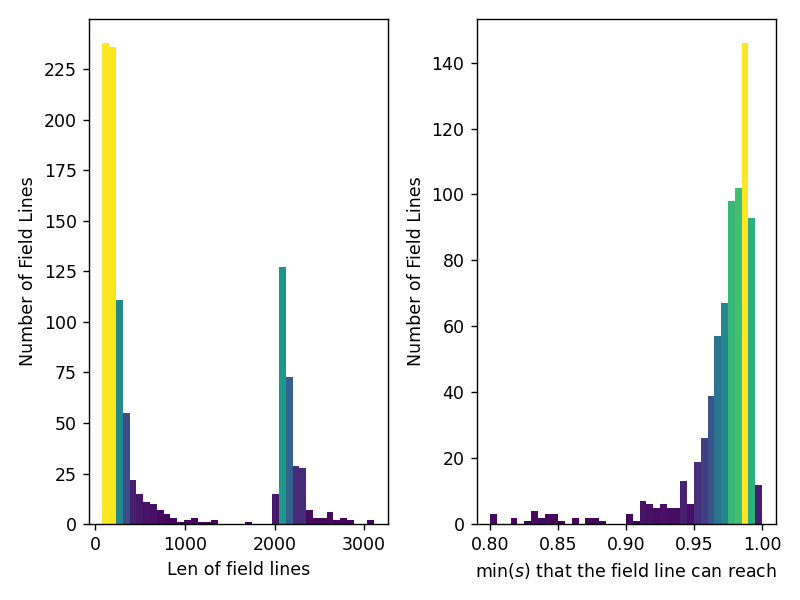

/usr/local/lib/python3.7/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.7/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


In [43]:
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter, MaxNLocator

fig, axs = plt.subplots(1, 2, tight_layout=True)

for i, param in enumerate(['Len', 'Min s']):
    ax = axs[i]
    # N is the count in each bin, bins is the lower-limit of the bin
    x_range = [0.8, 1.0] if param=='Min s' else None
    N, bins, patches = ax.hist(FLT_df[param], bins=40, range=x_range) 
    if param=='Len':
        ax.set_xlabel('Len of field lines', fontsize=10)
    elif param=='Min s':
        ax.set_xlabel('$\min(s)$ that the field line can reach', fontsize=10)
    ax.set_ylabel('Number of Field Lines', fontsize=10)
#     ax.set_title('Colour = length of field lines (m)', fontsize=15)

    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    # We'll color code by height, but you could use any scalar
    fracs = N / N.max()
    # we need to normalize the data to 0..1 for the full range of the colormap
    norm = colors.Normalize(fracs.min(), fracs.max())
    # Now, we'll loop through our objects and set the color of each accordingly
    for thisfrac, thispatch in zip(fracs, patches):
        color = plt.cm.viridis(norm(thisfrac))
        thispatch.set_facecolor(color)
    
fig.savefig(path_data / 'hist.png', dpi=300)

# ax = axs[1]
# # We can also normalize our inputs by the total number of counts
# axs[1].hist(UP_SP_rzphi[:,1], bins=n_bins, density=True)

# # Now we format the y-axis to display percentage
# axs[1].yaxis.set_major_formatter(PercentFormatter(xmax=1))


In [44]:
from importlib import reload
reload(equilibrium)

<module 'ergospy.visual.equilibrium' from '/data/ERGOS/ergos-east/ergospy/visual/equilibrium.py'>

<IPython.core.display.Javascript object>


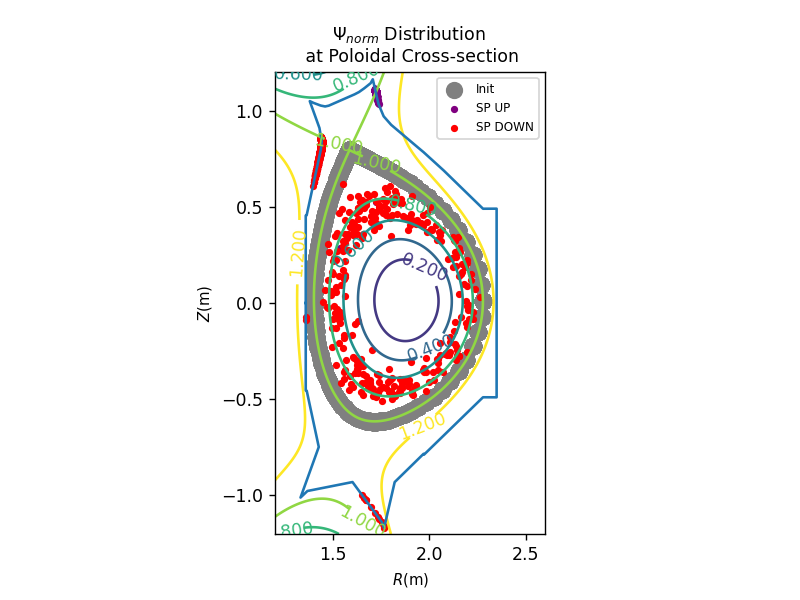

In [46]:
from ergospy.measure import divertor
import matplotlib.pyplot as plt
import numpy as np
from ergospy.visual import equilibrium
%matplotlib notebook

fig, ax = plt.subplots(1, 1)
ax.plot(div_RZ[:,0], div_RZ[:,1])
point = np.array([1.4371,0.7983])
ax.scatter(FLT_df['Init R'],FLT_df['Init Z'], s=80, c='grey', label='Init')
# ax.scatter(SP_rzphi[:,0], SP_rzphi[:,1], s=10, c='purple', label='SP UP')

ax.scatter(SP_rzphi[:len(FLT_df),0], SP_rzphi[:len(FLT_df),1], s=10, c='purple', label='SP UP')
ax.scatter(SP_rzphi[len(FLT_df):,0], SP_rzphi[len(FLT_df):,1], s=10, c='red', label='SP DOWN')
ax.set_aspect('equal')
ax.legend(fontsize='x-small')
equilibrium.s_equili_pol_section(folder_equilibrium, fig=fig,ax=ax)
plt.show()

fig.savefig(path_data / 'SP.png', dpi=300)
# tile_ind, tile_mu = divertor.nearest_tile_ind_mu(point, div_edge)
# print(divertor.div_len_from_origin(tile_ind, tile_mu, div_edge))


<IPython.core.display.Javascript object>


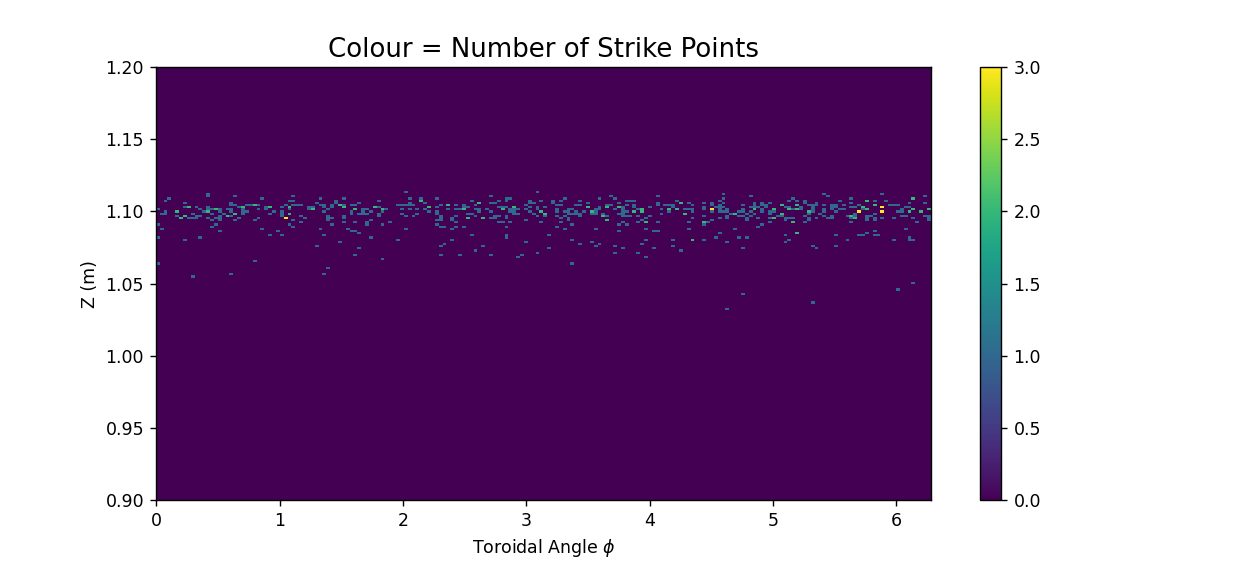

In [63]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1,figsize=(10,4.5))

ax.set_xlabel('Toroidal Angle $\phi$', fontsize=10)
ax.set_ylabel('Length along the Divertor (m)', fontsize=10)
ax.set_title('Colour = length of field lines (m)', fontsize=15)
# pc = ax.pcolormesh(
#     FLT_df['Init Phi'].to_numpy(dtype='float').reshape(Dist_N, Phi_N),
#     FLT_df['Dist'].to_numpy(dtype='float').reshape(Dist_N, Phi_N), 
#     FLT_df['Len'].to_numpy(dtype='float').reshape(Dist_N, Phi_N),
#     cmap='plasma', vmin=0.)
# fig.colorbar(pc, ax=ax)

ax.set_xlabel('Toroidal Angle $\phi$', fontsize=10)
ax.set_ylabel('Z (m)', fontsize=10)
ax.set_title('Colour = Number of Strike Points', fontsize=15)
counts, xedges, yedges, im = ax.hist2d(
    FLT_df[~FLT_df['Len'].isnull()]['Up End Phi'].to_numpy(dtype='float') % (2*np.pi),
    FLT_df[~FLT_df['Len'].isnull()]['Up End Z'].to_numpy(dtype='float'), bins=200, range=[[0.0, 2*np.pi],[0.9, 1.2]]
#     FLT_df['Len'].to_numpy(dtype='float').reshape(Dist_N, Phi_N),
#     cmap='plasma', vmin=0.
)
fig.colorbar(im, ax=ax)
fig.savefig(path_data / 'SP_dist.png', dpi=300)
plt.show()

<IPython.core.display.Javascript object>


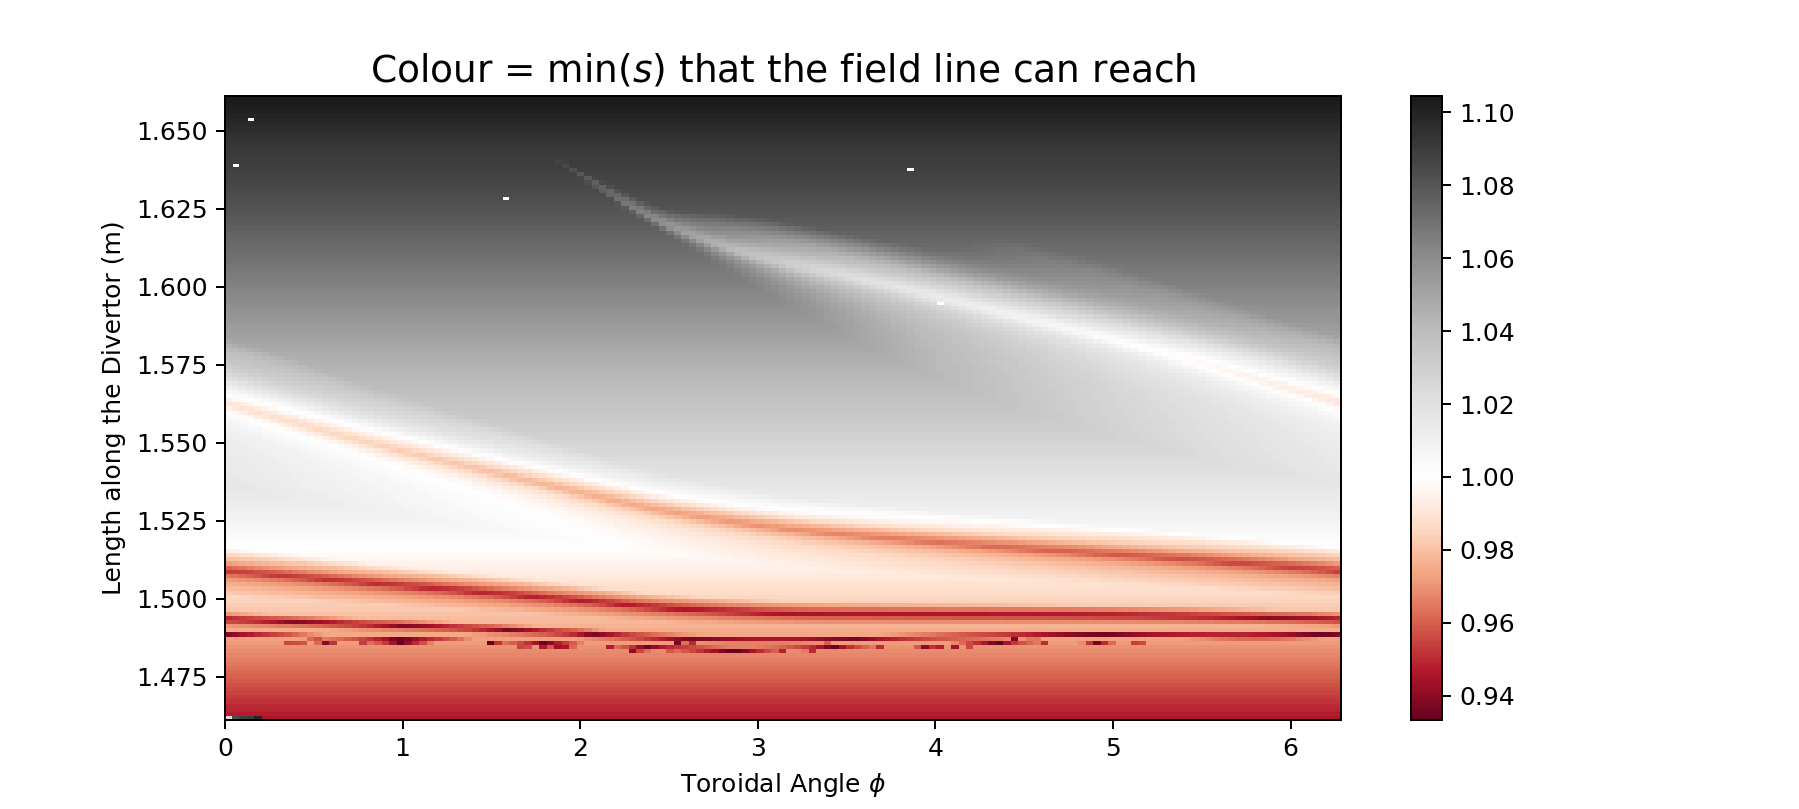

In [149]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

fig, ax = plt.subplots(1,1, figsize=(10,4.5))
ax.set_xlabel('Toroidal Angle $\phi$', fontsize=10)
ax.set_ylabel('Length along the Divertor (m)', fontsize=10)
ax.set_title('Colour = $\min(s)$ that the field line can reach', fontsize=15)
pc = ax.pcolormesh(
    FLT_df['Init Phi'].to_numpy(dtype='float').reshape(Dist_N, Phi_N),
    FLT_df['Dist'].to_numpy(dtype='float').reshape(Dist_N, Phi_N), 
    FLT_df['Min s'].to_numpy(dtype='float').reshape(Dist_N, Phi_N), 
    cmap='RdGy', norm=mcolors.TwoSlopeNorm(vcenter=1., ))
fig.colorbar(pc, ax=ax)
fig.savefig(path_data / 'min_s.png', dpi=300)
plt.show()

In [151]:

FLT_df.to_pickle(path_data / 'FLT_df.pkl')